# Import libraries

In [1]:
%run ./import_functions.ipynb

In [2]:
%run ./import_libraries.ipynb

Using TensorFlow backend.
/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lekhag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lekhag/opt/anaconda3/lib/python3.7

In [3]:
%run ./import_global_params.ipynb

In [4]:
%run ./import_eval_functions.ipynb

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.getcwd()

'/Users/lekhag/Documents/Testing Theories/Large Deviations'

# Real Data

In [6]:
# date_label=datetime.now().strftime("_%m_%d_%Y")
date_label='_2_4_2021'
newpath = os.getcwd()+'/'+date_label
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
data_path='/Users/lekhag/Documents/INCAD Improvements/Parallel Gibbs/Cleaned Version/'
    
data_source_ad=data_path+'/Data/AD/'
data_source_large=data_path+'/Data/Stream/Large'
data_source_covid=os.getcwd()+'/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'


if not os.path.exists(data_source_large):
    os.makedirs(data_source_large)

results_path_non_stream_ad=newpath+'/Results/non_streaming/AD/'
results_path_non_stream_clust=newpath+'/Results/non_streaming/Clustering/'
results_path_covid=newpath+'/Results/COVID/'
results_path_non_stream_ad_large=newpath+'/Results/non_streaming/Large/AD/'
results_path_non_stream_clust_large=newpath+'/Results/non_streaming/Large/Clustering/'



image_path_non_stream_ad=results_path_non_stream_ad+'images/'
image_path_non_stream_clust=results_path_non_stream_clust+'images/'
image_path_covid=results_path_covid+'images/'
image_path_non_stream_ad_large=results_path_non_stream_ad_large+'images/'
image_path_non_stream_clust_large=results_path_non_stream_clust_large+'images/'



if not os.path.exists(image_path_non_stream_ad):
    os.makedirs(image_path_non_stream_ad)
if not os.path.exists(image_path_non_stream_clust):
    os.makedirs(image_path_non_stream_clust)
if not os.path.exists(image_path_covid):
    os.makedirs(image_path_covid)    
if not os.path.exists(image_path_non_stream_ad_large):
    os.makedirs(image_path_non_stream_ad_large)
if not os.path.exists(image_path_non_stream_clust_large):
    os.makedirs(image_path_non_stream_clust_large)




###### Model results

In [7]:
from scipy.io import arff


###### Evaluation: AD Small

In [7]:
perf_metrics=['tn','fp','fn','tp','fpr','tpr','thresholds','recall','specificity',
         'precision','accuracy','fmeasure','purity','auc','comp_time_secs']

models=['LOF', 'KMeans--', 'KNN', 'OCSVM',
        'LDP','LDP (Score)','LDP (Group Anomalies)','LDP+Kmeans','LDP+Kmeans (Score)',
        'LDP+Kmeans (Group Anomalies)']

datasets=[]
anomalies_eval_perf_metrics = {}

for metric in perf_metrics:
    anomalies_eval_perf_metrics[metric]= pd.DataFrame( index=datasets,columns=models)

In [8]:
def eval_ldp_small(results_path_non_stream_ad,filename):
    output=pickle.load( open(results_path_non_stream_ad+filename , "rb" ) ) 
    print(name)
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    try:
        y=ana_label(y)
    except:
        y=ana_label(y['class'])
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
#         y2=np.zeros(len(y))
#         y2[y[np.array(y)!=0].index]=1
#         y=y2    
    
    I=(output['z'][0]<0)*1
    z=output['z'][0]
    N=len(I)
    prob=output['prob']

    I=((prob-np.min(prob))/(np.max(prob)-np.min(prob))>0.5)*1
    preds=I
    ldp_classify=perf_evaluate(X,y,preds)
    print("1")

    preds=np.zeros(len(I))
    preds[np.argsort(-prob)[0:int(sum(y))]]=1
    ldp_score=perf_evaluate(X,y,preds)
    fpr, tpr, thresholds = metrics.roc_curve(y, prob)
    auc=metrics.auc(fpr, tpr)
    ldp_score['auc']=auc    
    print("2")


    preds=np.copy(I)
    for k in np.unique(np.abs(z)):   
        ind_k=np.where(np.abs(z) == k)[0]
        if len(ind_k)/N<0.05:
            preds[ind_k]==1
#     preds=I
    ldp_classify_group_ana=perf_evaluate(X,y,preds)
    print("3")


    ldp_classify['comp_time_secs']=output['comp_time_secs']
    ldp_score['comp_time_secs']=output['comp_time_secs']
    ldp_classify_group_ana['comp_time_secs']=output['comp_time_secs']
    
    return ldp_classify,ldp_score,ldp_classify_group_ana

In [9]:
results_path=results_path_non_stream_ad
onlyfiles = [f for f in listdir(results_path) if isfile(join(results_path, f))]
extension = 'pickle'
result=[o for o in onlyfiles if ".pickle" in o]
result

['annthyroid.mat.pickle',
 'pima.mat.pickle',
 'vertebral.mat.pickle',
 'thyroid.mat.pickle',
 'pen-global-unsupervised-ad.csv.pickle',
 'lympho.mat.pickle',
 'wbc.mat.pickle',
 'http.pickle.pickle',
 'cardio.mat.pickle',
 'mammography.mat.pickle',
 'glass.mat.pickle',
 'breastw.mat.pickle',
 'seismic-bumps.arff.pickle',
 'cover.pickle.pickle',
 'breast-cancer-unsupervised-ad.csv.pickle',
 'wine.mat.pickle',
 'smtp.pickle.pickle',
 'vowels.mat.pickle',
 'pendigits.mat.pickle']

In [ ]:
max_size=20000
for filename in result:
    name=filename.replace(results_path_non_stream_ad,'')
    output=pickle.load( open(results_path_non_stream_ad+filename , "rb" ) ) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    try:
        y=ana_label(y)
    except:
        y=ana_label(y['class'])
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    
    ldp_classify,ldp_score,ldp_classify_group_ana=eval_ldp_small(results_path_non_stream_ad,filename)
    ldp_classify_clust,ldp_score_clust,ldp_classify_group_ana_clust=eval_ldp_small(
        results_path_non_stream_clust,filename)

    
    
    eval_metrics=eval_perf_timed(X,y)[0]
    print("4")


    for metric in perf_metrics:
        keys=eval_metrics.keys()
        m_high='fmeasure' # Metric used to order the performance
        high_keys=[]
        for key in keys:
            high_keys.append(sorted(eval_metrics[key][m_high], key=eval_metrics[key][m_high].get, reverse=True)[0])
        # print(keys,high_keys)

        pd_row=[]
        for ii,key in enumerate(eval_metrics.keys()):
#             print(key,high_keys[ii],eval_metrics[key][metric][high_keys[ii]])
            pd_row.append(eval_metrics[key][metric][high_keys[ii]])
        pd_row.append(ldp_classify[metric])
        pd_row.append(ldp_score[metric])
        pd_row.append(ldp_classify_group_ana[metric])   

        pd_row.append(ldp_classify_clust[metric])
        pd_row.append(ldp_score_clust[metric])
        pd_row.append(ldp_classify_group_ana_clust[metric])   

        
        anomalies_eval_perf_metrics[metric].loc[filename]=pd_row

In [ ]:
file_path=results_path_non_stream_ad+'Performance/'
if not os.path.exists(file_path):
    os.makedirs(file_path)

pickle.dump( anomalies_eval_perf_metrics, open( file_path+"ad_performance_untrained_small.pickle", "wb" ) )



In [18]:
file_path=results_path_non_stream_ad+'Performance/'

anomalies_eval_perf_metrics=pickle.load(open( file_path+"ad_performance_untrained_small.pickle", "rb") )

import six

def create_ranked_tables(m1,df4,drop_datasets,drop_cols,results_path_non_stream_ad_large):
    
    df_final=df4.drop(drop_cols,axis=1)

    df_t=df4.drop(['Data'],axis=1).T
    df_t=df_t.drop(drop_cols,axis=0)

    df_r1=pd.DataFrame( columns=df4.index,index=df4.columns[1:])
    df_r1=df_r1.drop(drop_cols,axis=0)

    for data_set in df4.index:
        df_r1[data_set]=df_t[data_set].rank(ascending=False)
    

    df_r1=df_r1.drop(drop_datasets,axis=1)    

    df_final=df_final.drop(drop_datasets,axis=0)    

    df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
    df_final["Data"]['Avg Rank']='AVERAGE RANK'


    render_mpl_table(df_final, header_columns=0, col_width=2.0)
    plt.savefig(results_path_non_stream_ad_large+"/images/AD_dataframe_all_ranked_by_"+m1+".png")
    return df_final,df_r1

In [11]:
#Output format: m1 (m2,m3)
m1='fmeasure'
m2='recall'
m3='precision'
m4='auc'
m5='comp_time_secs'

df = anomalies_eval_perf_metrics[m1].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df1=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m1+".png")

df = anomalies_eval_perf_metrics[m2].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df2=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m2+".png")

df = anomalies_eval_perf_metrics[m3].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df3=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m3+".png")

df = anomalies_eval_perf_metrics[m4].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df4=df.fillna(0)
# render_mpl_table(df4, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m4+".png")

df = anomalies_eval_perf_metrics[m5].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df5=df.fillna(0)



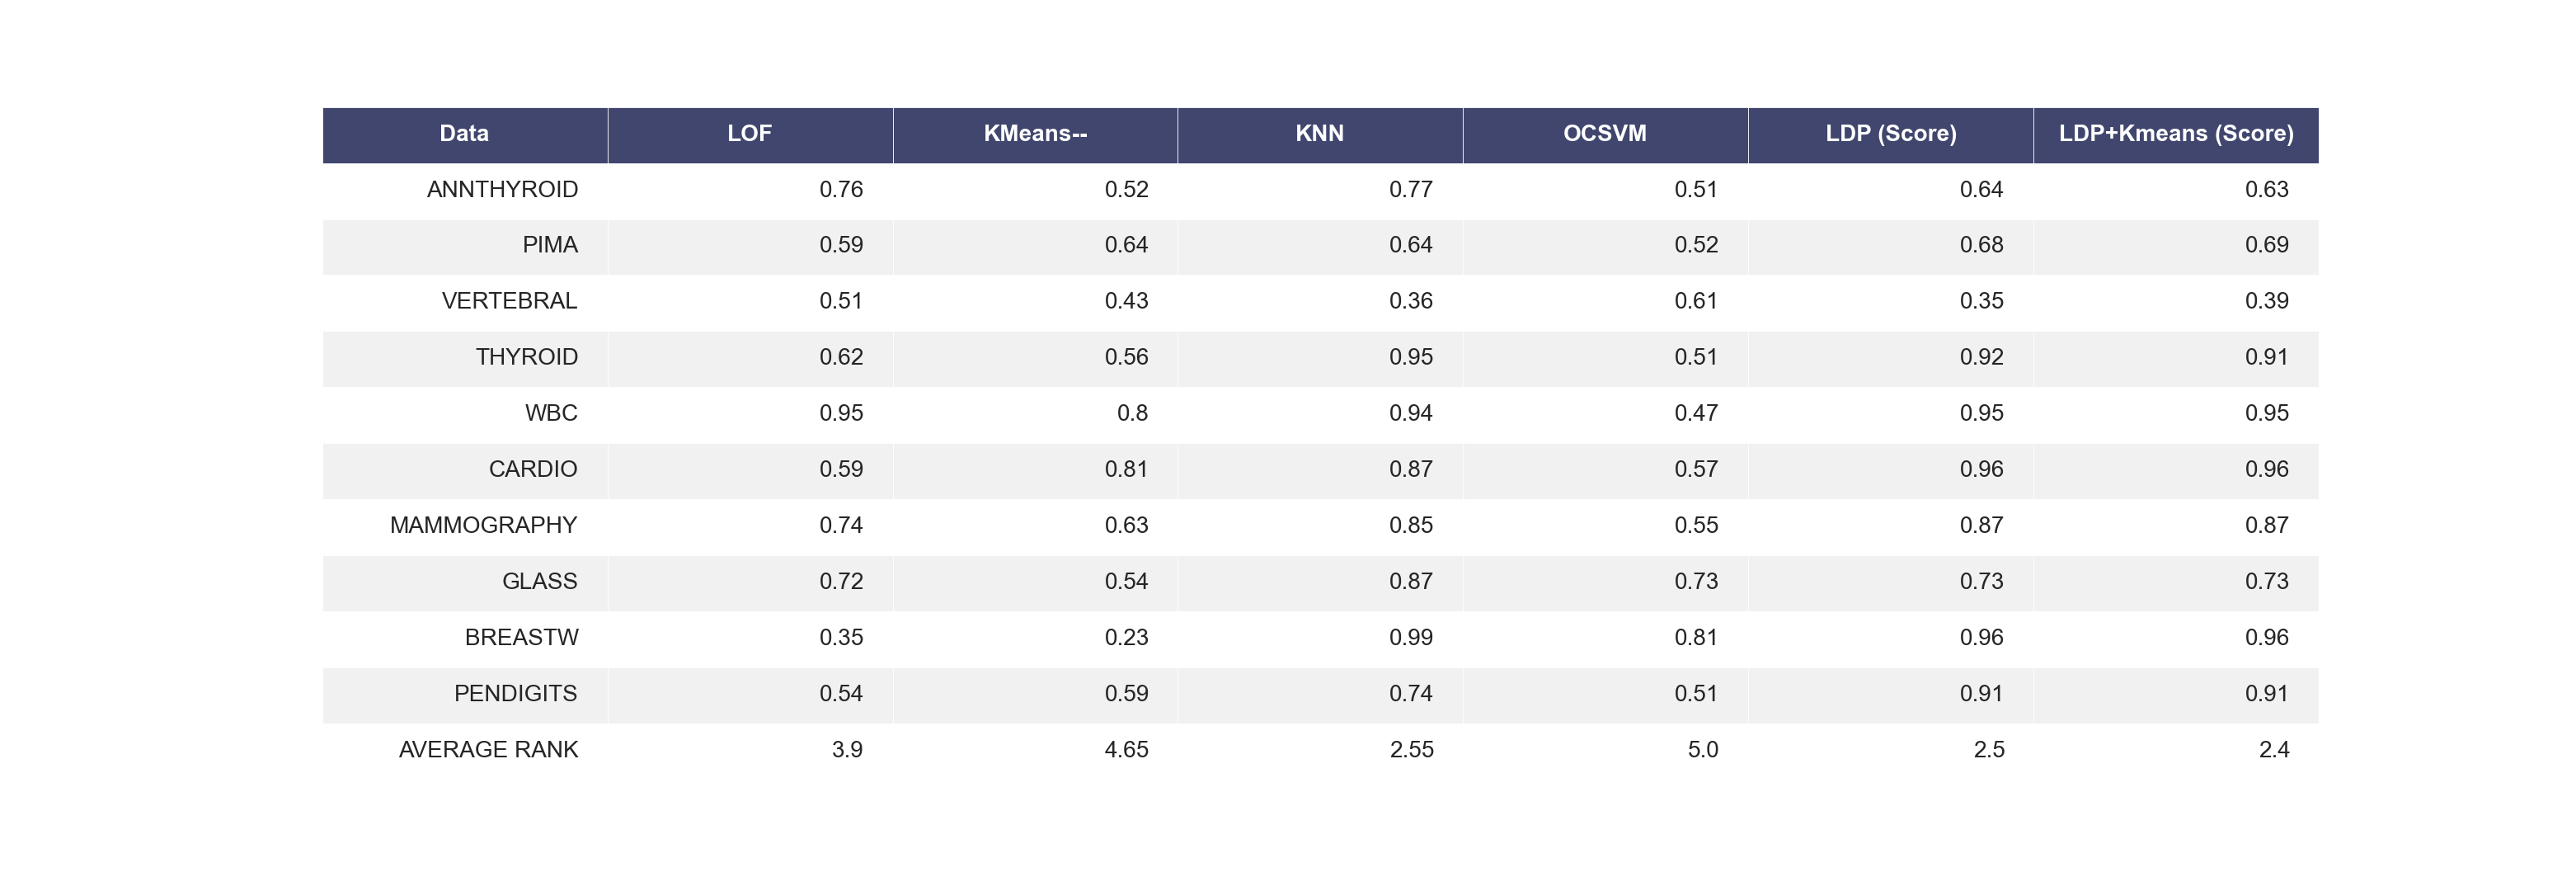

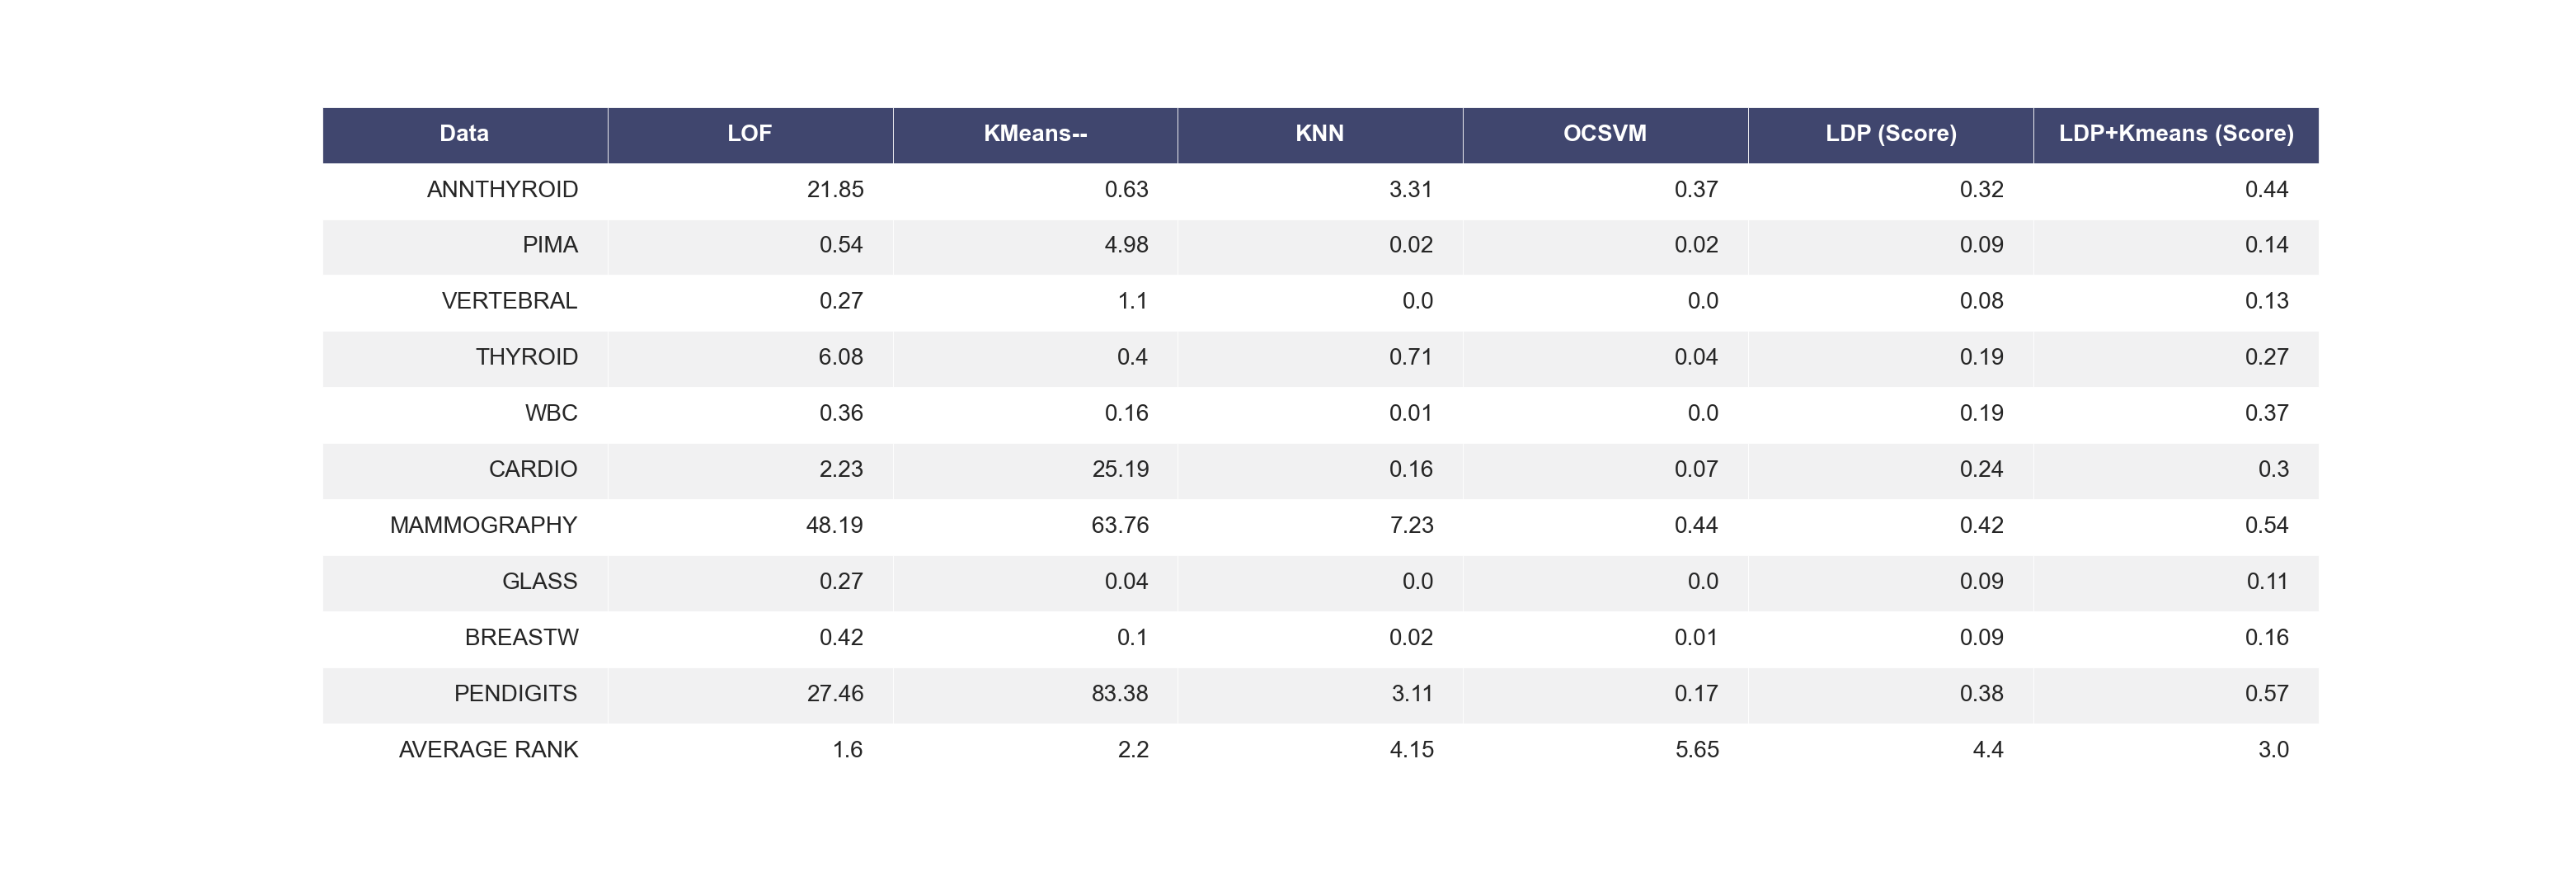

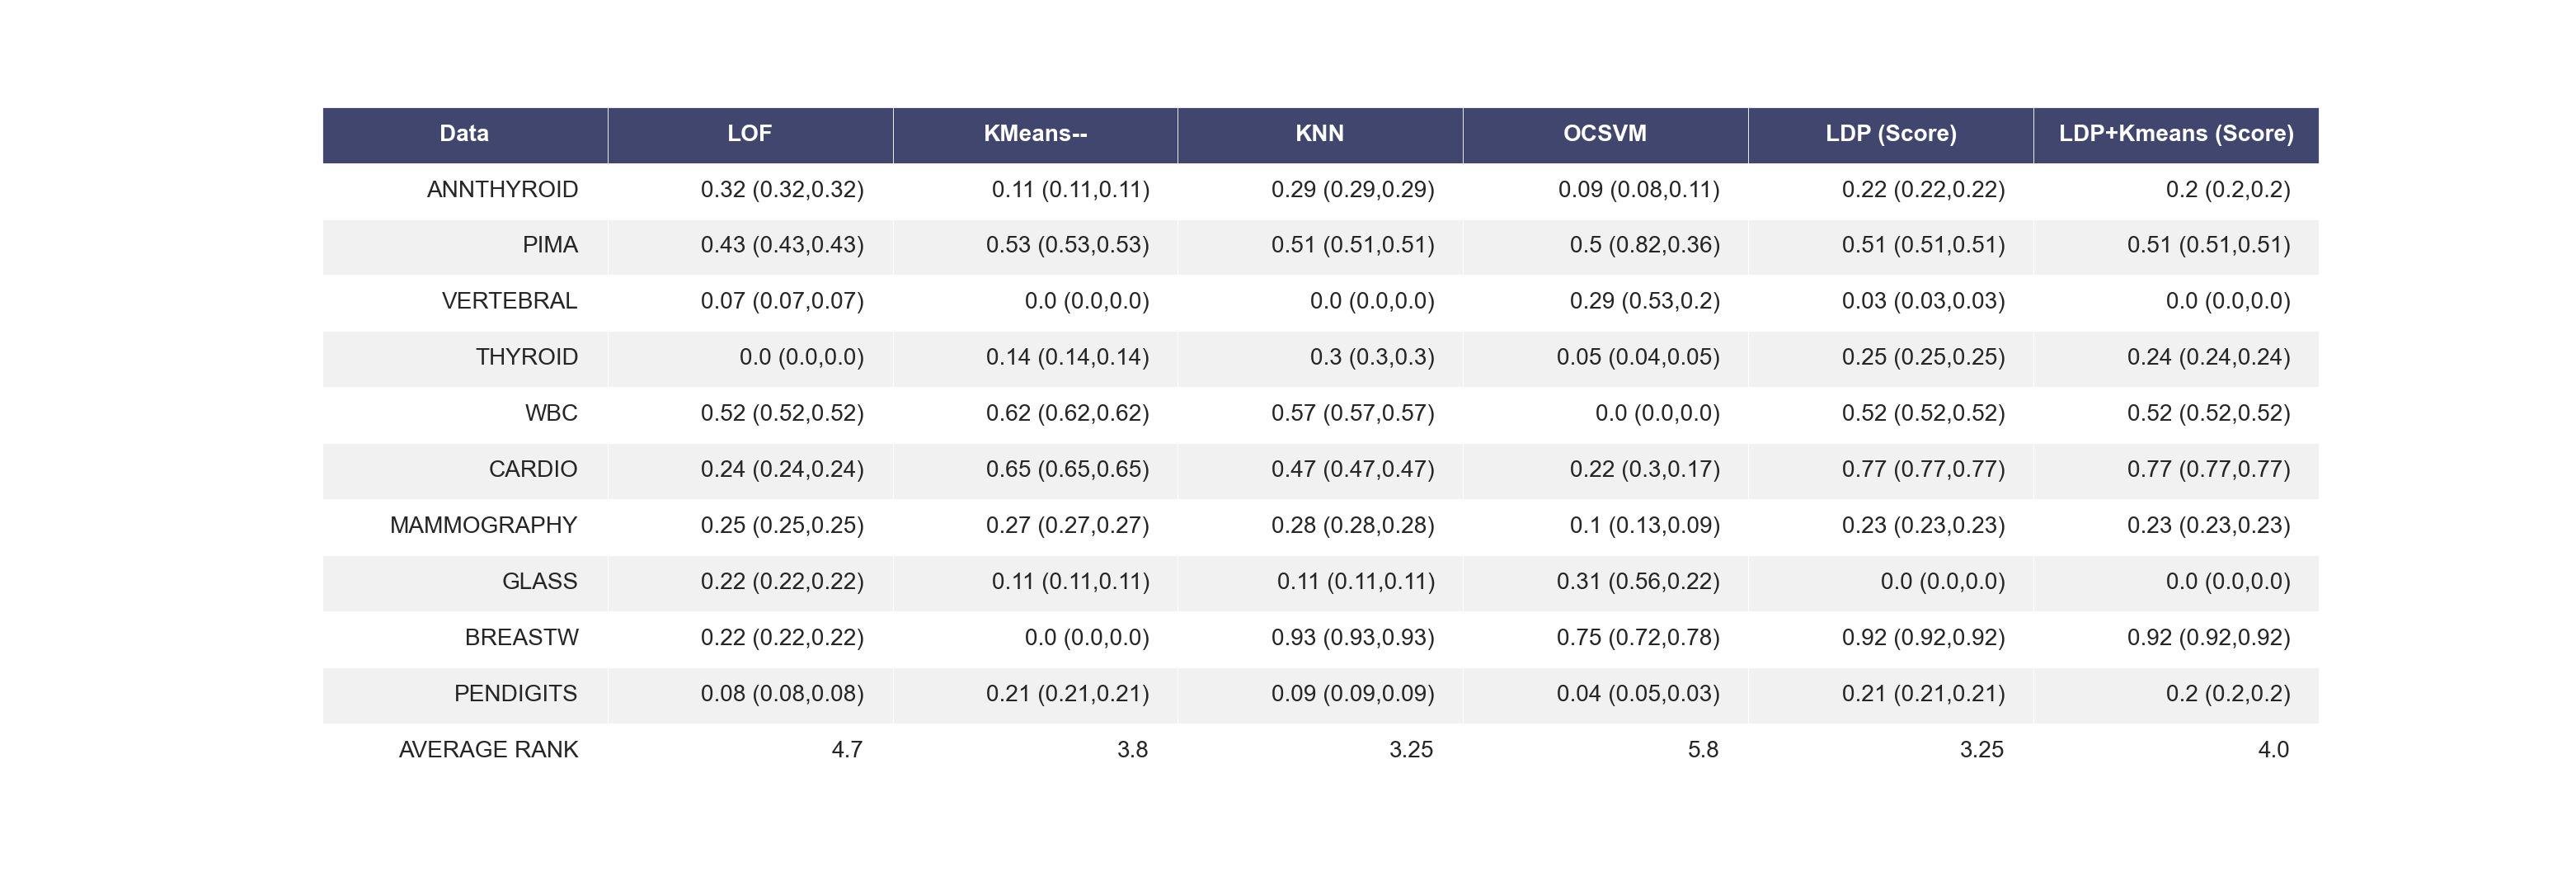

In [33]:
drop_datasets=['http.pickle.pickle','seismic-bumps.arff.pickle',
       'cover.pickle.pickle', 'smtp.pickle.pickle','pen-global-unsupervised-ad.csv.pickle',
               'breast-cancer-unsupervised-ad.csv.pickle','wine.mat.pickle', 'lympho.mat.pickle',
              'vowels.mat.pickle']

drop_cols=['LDP','LDP (Group Anomalies)', 'LDP+Kmeans','LDP+Kmeans (Group Anomalies)'
#     'LDP','LDP (Group Anomalies)','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
#           'LDP+Kmeans (Score)'
          ]

df_final,df_r1=create_ranked_tables('auc',df4,drop_datasets,drop_cols,results_path_non_stream_ad)
df_final,df_r1=create_ranked_tables('comp_time_secs',df5,drop_datasets,drop_cols,results_path_non_stream_ad)

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col
    
df_final.insert(0,"Data", df1["Data"])

df_final=df_final.drop(drop_cols,axis=1)

df_t=df1.drop(['Data'],axis=1).T

df_r1=pd.DataFrame( columns=df1.index,index=df1.columns[1:])

for data_set in df1.index:
    df_r1[data_set]=df_t[data_set].rank(ascending=False)
    
df_r1=df_r1.drop(drop_datasets,axis=1)    

df_final=df_final.drop(drop_datasets,axis=0)    

df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
df_final["Data"]['Avg Rank']='AVERAGE RANK'


render_mpl_table(df_final, header_columns=0, col_width=2.0)
plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_all_ranked_by_"+m1+".png")


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

perf_metrics=['tn','fp','fn','tp','fpr','tpr','thresholds','recall','specificity',
         'precision','accuracy','fmeasure','purity','auc','comp_time_secs']

models=['LOF_trained','iForest', 'iForest (Score)', 'EE', 'KNN_trained', 'OCSVM_trained',
       'LOF_trained (60)','iForest (60)', 'iForest (Score) (60)', 'EE (60)', 'KNN_trained (60)', 
        'OCSVM_trained (60)']

datasets=[]
anomalies_eval_perf_metrics = {}

for metric in perf_metrics:
    anomalies_eval_perf_metrics[metric]= pd.DataFrame( index=datasets,columns=models)

In [ ]:
def eval_metrics_sk_models(X,y,X_train,y_train):
    
        start=time.time()
        lof = LocalOutlierFactor(novelty=True).fit(X_train,y_train)
        preds=lof.predict(X)
        end=time.time()
        preds=(preds<0)*1
        lof_classify=perf_evaluate(X,y,preds)
        lof_classify['comp_time_secs']=end-start


        start=time.time()
        model=IsolationForest(contamination=float(np.mean(y))).fit(X_train,y_train)
        preds=model.predict(X)
        end=time.time()
        preds=(preds<0)*1
        iforest_classify=perf_evaluate(X,y,preds)
        iforest_classify['comp_time_secs']=end-start

        
        scores=model.decision_function(X)
        iforest_score=perf_evaluate(X,y,preds)
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        auc=metrics.auc(fpr, tpr)
        iforest_score['auc']=auc
        iforest_score['comp_time_secs']=end-start


        start=time.time()
        ee = EllipticEnvelope(contamination=np.mean(y)).fit(X_train,y_train)
        preds = ee.predict(X)
        end=time.time()
        preds=(preds<0)*1
        ee_classify=perf_evaluate(X,y,preds)
        ee_classify['comp_time_secs']=end-start

        
        ks = [1,2,3,4,5,10,20,50,100]
        knn_classify={}

        for k in ks:
            try:
                start=time.time()
                knn = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
                preds = knn.predict(X)
                end=time.time()
                preds=(preds<0)*1
                knn_classify[k]=perf_evaluate(X,y,preds)
                knn_classify[k]['comp_time_secs']=end-start
            except:
                pass

        ocsvm_classify={}
        nu = np.mean(y)
        for gmma in np.arange(0.05,1,0.05):
            start=time.time()
            oc = ocsvm(nu=nu,gamma=gmma).fit(X_train)
            p = oc.predict(X)
            preds = np.zeros(p.shape)
            end=time.time()
            preds=(preds<0)*1
            ocsvm_classify[gmma]=perf_evaluate(X,y,preds)
            ocsvm_classify[gmma]['comp_time_secs']=end-start

        return lof_classify,iforest_classify,iforest_score,ee_classify,knn_classify,ocsvm_classify

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
max_size=20000
for filename in result:
    name=filename.replace(results_path_non_stream_ad,'')
    output=pickle.load( open(results_path_non_stream_ad+filename , "rb" ) ) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    try:
        y=ana_label(y)
    except:
        y=ana_label(y['class'])
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    
    ldp_classify,ldp_score,ldp_classify_group_ana=eval_ldp_small(results_path_non_stream_ad,filename)
    ldp_classify_clust,ldp_score_clust,ldp_classify_group_ana_clust=eval_ldp_small(
        results_path_non_stream_clust,filename)

    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=False)
    lof_classify_f,iforest_classify_f,iforest_score_f,ee_classify_f,knn_classify_f,ocsvm_classify_f= eval_metrics_sk_models(X,y,
                                                                                X,y)

    lof_classify,iforest_classify,iforest_score,ee_classify,knn_classify,ocsvm_classify= eval_metrics_sk_models(X,y,
                                                                                X_train,y_train)
    
    eval_results=[lof_classify_f,iforest_classify_f,iforest_score_f,ee_classify_f,
                  knn_classify_f,ocsvm_classify_f,
                 lof_classify,iforest_classify,iforest_score,ee_classify,knn_classify,ocsvm_classify]

    print("4")

    for metric in perf_metrics:
        pd_row=[]
        for model in eval_results:
            try:
                pd_row.append(model[metric])
            except:
                param_tested=model.keys()
                m2='fmeasure'
                l1=[]
                l2=[]
                for para in param_tested:
                    l1.append(model[para][metric])
                    l2.append(model[para][m2])

                pd_row.append(l1[np.argmax(l2)])


        anomalies_eval_perf_metrics[metric].loc[filename]=pd_row
        

In [ ]:
file_path=results_path_non_stream_ad+'Performance/'
if not os.path.exists(file_path):
    os.makedirs(file_path)

pickle.dump( anomalies_eval_perf_metrics, open( file_path+"ad_performance_trained_small.pickle", "wb" ) )




In [ ]:
file_path=results_path_non_stream_ad+'Performance/'

anomalies_eval_perf_metrics=pickle.load(open( file_path+"ad_performance_trained_small.pickle", "rb") )

import six
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return parse(string, fuzzy=fuzzy).strftime("_%m_%d_%Y")

    except ValueError:
        return ("")
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=28,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width*3.1, row_height*2])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax    
def create_ranked_tables(m1,df4,drop_datasets,drop_cols,results_path_non_stream_ad_large,suffix):
    
    df_final=df4.drop(drop_cols,axis=1)

    df_t=df4.drop(['Data'],axis=1).T
    df_t=df_t.drop(drop_cols,axis=0)

    df_r1=pd.DataFrame( columns=df4.index,index=df4.columns[1:])
    df_r1=df_r1.drop(drop_cols,axis=0)

    for data_set in df4.index:
        df_r1[data_set]=df_t[data_set].rank(ascending=False)
    

    df_r1=df_r1.drop(drop_datasets,axis=1)    

    df_final=df_final.drop(drop_datasets,axis=0)    

    df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
    df_final["Data"]['Avg Rank']='AVERAGE RANK'


    render_mpl_table(df_final, header_columns=0, col_width=2.0)
    plt.savefig(results_path_non_stream_ad_large+"/images/AD_dataframe_all_ranked_by_"+m1+"_"+suffix+".png")

In [ ]:
#Output format: m1 (m2,m3)
m1='fmeasure'
m2='recall'
m3='precision'
m4='auc'
m5='comp_time_secs'

df = anomalies_eval_perf_metrics[m1].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df1=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m1+".png")

df = anomalies_eval_perf_metrics[m2].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df2=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m2+".png")

df = anomalies_eval_perf_metrics[m3].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df3=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m3+".png")

df = anomalies_eval_perf_metrics[m4].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df4=df.fillna(0)
# render_mpl_table(df4, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m4+".png")

df = anomalies_eval_perf_metrics[m5].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df5=df.fillna(0)



In [ ]:
drop_datasets=[]

drop_cols=[
#     'LDP','LDP (Group Anomalies)','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
#           'LDP+Kmeans (Score)'
          ]

suffix='trained'
create_ranked_tables('auc',df4,drop_datasets,drop_cols,results_path_non_stream_ad,suffix)
create_ranked_tables('comp_time_secs',df5,drop_datasets,drop_cols,results_path_non_stream_ad,suffix)

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col
    
df_final.insert(0,"Data", df1["Data"])

df_t=df1.drop(['Data'],axis=1).T

df_r1=pd.DataFrame( columns=df1.index,index=df1.columns[1:])

for data_set in df1.index:
    df_r1[data_set]=df_t[data_set].rank(ascending=False)
    
df_r1=df_r1.drop(drop_datasets,axis=1)    

df_final=df_final.drop(drop_datasets,axis=0)    

df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
df_final["Data"]['Avg Rank']='AVERAGE RANK'


render_mpl_table(df_final, header_columns=0, col_width=2.0)
plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_all_ranked_by_"+m1+"_trained.png")


###### Additional Results

In [136]:
file_path=results_path_non_stream_ad+'Performance/'

anomalies_eval_perf_metrics=pickle.load(open( file_path+"ad_performance_untrained_small.pickle", "rb") )

import six

def create_ranked_tables(m1,df4,drop_datasets,drop_cols,results_path_non_stream_ad_large,suffix):
    
    df_final=df4.drop(drop_cols,axis=1)

    df_t=df4.drop(['Data'],axis=1).T
    df_t=df_t.drop(drop_cols,axis=0)

    df_r1=pd.DataFrame( columns=df4.index,index=df4.columns[1:])
    df_r1=df_r1.drop(drop_cols,axis=0)

    for data_set in df4.index:
        df_r1[data_set]=df_t[data_set].rank(ascending=False)
    

    df_r1=df_r1.drop(drop_datasets,axis=1)    

    df_final=df_final.drop(drop_datasets,axis=0)    

    df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
    df_final["Data"]['Avg Rank']='AVERAGE RANK'


    render_mpl_table(df_final, header_columns=0, col_width=2.0)
    plt.savefig(results_path_non_stream_ad_large+"/images/AD_dataframe_all_ranked_by_"+m1+'_'+suffix+".png")
    return df_final,df_r1

In [48]:
#Output format: m1 (m2,m3)
m1='fmeasure'
m2='recall'
m3='precision'
m4='auc'
m5='comp_time_secs'

df = anomalies_eval_perf_metrics[m1].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df1=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m1+".png")

df = anomalies_eval_perf_metrics[m2].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df2=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m2+".png")

df = anomalies_eval_perf_metrics[m3].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df3=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m3+".png")

df = anomalies_eval_perf_metrics[m4].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df4=df.fillna(0)
# render_mpl_table(df4, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m4+".png")

df = anomalies_eval_perf_metrics[m5].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df5=df.fillna(0)



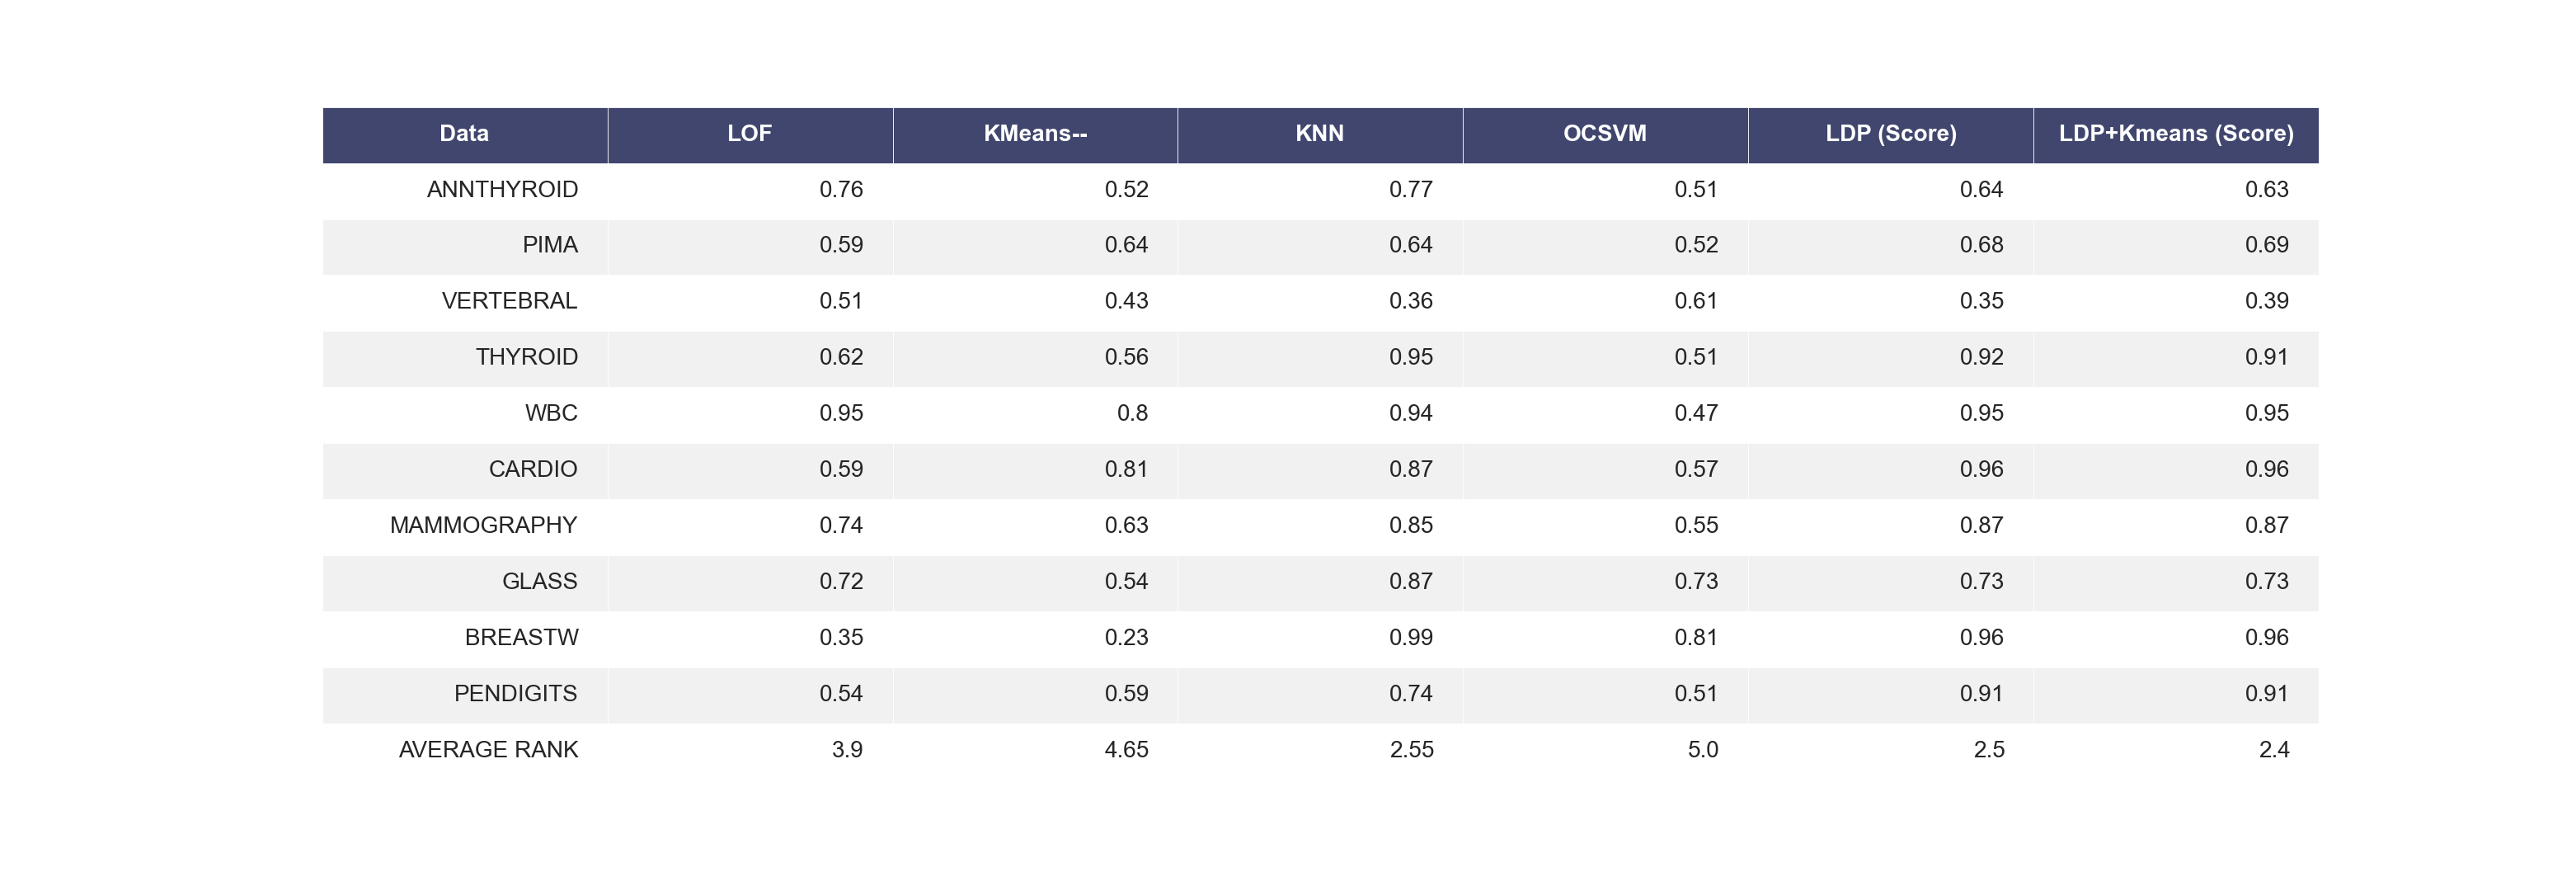

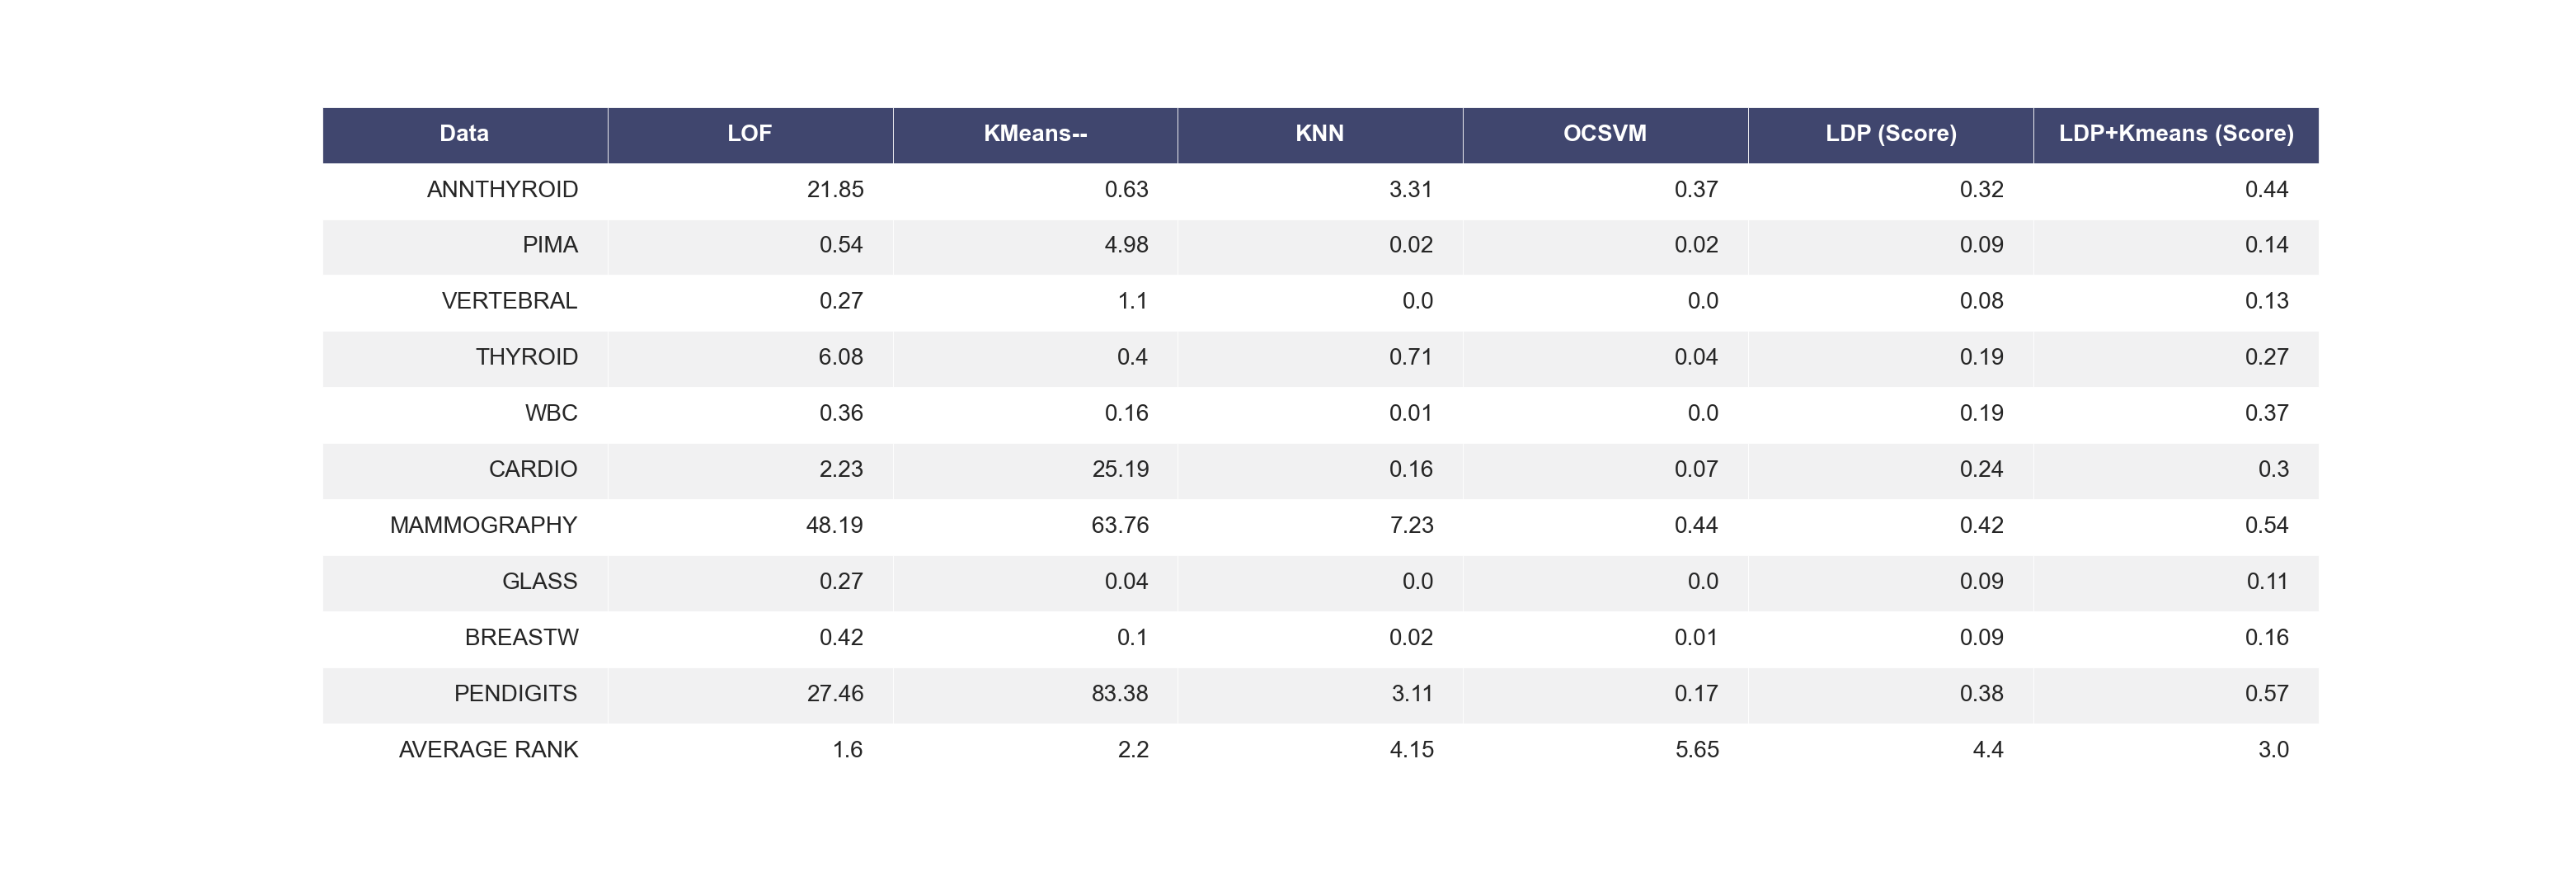

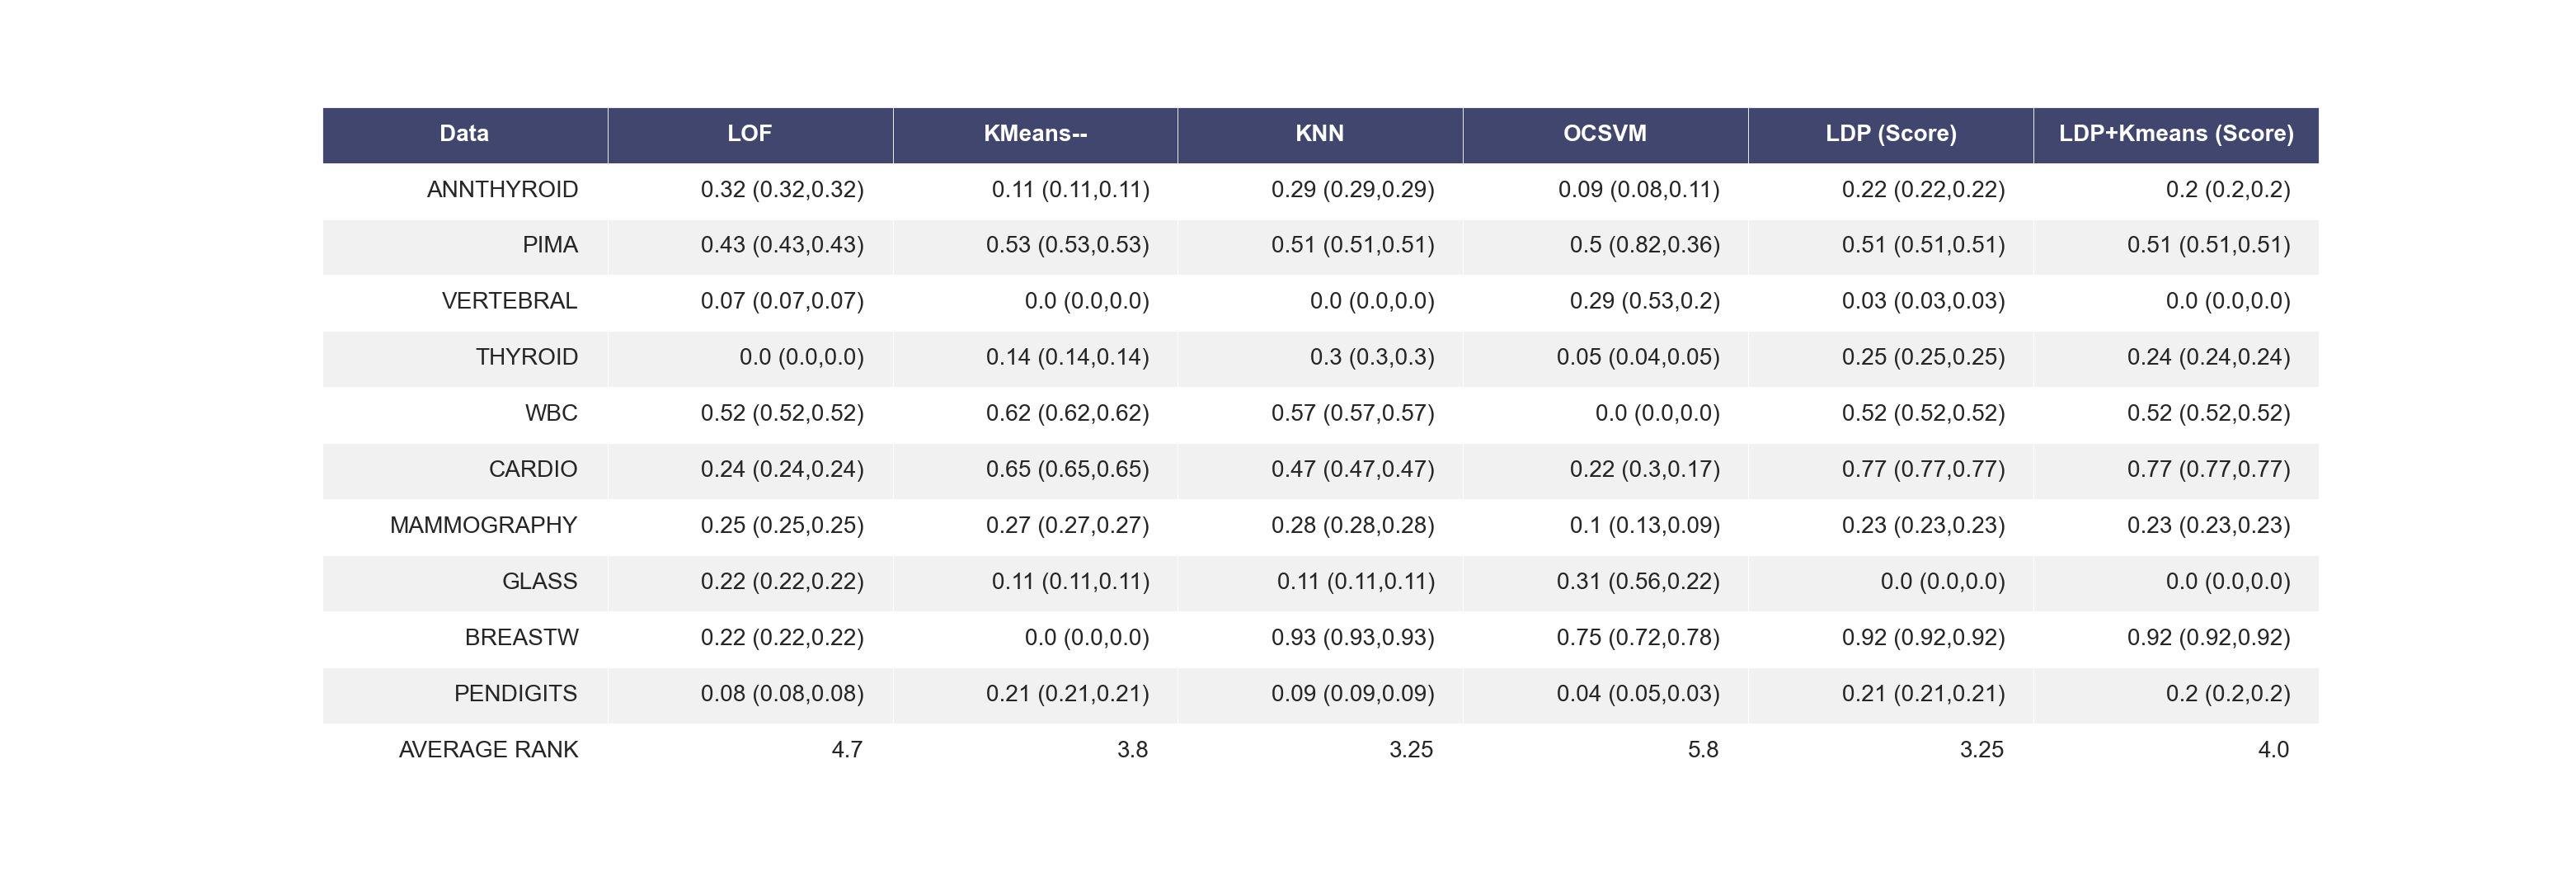

In [49]:
drop_datasets=['http.pickle.pickle','seismic-bumps.arff.pickle',
       'cover.pickle.pickle', 'smtp.pickle.pickle','pen-global-unsupervised-ad.csv.pickle',
               'breast-cancer-unsupervised-ad.csv.pickle','wine.mat.pickle', 'lympho.mat.pickle',
              'vowels.mat.pickle']

drop_cols=['LDP','LDP (Group Anomalies)', 'LDP+Kmeans','LDP+Kmeans (Group Anomalies)'
#     'LDP','LDP (Group Anomalies)','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
#           'LDP+Kmeans (Score)'
          ]

df_final,df_r1=create_ranked_tables('auc',df4,drop_datasets,drop_cols,results_path_non_stream_ad,'')
df_final,df_r1=create_ranked_tables('comp_time_secs',df5,drop_datasets,drop_cols,results_path_non_stream_ad,'')

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col
    
df_final.insert(0,"Data", df1["Data"])

df_final=df_final.drop(drop_cols,axis=1)

df_t=df1.drop(['Data'],axis=1).T

df_r1=pd.DataFrame( columns=df1.index,index=df1.columns[1:])

for data_set in df1.index:
    df_r1[data_set]=df_t[data_set].rank(ascending=False)
    
df_r1=df_r1.drop(drop_datasets,axis=1)    

df_final=df_final.drop(drop_datasets,axis=0)    

df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
df_final["Data"]['Avg Rank']='AVERAGE RANK'


render_mpl_table(df_final, header_columns=0, col_width=2.0)
plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_all_ranked_by_"+m1+".png")


In [50]:
file_path=results_path_non_stream_ad+'Performance/'

anomalies_eval_perf_metrics_trained=pickle.load(open( file_path+"ad_performance_trained_small.pickle", "rb") )

#Output format: m1 (m2,m3)
m1='fmeasure'
m2='recall'
m3='precision'
m4='auc'
m5='comp_time_secs'

df_trained = anomalies_eval_perf_metrics_trained[m1].round(2)
df_trained.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df_trained.index])
df_trained1=df_trained.fillna(0)
# render_mpl_table(df_trained, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m1+".png")

df_trained = anomalies_eval_perf_metrics_trained[m2].round(2)
df_trained.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df_trained.index])
df_trained2=df_trained.fillna(0)
# render_mpl_table(df_trained, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m2+".png")

df_trained = anomalies_eval_perf_metrics_trained[m3].round(2)
df_trained.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df_trained.index])
df_trained3=df_trained.fillna(0)
# render_mpl_table(df_trained, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m3+".png")

df_trained = anomalies_eval_perf_metrics_trained[m4].round(2)
df_trained.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df_trained.index])
df_trained4=df_trained.fillna(0)
# render_mpl_table(df_trained4, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m4+".png")

df_trained = anomalies_eval_perf_metrics_trained[m5].round(2)
df_trained.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df_trained.index])
df_trained5=df_trained.fillna(0)




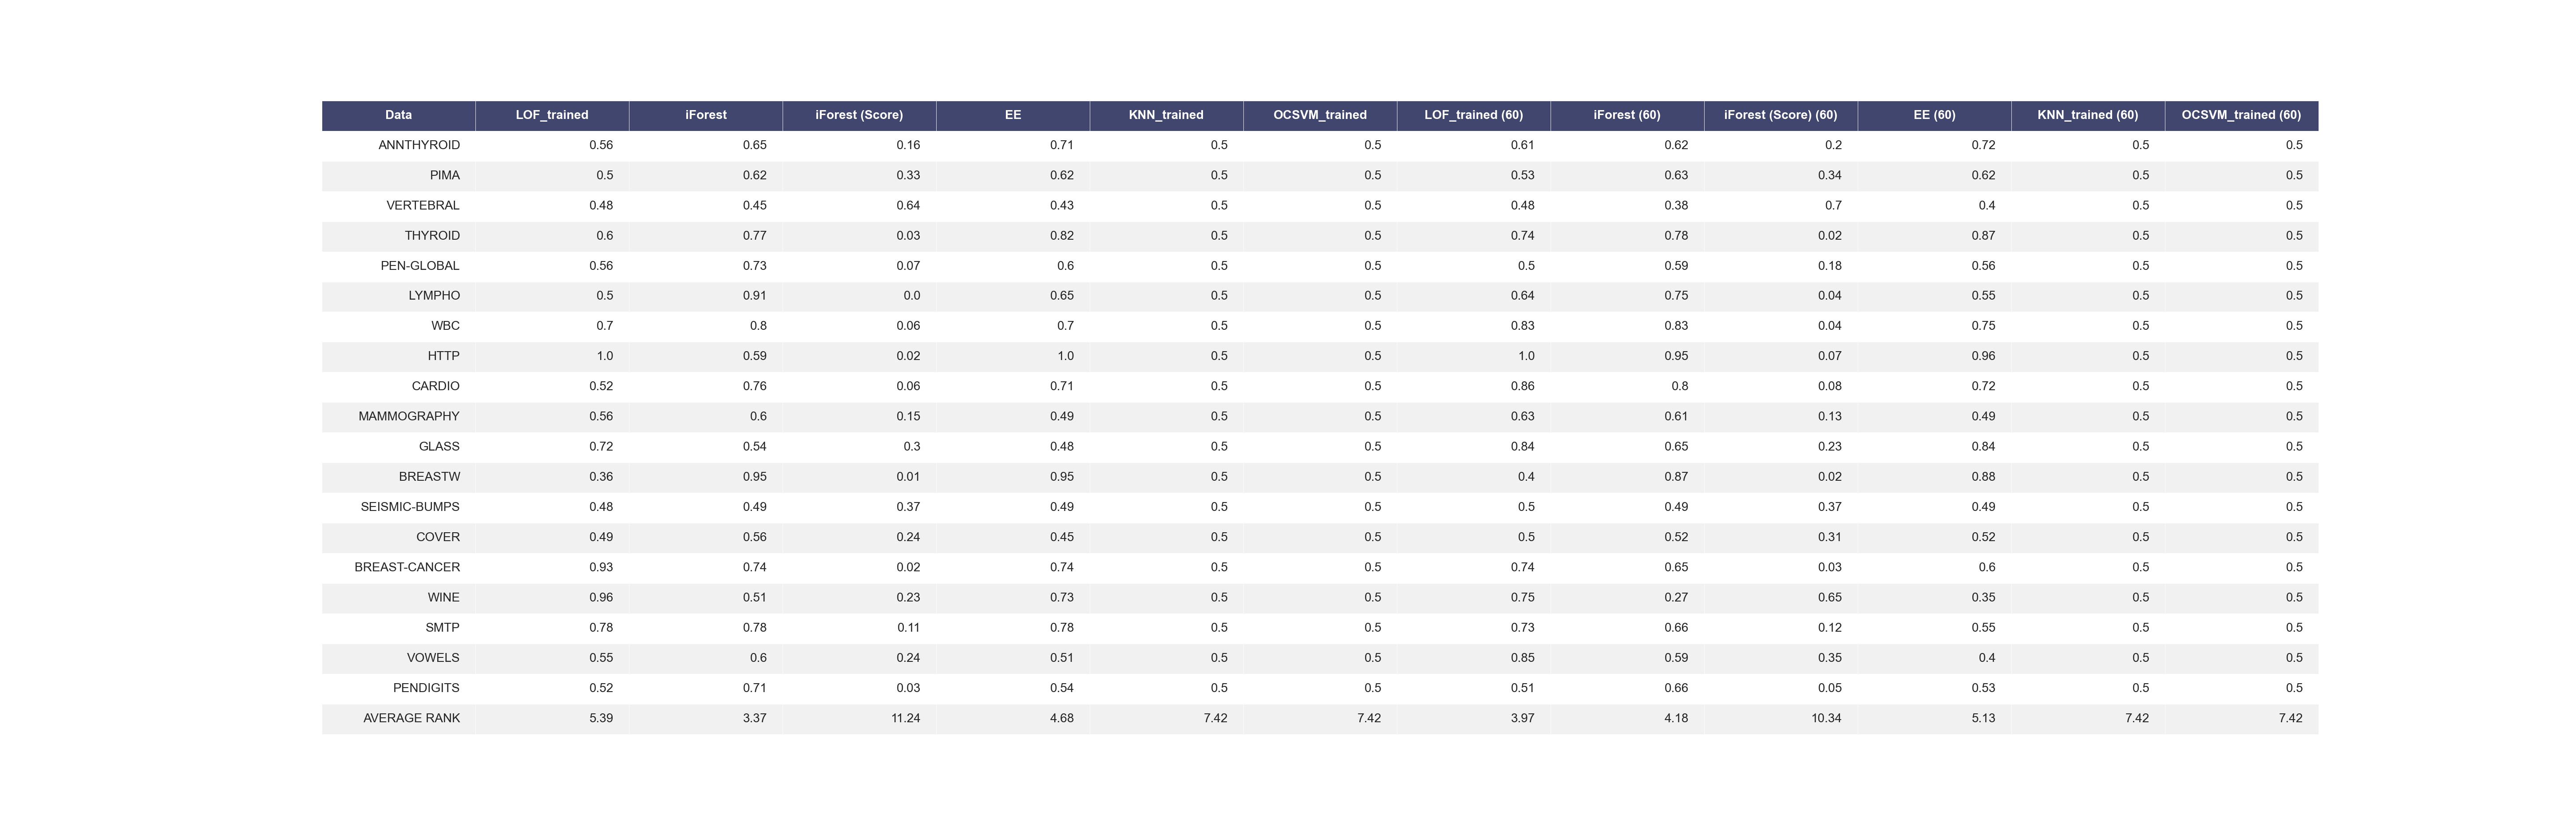

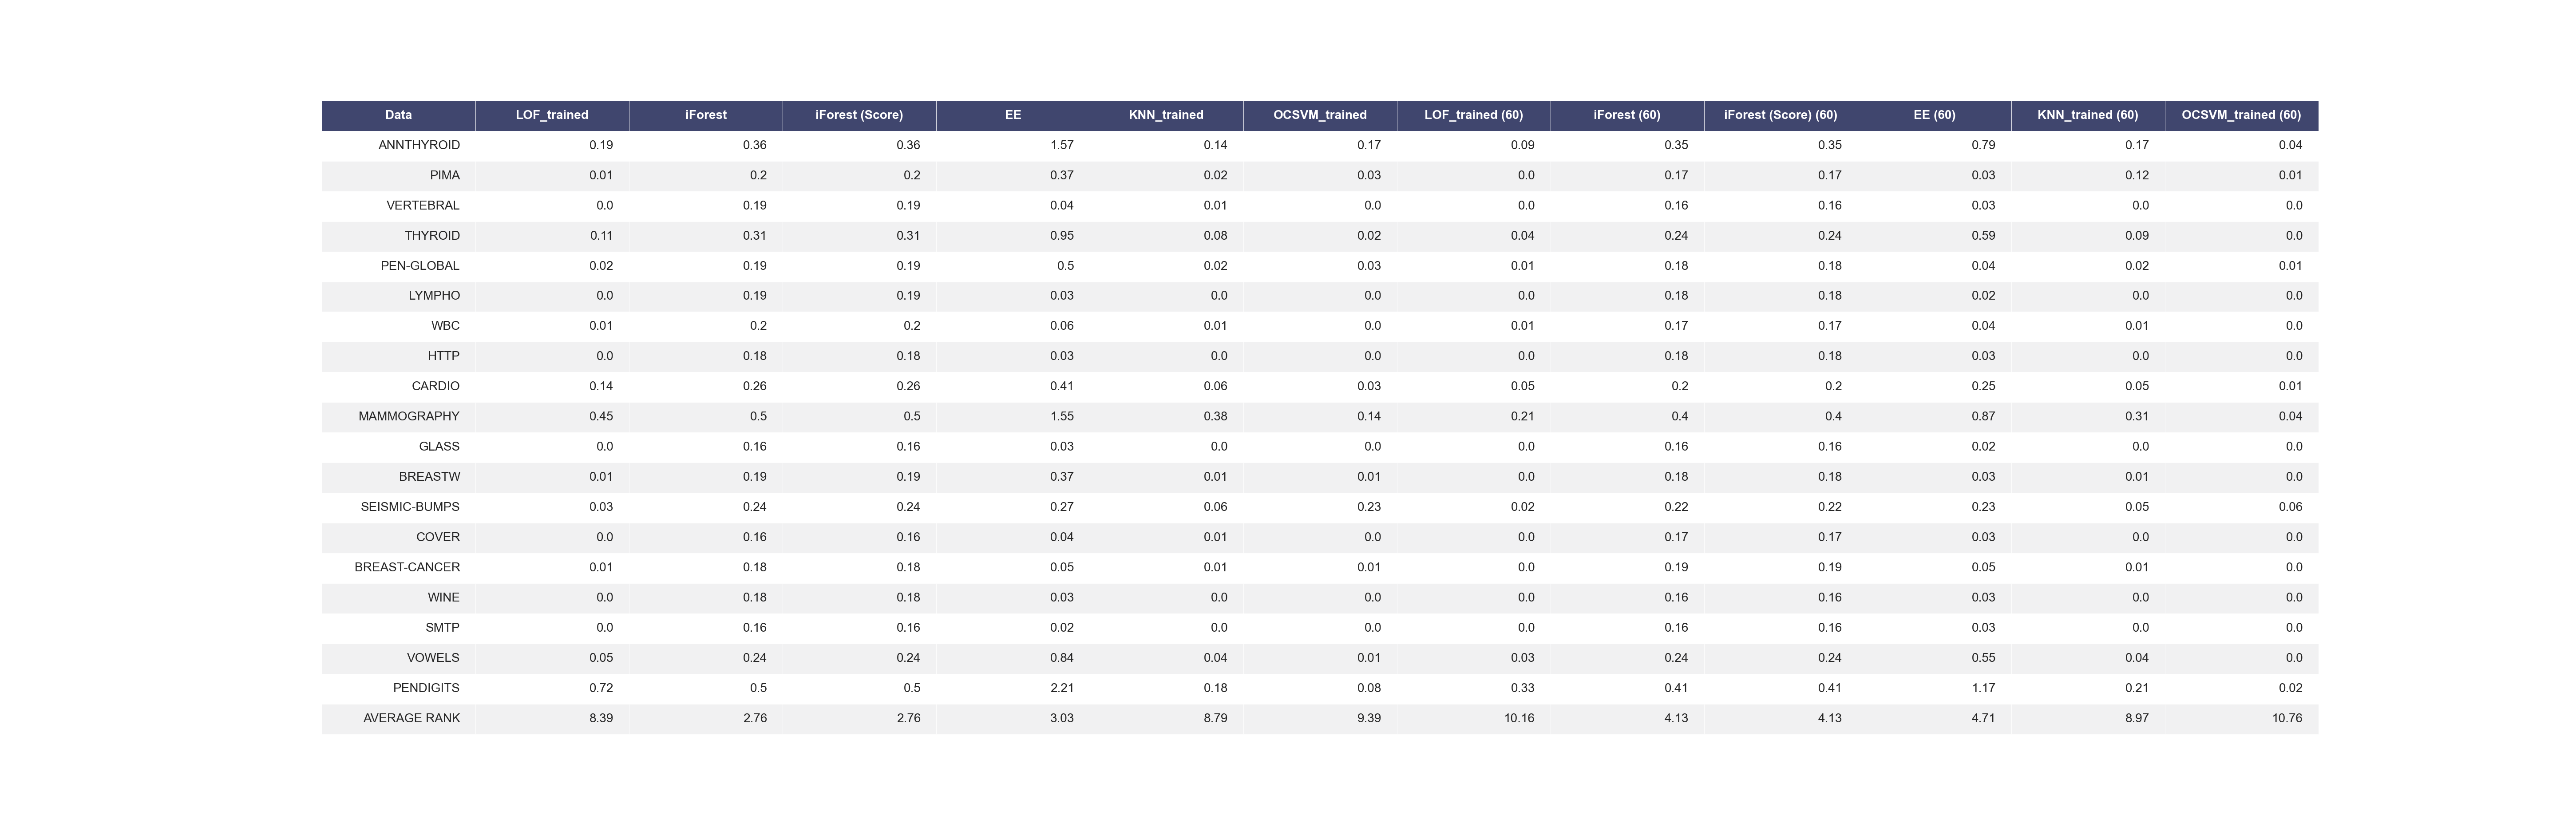

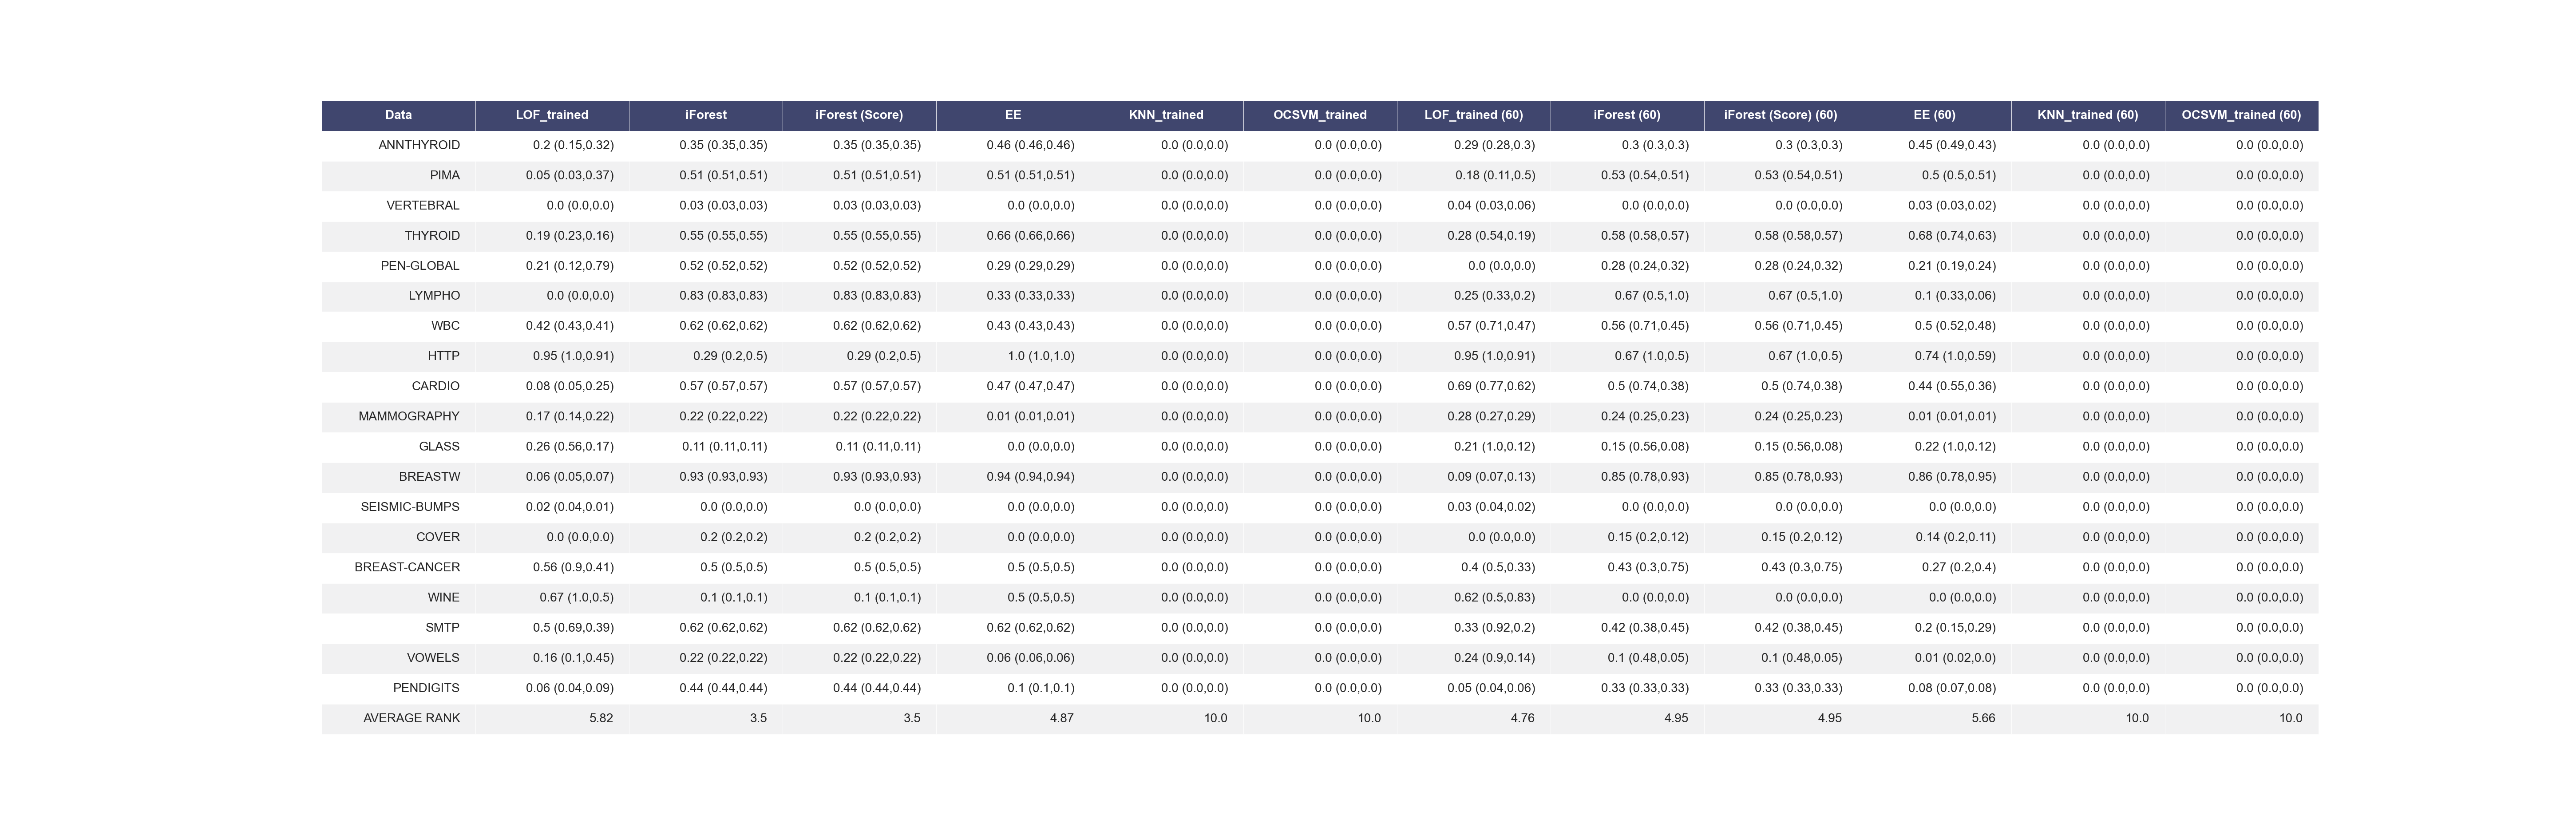

In [51]:
drop_datasets=[]

drop_cols=[
#     'LDP','LDP (Group Anomalies)','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
#           'LDP+Kmeans (Score)'
          ]

suffix='trained'
# create_ranked_tables('auc',df_trained4,drop_datasets,drop_cols,results_path_non_stream_ad,suffix)
# create_ranked_tables('comp_time_secs',df_trained5,drop_datasets,drop_cols,results_path_non_stream_ad,suffix)

df_trained_final,df_trained_r1=create_ranked_tables('auc',df_trained4,drop_datasets,drop_cols,results_path_non_stream_ad,'trained')
df_trained_final,df_trained_r1=create_ranked_tables('comp_time_secs',df_trained5,drop_datasets,drop_cols,results_path_non_stream_ad,'trained')


df_trained_final=pd.DataFrame( index=df_trained1.index,columns=df_trained1.columns[1:])
for data_set in df_trained1.index:
    pd_col=[]
    for m in df_trained1.columns[1:]:
        pd_col.append(str(df_trained1[m][data_set])+' ('+str(df_trained2[m][data_set])+','+str(df_trained3[m][data_set])+')')
    df_trained_final.loc[data_set]=pd_col

df_trained_final=pd.DataFrame( index=df_trained1.index,columns=df_trained1.columns[1:])
for data_set in df_trained1.index:
    pd_col=[]
    for m in df_trained1.columns[1:]:
        pd_col.append(str(df_trained1[m][data_set])+' ('+str(df_trained2[m][data_set])+','+str(df_trained3[m][data_set])+')')
    df_trained_final.loc[data_set]=pd_col
    
df_trained_final.insert(0,"Data", df_trained1["Data"])

df_trained_t=df_trained1.drop(['Data'],axis=1).T

df_trained_r1=pd.DataFrame( columns=df_trained1.index,index=df_trained1.columns[1:])

for data_set in df_trained1.index:
    df_trained_r1[data_set]=df_trained_t[data_set].rank(ascending=False)
    
df_trained_r1=df_trained_r1.drop(drop_datasets,axis=1)    

df_trained_final=df_trained_final.drop(drop_datasets,axis=0)    

df_trained_final.loc['Avg Rank']=(df_trained_r1.T.mean().round(2))
df_trained_final["Data"]['Avg Rank']='AVERAGE RANK'


render_mpl_table(df_trained_final, header_columns=0, col_width=2.0)
plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_all_ranked_by_"+m1+"_trained.png")


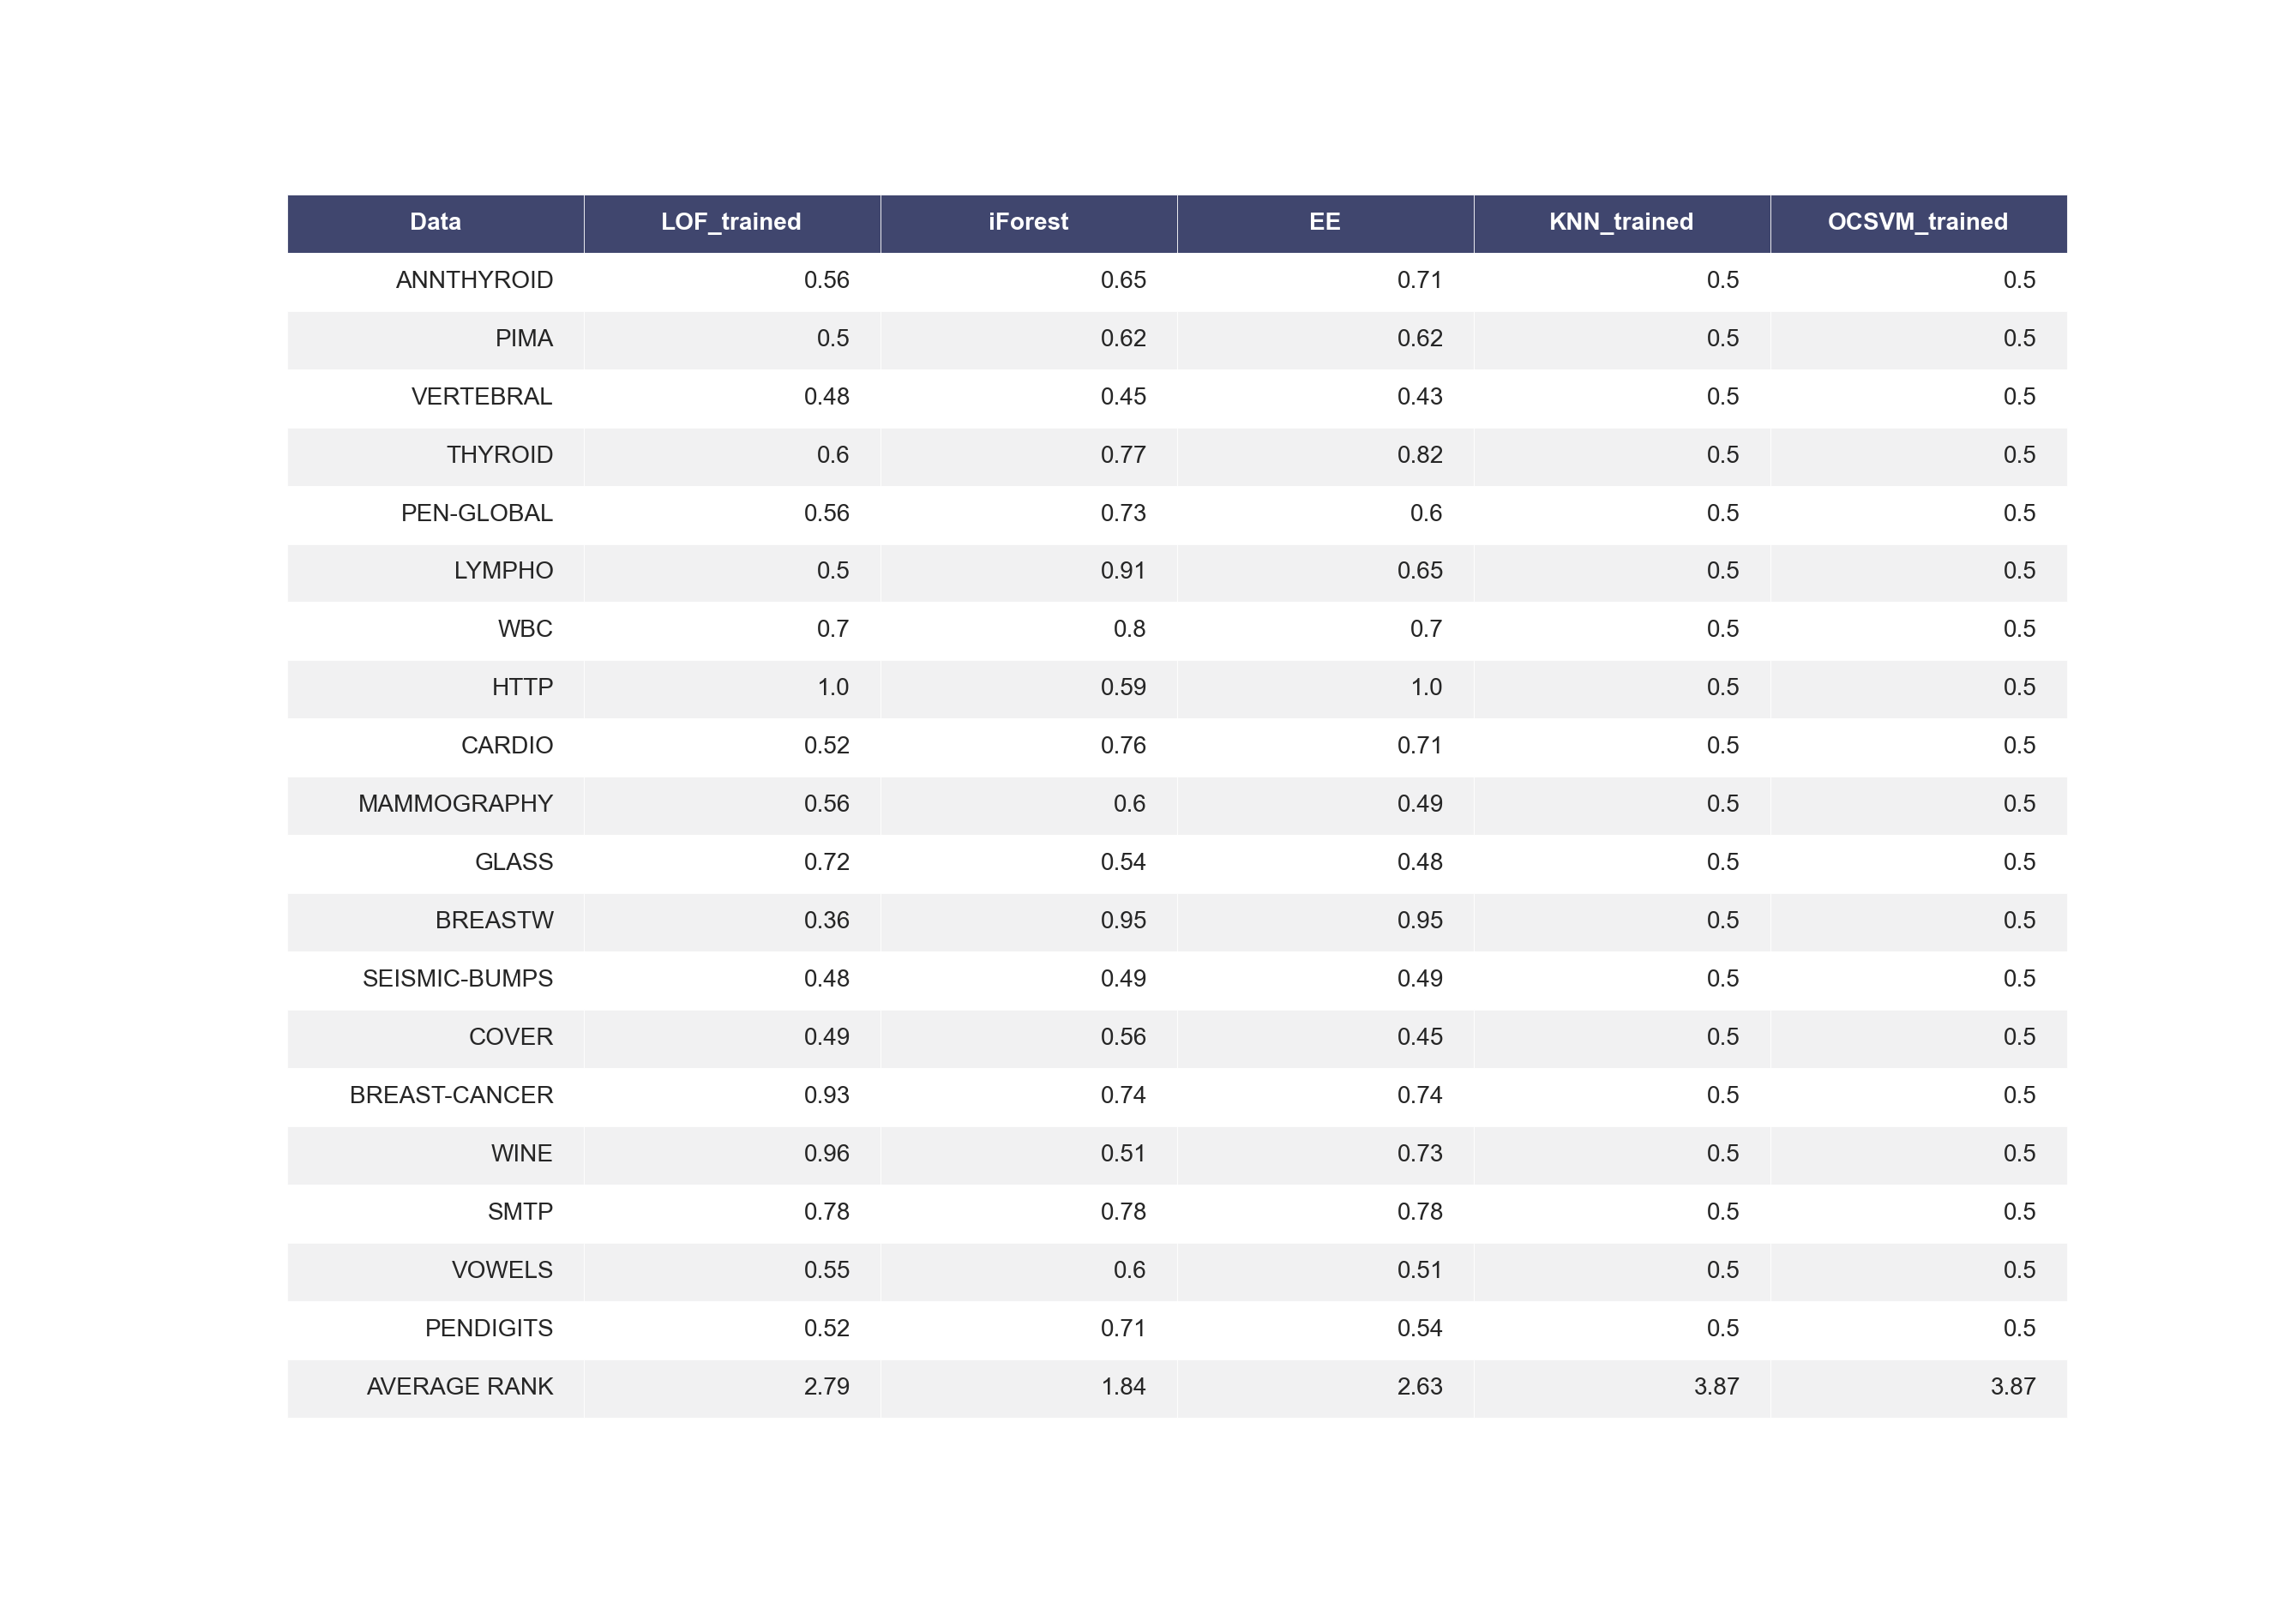

In [52]:
drop_datasets=[]

drop_cols=[ 'iForest (Score)', 'LOF_trained (60)', 'iForest (60)',
       'iForest (Score) (60)', 'EE (60)', 'KNN_trained (60)',
       'OCSVM_trained (60)']
df_trained_final,df_trained_r1=create_ranked_tables('auc',df_trained4,drop_datasets,
                                                    drop_cols,results_path_non_stream_ad,'trained')


In [76]:
df_merged4=df4.join(df_trained4.drop(['Data'],axis=1), lsuffix='', rsuffix='')

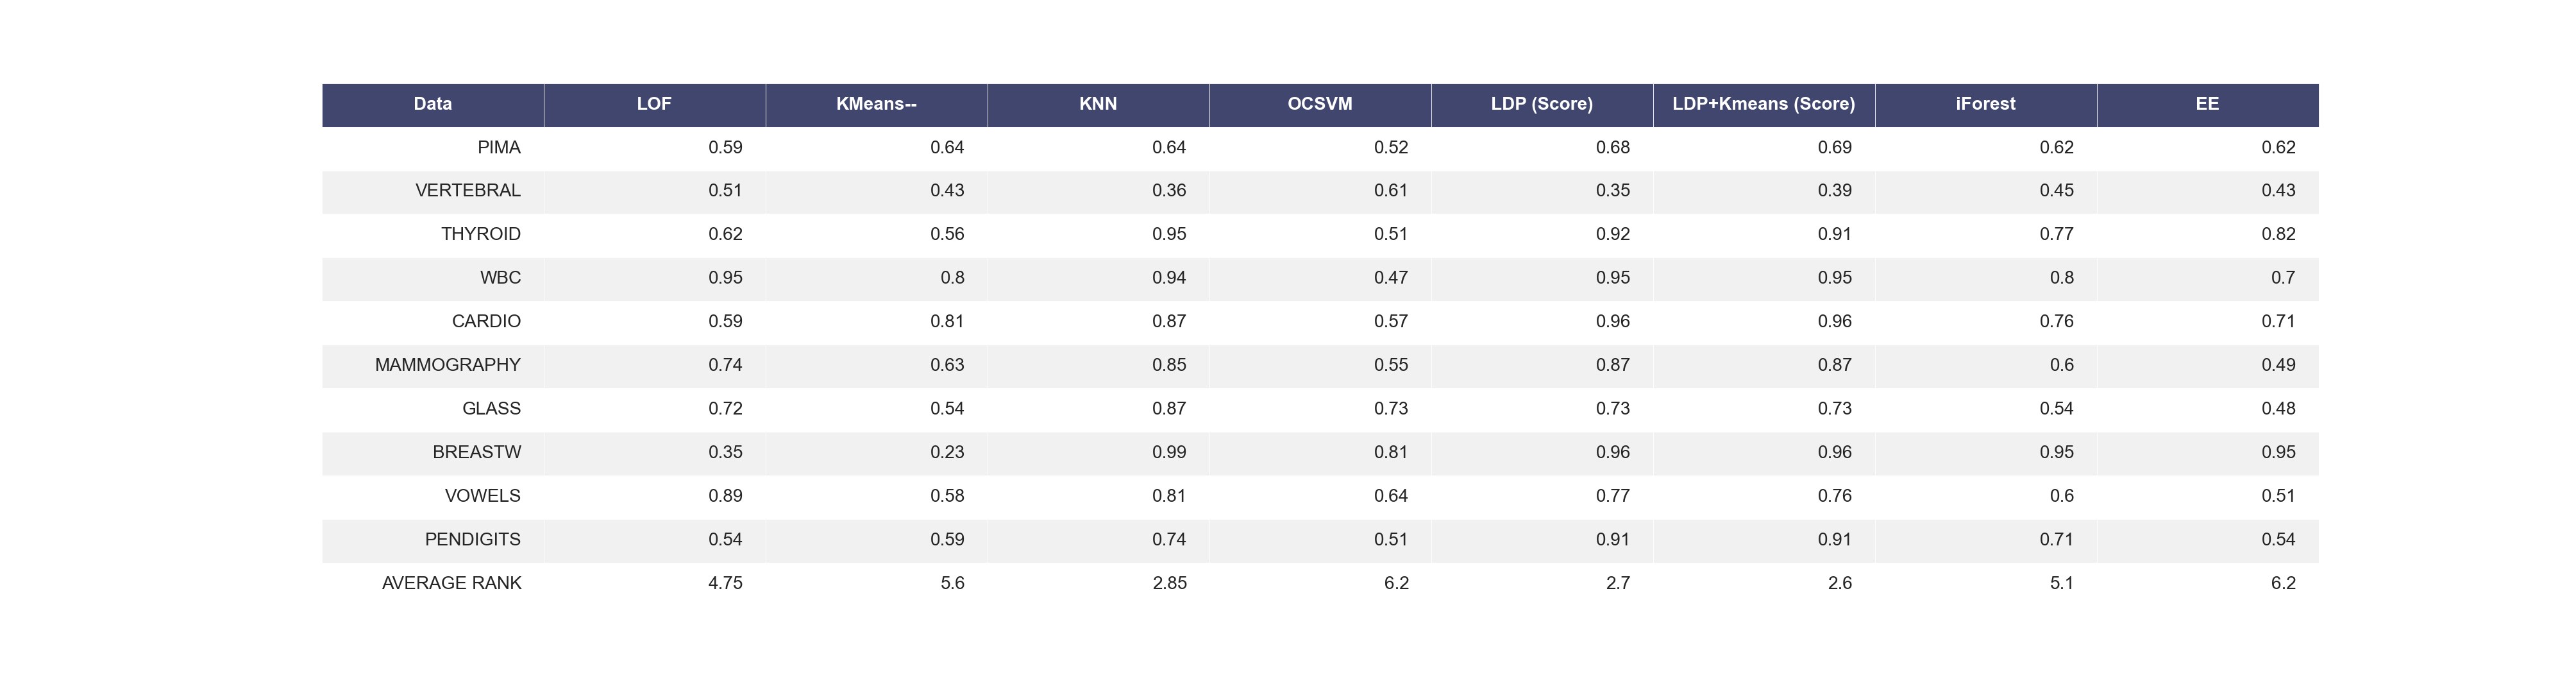

In [82]:
drop_datasets=[
    'http.pickle.pickle','cover.pickle.pickle','smtp.pickle.pickle','wine.mat.pickle', 
    'annthyroid.mat.pickle',
    'seismic-bumps.arff.pickle',
       'pen-global-unsupervised-ad.csv.pickle',
               'breast-cancer-unsupervised-ad.csv.pickle','wine.mat.pickle', 'lympho.mat.pickle',
#               'vowels.mat.pickle'
]

drop_cols=[ 'LDP','LDP (Group Anomalies)', 'LDP+Kmeans','LDP+Kmeans (Group Anomalies)',
           'iForest (Score)', 'LOF_trained (60)', 'iForest (60)',
       'iForest (Score) (60)', 'EE (60)', 'KNN_trained (60)',
       'OCSVM_trained (60)','KNN_trained', 'OCSVM_trained','LOF_trained']

df_merged4=df4.join(df_trained4.drop(['Data'],axis=1), lsuffix='', rsuffix='')

df_trained_final,df_trained_r1=create_ranked_tables('auc',df_merged4,drop_datasets,
                                                    drop_cols,results_path_non_stream_ad,'combined')


drop_datasets=[
    'http.pickle.pickle','cover.pickle.pickle','smtp.pickle.pickle','wine.mat.pickle', 
    'annthyroid.mat.pickle',
    'seismic-bumps.arff.pickle',
       'pen-global-unsupervised-ad.csv.pickle',
               'breast-cancer-unsupervised-ad.csv.pickle','wine.mat.pickle', 'lympho.mat.pickle',
#               'vowels.mat.pickle'
]

drop_cols=[ 'LDP','LDP (Group Anomalies)', 'LDP+Kmeans','LDP+Kmeans (Group Anomalies)',
           'iForest (Score)', 'LOF_trained (60)', 'iForest (60)',
       'iForest (Score) (60)', 'EE (60)', 'KNN_trained (60)',
       'OCSVM_trained (60)','KNN_trained', 'OCSVM_trained','LOF_trained']

df_merged5=df5.join(df_trained5.drop(['Data'],axis=1), lsuffix='', rsuffix='')

df_trained_final,df_trained_r1=create_ranked_tables('comp_time',df_merged5,drop_datasets,
                                                    drop_cols,results_path_non_stream_ad,'combined')





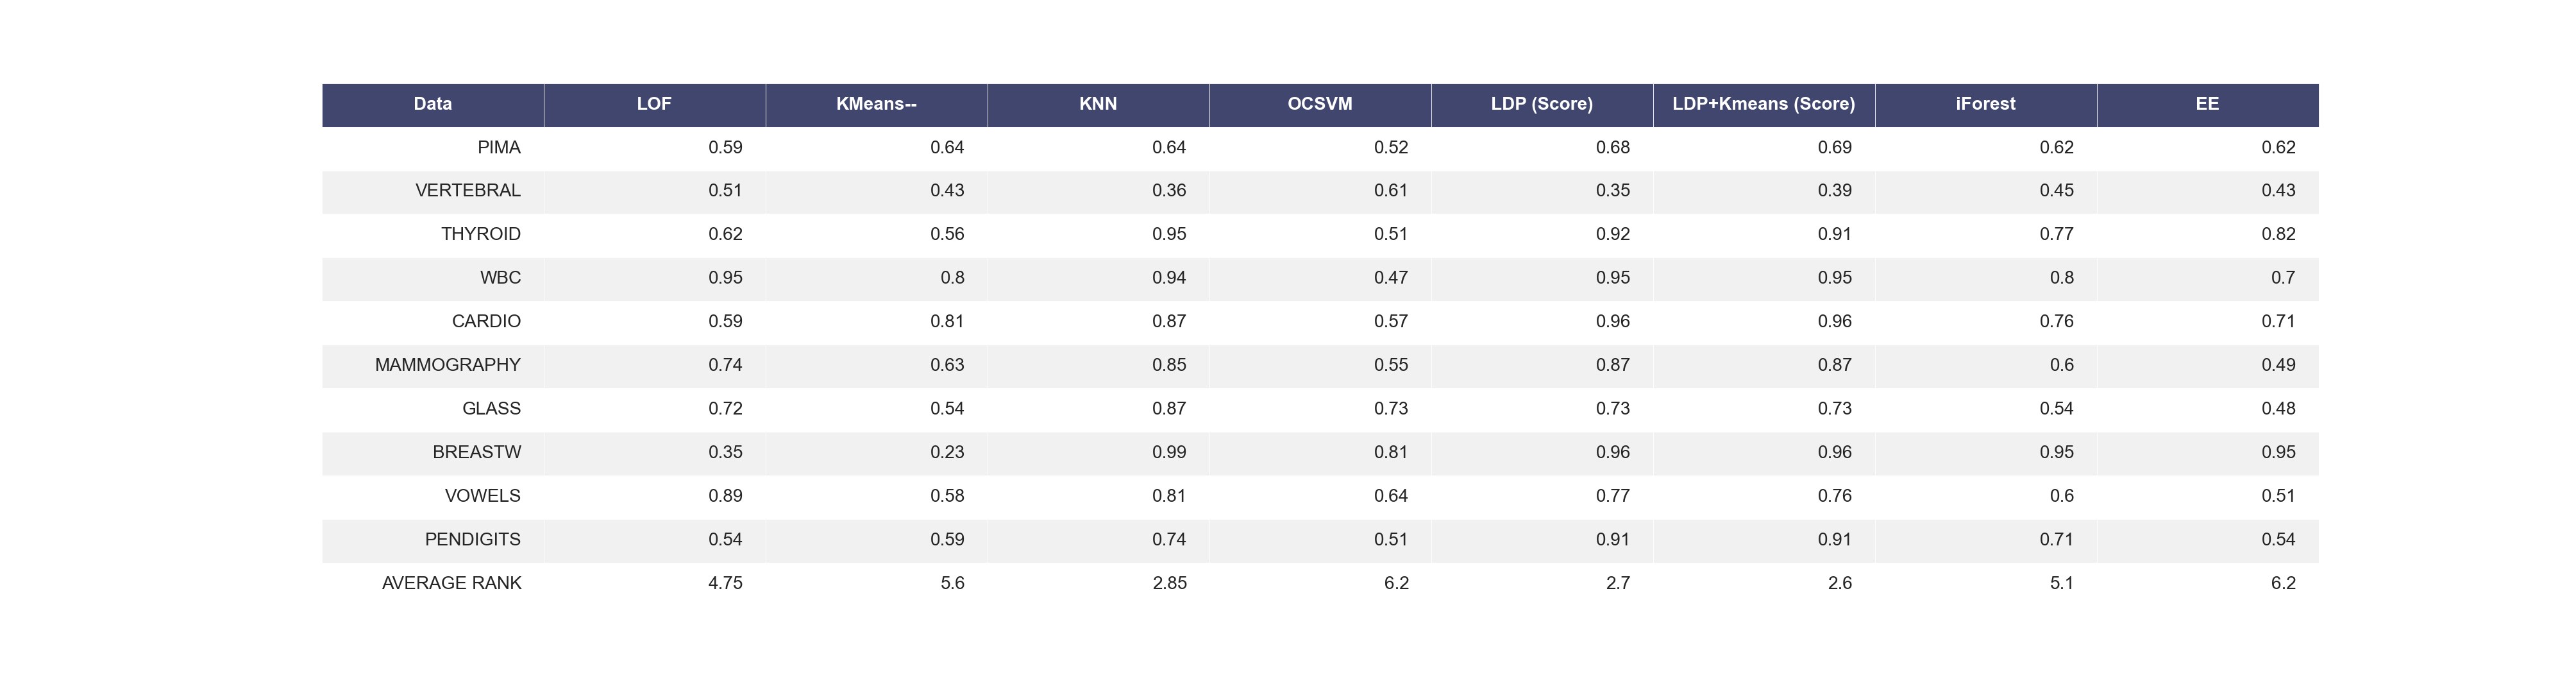

In [84]:
df_trained_final,df_trained_r1=create_ranked_tables('auc',df_merged4,drop_datasets,
                                                    drop_cols,results_path_non_stream_ad,'combined')

print_df=df_trained_final[['Data', 'LOF', 'KMeans--', 'KNN', 'OCSVM', 'iForest', 'EE', 'LDP (Score)',
       'LDP+Kmeans (Score)']]
cols=print_df.columns
data=print_df.index

for d in data:
    print_str=''
    for col in cols:
        print_str=print_str+str(print_df[col].loc[d])
        print_str=print_str+str(' & ')
    print_str=print_str+str(' \\\ ')
    print(print_str)

In [125]:
print_str=''
for col in cols:
    print_str=print_str+str( col )+' & '
print_str

In [126]:
print_str

'Data & LOF & KMeans-- & KNN & OCSVM & iForest & EE & LDP (Score) & LDP+Kmeans (Score) & '

###### Evaluation:AD Large

In [8]:
results_path=results_path_non_stream_ad_large

In [9]:
onlyfiles = [f for f in listdir(results_path) if isfile(join(results_path, f))]
extension = 'pickle'

In [10]:
result=[o for o in onlyfiles if ".pickle" in o]
result

['shuttle.mat.pickle',
 'ionosphere.mat.pickle',
 'birch-rg3.arff.pickle',
 'spambase.preproc.csv.pickle',
 'arrhythmia.arff.pickle',
 'satimage-2.mat.pickle',
 'shuttle-unsupervised-ad.csv.pickle',
 'satellite.mat.pickle',
 'kdd99-unsupervised-ad.csv.pickle',
 'arrhythmia.mat.pickle',
 'satimage.pickle.pickle',
 'optdigits.mat.pickle',
 'gas.preproc.csv.pickle',
 'letter-unsupervised-ad.csv.pickle',
 'mnist.raw.pickle.pickle',
 'letter.mat.pickle',
 'opt.digits.preproc.csv.pickle',
 'birch-rg2.arff.pickle',
 'shuttle.preproc.csv.pickle',
 'musk.mat.pickle',
 'http.mat.pickle',
 'mnist.mat.pickle',
 'birch-rg1.arff.pickle',
 'cover.mat.pickle',
 'skin.preproc.csv.pickle',
 'sonar.arff.pickle',
 'comm.and.crime.preproc.csv.pickle',
 'smtp.mat.pickle',
 'speech.mat.pickle']

In [11]:
perf_metrics=['tn','fp','fn','tp','fpr','tpr','thresholds','recall','specificity',
         'precision','accuracy','fmeasure','purity','auc','comp_time_secs']

models=['LOF','iForest', 'iForest (Score)','EE','oc-SVM','LDP','LDP (Score)','LDP (Group Anomalies)',
        'LDP+Kmeans','LDP+Kmeans (Score)','LDP+Kmeans (Group Anomalies)',
       ]

datasets=[]
anomalies_eval_perf_metrics = {}

for metric in perf_metrics:
    anomalies_eval_perf_metrics[metric]= pd.DataFrame( index=datasets,columns=models)


In [12]:
def eval_ldp(results_path_non_stream_ad_large,filename):
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    print(name)
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    
    try:
        y=ana_label(y)
    except:
        try:
            y=ana_label(y['class'])
        except:
            pass
        
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    
    I=(output['z'][0]<0)*1
    z=output['z'][0]
    N=len(I)
    prob=output['prob']

    I=((prob-np.min(prob))/(np.max(prob)-np.min(prob))>0.5)*1
    preds=I
    ldp_classify=perf_evaluate(X,y,preds)
    print("1")

    preds=np.zeros(len(I))
    preds[np.argsort(-prob)[0:int(sum(y))]]=1
    ldp_score=perf_evaluate(X,y,preds)
    fpr, tpr, thresholds = metrics.roc_curve(y, prob)
    auc=metrics.auc(fpr, tpr)
    ldp_score['auc']=auc    
    print("2")


    preds=np.copy(I)
    for k in np.unique(np.abs(z)):   
        ind_k=np.where(np.abs(z) == k)[0]
        if len(ind_k)/N<0.05:
            preds[ind_k]==1
#     preds=I
    ldp_classify_group_ana=perf_evaluate(X,y,preds)
    print("3")

    ldp_classify['comp_time_secs']=output['comp_time_secs']
    ldp_score['comp_time_secs']=output['comp_time_secs']
    ldp_classify_group_ana['comp_time_secs']=output['comp_time_secs']
    
    return ldp_classify,ldp_score,ldp_classify_group_ana

In [13]:
result[5:6]

['satimage-2.mat.pickle']

In [14]:
drop_datasets=[
    'spambase.preproc.csv.pickle', 'opt.digits.preproc.csv.pickle','comm.and.crime.preproc.csv.pickle',
    'shuttle-unsupervised-ad.csv.pickle','letter-unsupervised-ad.csv.pickle',
    'shuttle.preproc.csv.pickle',
    'skin.preproc.csv.pickle','satimage.pickle.pickle',
    'gas.preproc.csv.pickle','ionosphere.mat.pickle', 'mnist.raw.pickle.pickle','birch-rg3.arff.pickle',
    'kdd99-unsupervised-ad.csv.pickle','birch-rg2.arff.pickle','birch-rg1.arff.pickle','sonar.arff.pickle',
    'arrhythmia.arff.pickle',
]

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

max_size=20000
for filename in result:
    name=filename.replace(results_path_non_stream_ad_large,'')
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    
    try:
        y=ana_label(y)
    except:
        try:
            y=ana_label(y['class'])
        except:
            pass
        
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
#     try:
    if name not in drop_datasets:

        ldp_classify,ldp_score,ldp_classify_group_ana=eval_ldp(results_path_non_stream_ad_large,filename)

        ldp_classify_clust,ldp_score_clust,ldp_classify_group_ana_clust=eval_ldp(
            results_path_non_stream_clust_large,filename)



        start=time.time()
        lof = LocalOutlierFactor()
        preds = lof.fit_predict(X)
        end=time.time()
        preds=(preds<0)*1
        lof_classify=perf_evaluate(X,y,preds)
        lof_classify['comp_time_secs']=end-start


        start=time.time()
        model=IsolationForest(contamination=float(0.1))
        model.fit(X)
        preds=model.predict(X)
        end=time.time()
        preds=(preds<0)*1
        iforest_classify=perf_evaluate(X,y,preds)
        iforest_classify['comp_time_secs']=end-start


        scores=model.decision_function(X)
        iforest_score=perf_evaluate(X,y,preds)
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        auc=metrics.auc(fpr, tpr)
        iforest_score['auc']=auc
        iforest_score['comp_time_secs']=end-start


        start=time.time()
        ee = EllipticEnvelope(contamination=0.1)
        preds = ee.fit_predict(X)
        end=time.time()
        preds=(preds<0)*1
        ee_classify=perf_evaluate(X,y,preds)
        ee_classify['comp_time_secs']=end-start
        
        if X.shape[1]<10000:

            nu = float(np.mean(y))
            cfof_classify={}
            for gmma in np.arange(0.1,1,0.2):
                cfof_classify[gmma]={}
                start=time.time()

                oc = ocsvm(nu=nu,gamma=gmma)
                oc.fit(X)
                p = oc.predict(X)
                preds = np.zeros(p.shape)
                end=time.time()

                preds[p == -1] = 1
                preds[p == 1] = 0

                cfof_classify[gmma]=perf_evaluate(X,y,preds)
                cfof_classify[gmma]['comp_time_secs']=end-start

            pp=[]
            for key in [*cfof_classify.keys()]:
                pp.append(cfof_classify[key]['auc'])
            max_key=[*cfof_classify.keys()][np.argmax(pp)]
            ocsvm_classify=cfof_classify[max_key]

        for metric in perf_metrics:
            pd_row=[]
            pd_row.append(lof_classify[metric])
            pd_row.append(iforest_classify[metric])
            pd_row.append(iforest_score[metric])
            pd_row.append(ee_classify[metric])
            if X.shape[1]<10000:
                pd_row.append(ocsvm_classify[metric])
            else:
                pd_row.append(np.nan)
            

            pd_row.append(ldp_classify[metric])
            pd_row.append(ldp_score[metric])
            pd_row.append(ldp_classify_group_ana[metric])   

            pd_row.append(ldp_classify_clust[metric])
            pd_row.append(ldp_score_clust[metric])
            pd_row.append(ldp_classify_group_ana_clust[metric])   


            anomalies_eval_perf_metrics[metric].loc[filename]=pd_row
#     except:
#         pass

shuttle.mat.pickle
1
2
3
shuttle.mat.pickle
1
2
3
satimage-2.mat.pickle
1
2
3
satimage-2.mat.pickle
1
2
3
satellite.mat.pickle
1
2
3
satellite.mat.pickle
1
2
3
arrhythmia.mat.pickle
1
2
3
arrhythmia.mat.pickle
1
2
3
optdigits.mat.pickle
1
2
3
optdigits.mat.pickle
1
2
3
letter.mat.pickle
1
2
3
letter.mat.pickle
1
2
3
musk.mat.pickle
1
2
3
musk.mat.pickle
1
2
3
http.mat.pickle
1
2
3
http.mat.pickle
1
2
3


In [ ]:
anomalies_eval_perf_metrics['auc']

In [ ]:
file_path=results_path_non_stream_ad_large+'Performance/'
if not os.path.exists(file_path):
    os.makedirs(file_path)

pickle.dump( anomalies_eval_perf_metrics, open( file_path+"ad_performance_ocsv_included.pickle", "wb" ) )


###### Addironal results on large

In [8]:
file_path=results_path_non_stream_ad_large+'Performance/'

anomalies_eval_perf_metrics=pickle.load(open( file_path+"ad_performance.pickle", "rb") )


In [12]:
import six
def create_ranked_tables(m1,df4,drop_datasets,drop_cols,results_path_non_stream_ad_large,suffix):
    
    df_final=df4.drop(drop_cols,axis=1)

    df_t=df4.drop(['Data'],axis=1).T
    df_t=df_t.drop(drop_cols,axis=0)

    df_r1=pd.DataFrame( columns=df4.index,index=df4.columns[1:])
    df_r1=df_r1.drop(drop_cols,axis=0)

    for data_set in df4.index:
        df_r1[data_set]=df_t[data_set].rank(ascending=False)
    

    df_r1=df_r1.drop(drop_datasets,axis=1)    

    df_final=df_final.drop(drop_datasets,axis=0)    

    df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
    df_final["Data"]['Avg Rank']='AVERAGE RANK'


    render_mpl_table(df_final, header_columns=0, col_width=2.0)
    plt.savefig(results_path_non_stream_ad_large+"/images/AD_dataframe_all_ranked_by_"+m1+'_'+suffix+".png")
    return df_final,df_r1

In [13]:
#Output format: m1 (m2,m3)
m1='fmeasure'
m2='recall'
m3='precision'

df = anomalies_eval_perf_metrics[m1].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df=df.drop(['LDP (Group Anomalies)'], axis=1)
df1=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m1+".png")

df = anomalies_eval_perf_metrics[m2].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df=df.drop(['LDP (Group Anomalies)'], axis=1)
df2=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m2+".png")

df = anomalies_eval_perf_metrics[m3].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df=df.drop(['LDP (Group Anomalies)'], axis=1)
df3=df.fillna(0)
# render_mpl_table(df, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m3+".png")

m4='auc'
df = anomalies_eval_perf_metrics[m4].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df=df.drop(['LDP (Group Anomalies)'], axis=1)
df4=df.fillna(0)
# render_mpl_table(df4, header_columns=0, col_width=2.0)
# plt.savefig(results_path_non_stream_ad+"/images/AD_dataframe_"+m4+".png")

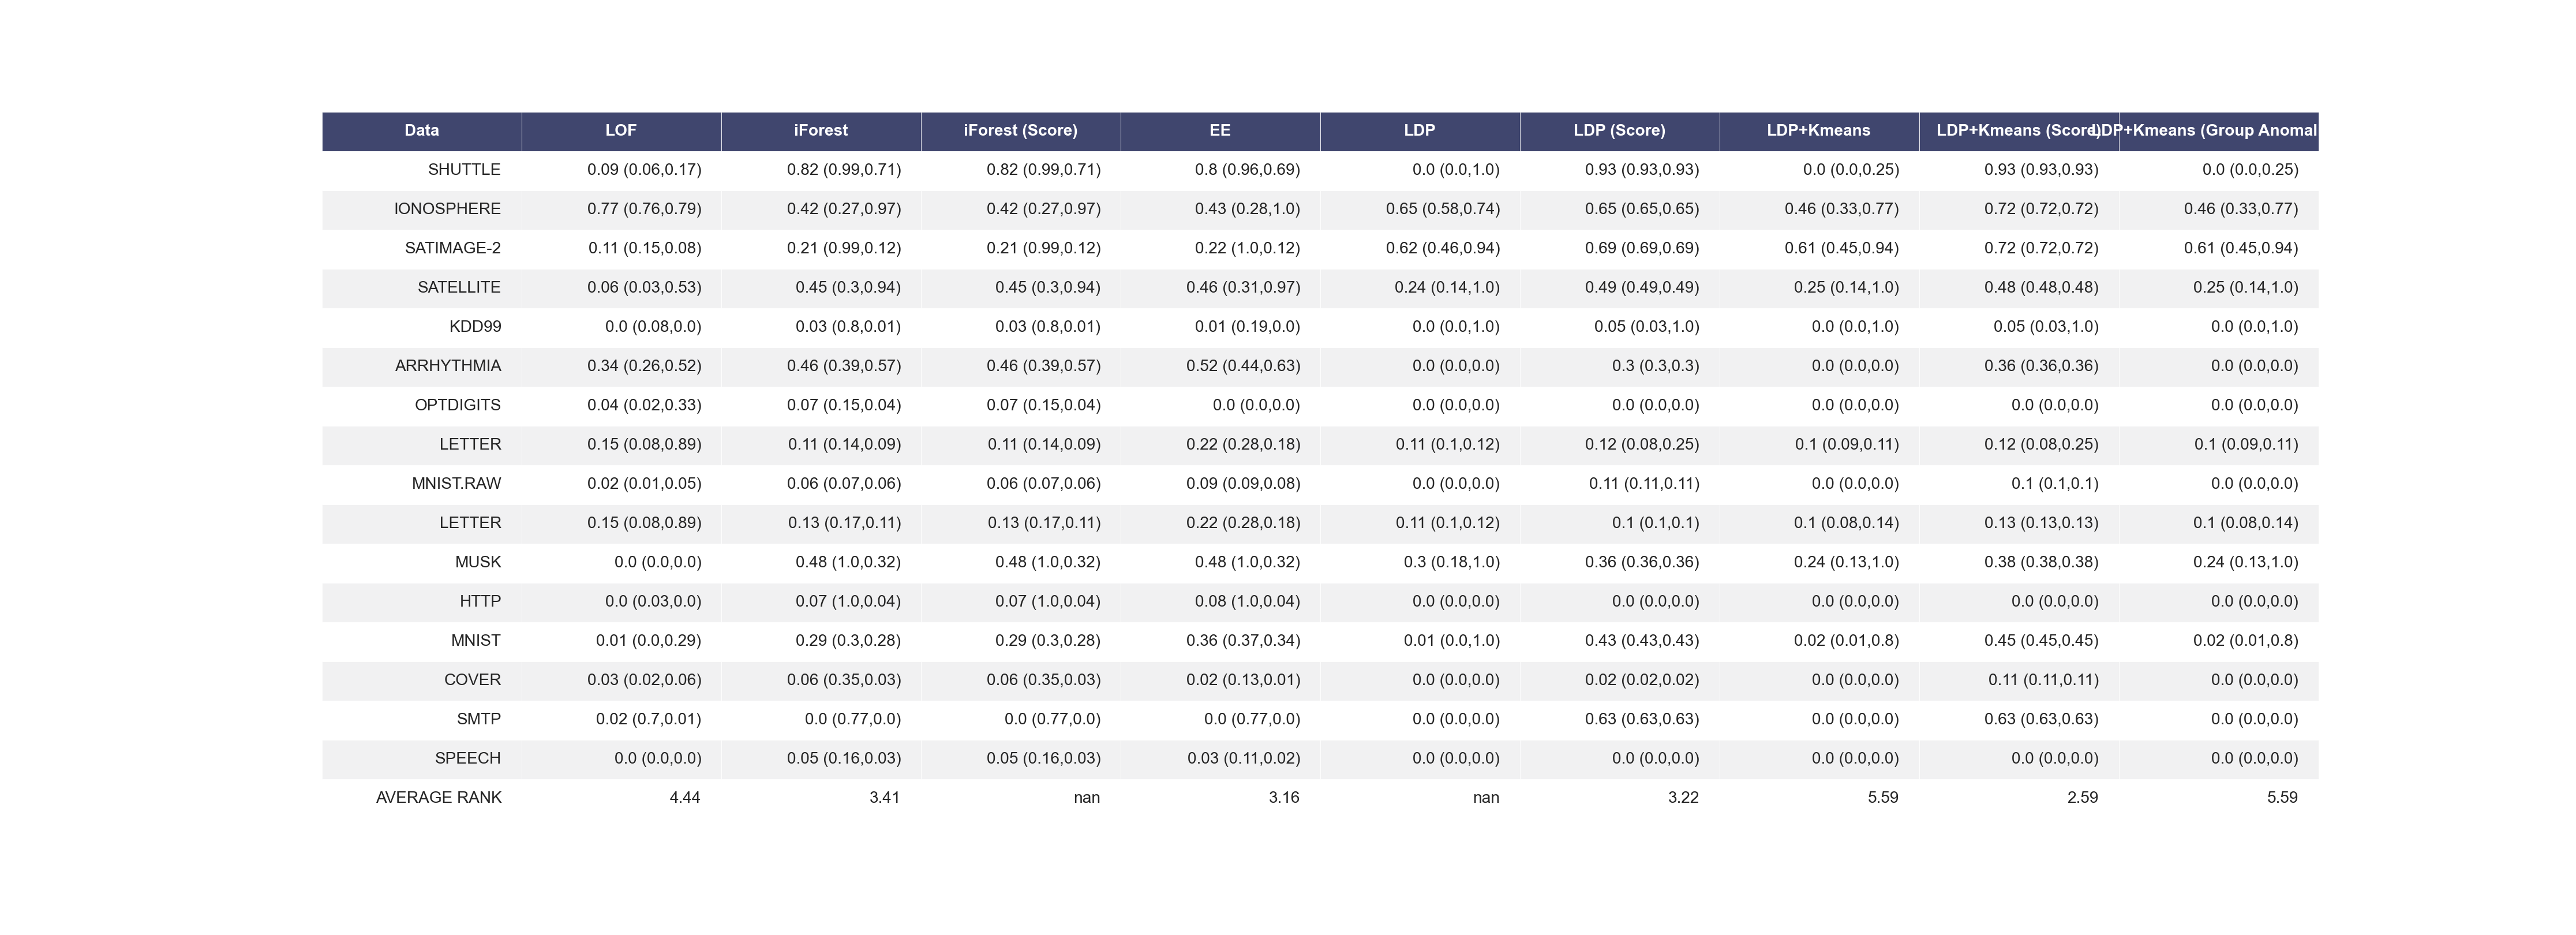

In [14]:
drop_datasets=[
    'spambase.preproc.csv.pickle', 'opt.digits.preproc.csv.pickle','comm.and.crime.preproc.csv.pickle',
    'shuttle-unsupervised-ad.csv.pickle',
    'shuttle.preproc.csv.pickle',
    'skin.preproc.csv.pickle','satimage.pickle.pickle',
    'gas.preproc.csv.pickle',
#     'speech.mat.pickle',
#     'arrhythmia.mat.pickle',
#     'optdigits.mat.pickle'

]

m1='auc'
drop_cols=['LDP','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
#           'LDP+Kmeans (Score)'
          ]

# create_ranked_tables(m1,df4,drop_datasets,drop_cols,results_path_non_stream_ad_large)

m4='comp_time_secs'
df = anomalies_eval_perf_metrics[m4].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df=df.drop(['LDP (Group Anomalies)'], axis=1)
df5=df.fillna(0)
# create_ranked_tables('comp_time_secs',df5,drop_datasets,drop_cols,results_path_non_stream_ad_large)

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col

df_final=pd.DataFrame( index=df1.index,columns=df1.columns[1:])
for data_set in df1.index:
    pd_col=[]
    for m in df1.columns[1:]:
        pd_col.append(str(df1[m][data_set])+' ('+str(df2[m][data_set])+','+str(df3[m][data_set])+')')
    df_final.loc[data_set]=pd_col
    
df_final.insert(0,"Data", df1["Data"])
# df_final=df_final.drop(['iForest (Score)','LDP'],axis=1)


#Metric used for ranking : 1:fmeasure, 2:recall, 3:precision, 4:auc

df_t=df1.drop(['Data','iForest (Score)','LDP'],axis=1).T

df_r1=pd.DataFrame( columns=df1.index,index=df1.columns[1:])

for data_set in df1.index:
    df_r1[data_set]=df_t[data_set].rank(ascending=False)
    
df_r1=df_r1.drop(drop_datasets,axis=1)    

df_final=df_final.drop(drop_datasets,axis=0)    

df_final.loc['Avg Rank']=(df_r1.T.mean().round(2))
df_final["Data"]['Avg Rank']='AVERAGE RANK'


render_mpl_table(df_final, header_columns=0, col_width=2.0)
plt.savefig(results_path_non_stream_ad_large+"/images/AD_dataframe_all_ranked_by_"+m1+".png")


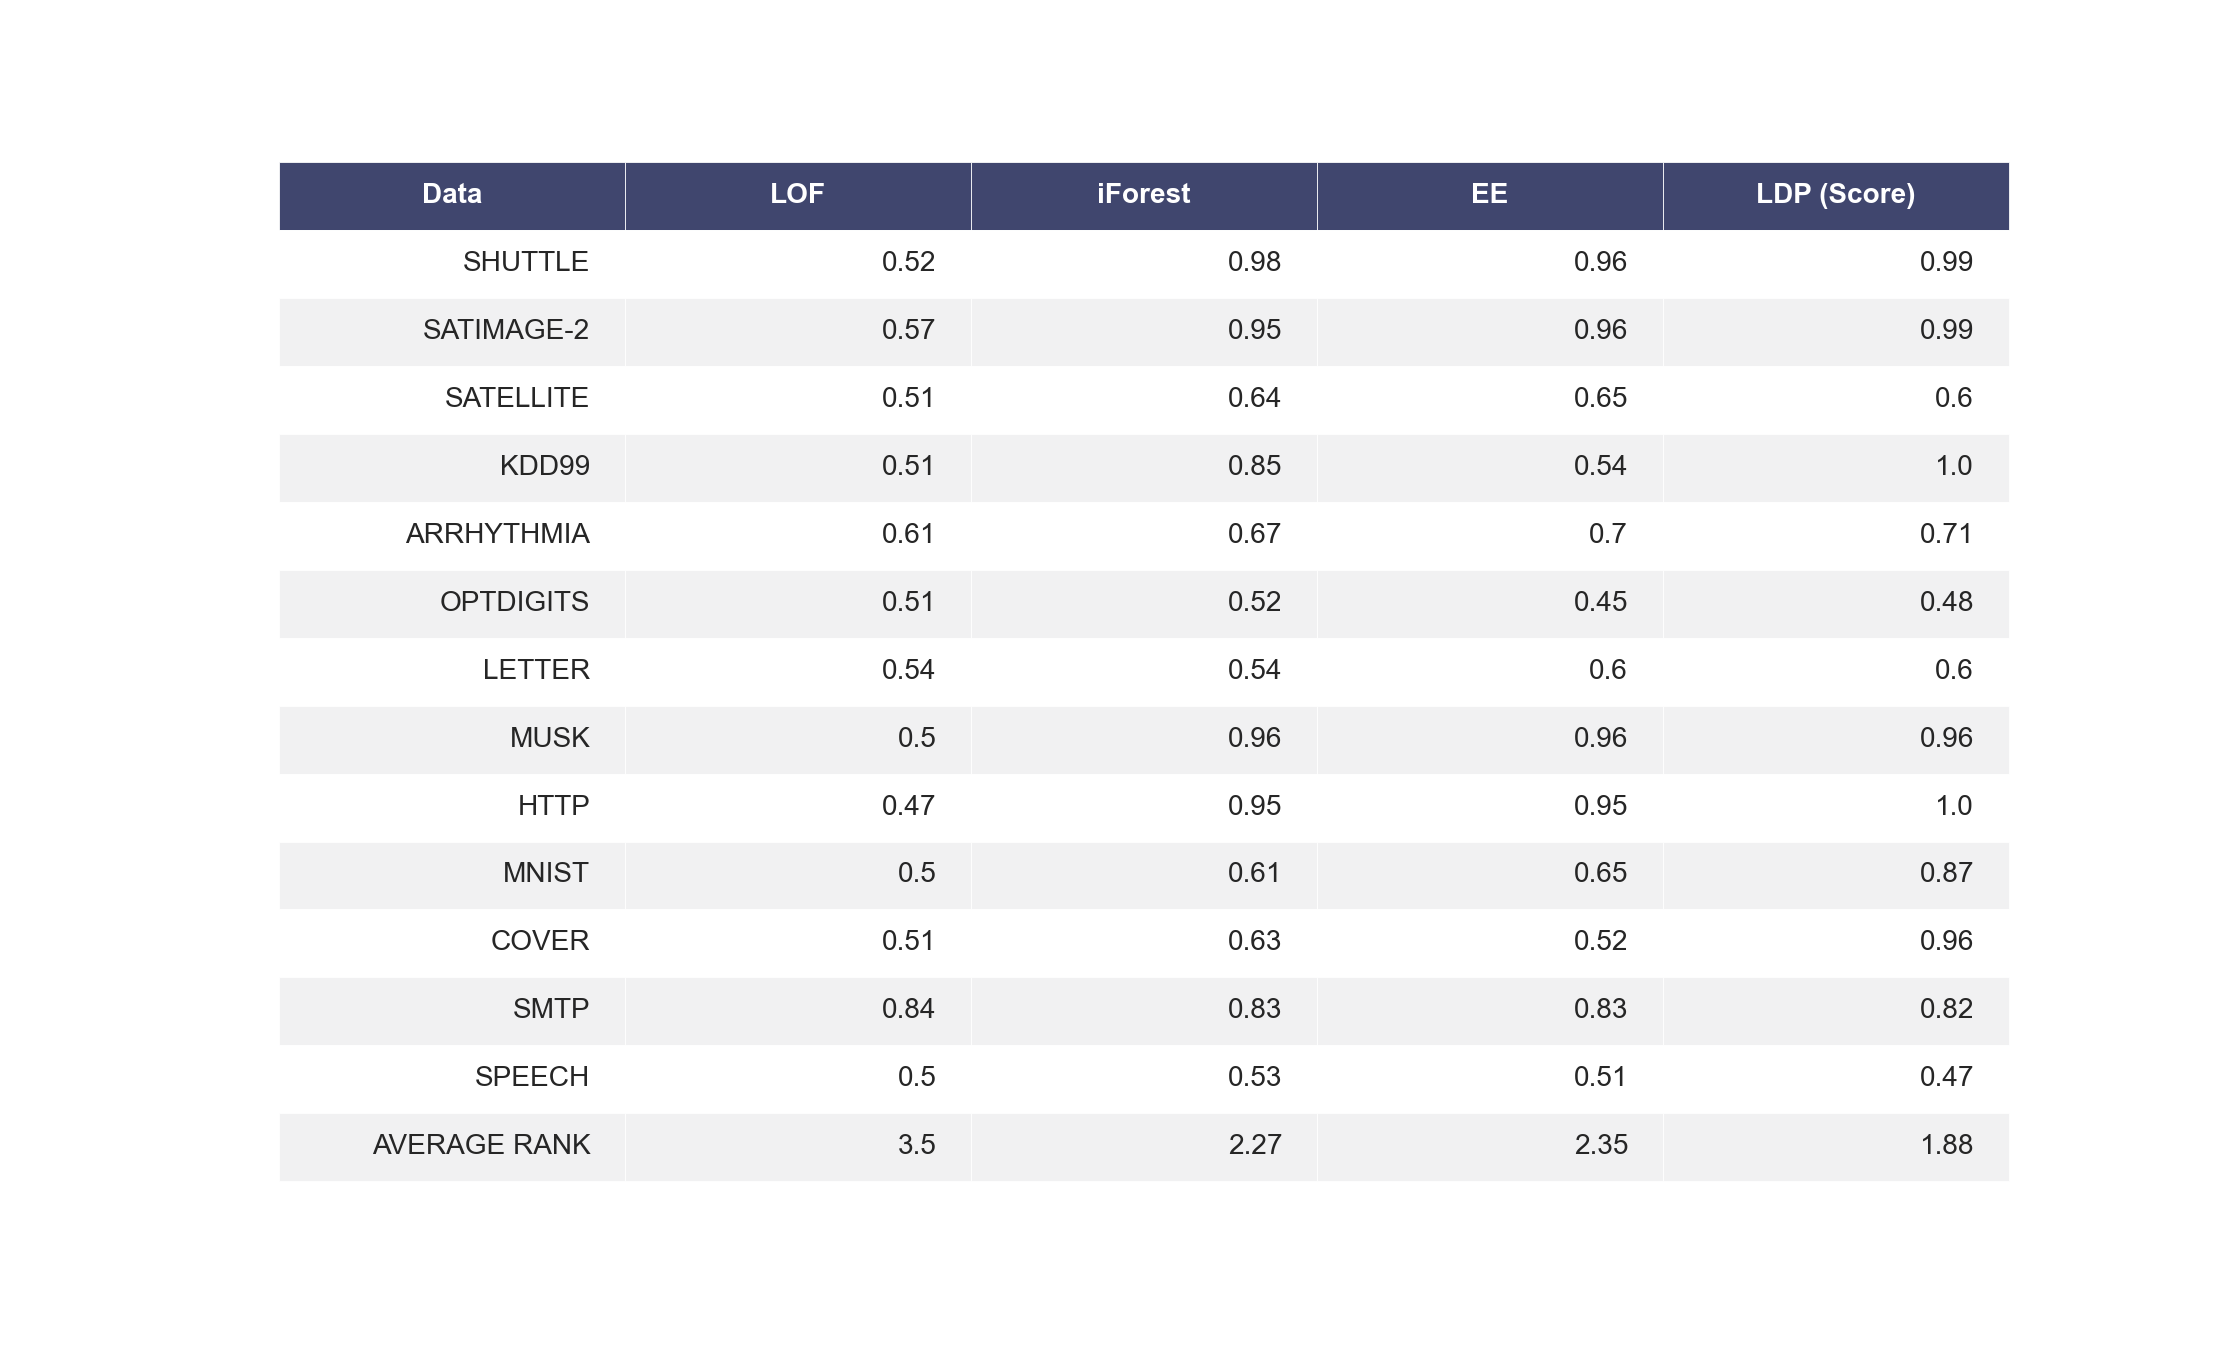

In [15]:
drop_datasets=[
    'spambase.preproc.csv.pickle', 'opt.digits.preproc.csv.pickle','comm.and.crime.preproc.csv.pickle',
    'shuttle-unsupervised-ad.csv.pickle','letter-unsupervised-ad.csv.pickle',
    'shuttle.preproc.csv.pickle',
    'skin.preproc.csv.pickle','satimage.pickle.pickle',
    'gas.preproc.csv.pickle','ionosphere.mat.pickle', 'mnist.raw.pickle.pickle'
#     'speech.mat.pickle',
#     'arrhythmia.mat.pickle',
#     'optdigits.mat.pickle'

]

m1='auc'
drop_cols=['LDP','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
          'LDP+Kmeans (Score)'
          ]


df_final,df_r1=create_ranked_tables(m1,df4,drop_datasets,drop_cols,results_path_non_stream_ad_large,'large')

In [16]:
df_final

Data   LOF  iForest    EE  \
shuttle.mat.pickle                     SHUTTLE  0.52     0.98  0.96   
satimage-2.mat.pickle               SATIMAGE-2  0.57     0.95  0.96   
satellite.mat.pickle                 SATELLITE  0.51     0.64  0.65   
kdd99-unsupervised-ad.csv.pickle         KDD99  0.51     0.85  0.54   
arrhythmia.mat.pickle               ARRHYTHMIA  0.61     0.67  0.70   
optdigits.mat.pickle                 OPTDIGITS  0.51     0.52  0.45   
letter.mat.pickle                       LETTER  0.54     0.54  0.60   
musk.mat.pickle                           MUSK  0.50     0.96  0.96   
http.mat.pickle                           HTTP  0.47     0.95  0.95   
mnist.mat.pickle                         MNIST  0.50     0.61  0.65   
cover.mat.pickle                         COVER  0.51     0.63  0.52   
smtp.mat.pickle                           SMTP  0.84     0.83  0.83   
speech.mat.pickle                       SPEECH  0.50     0.53  0.51   
Avg Rank                          AVERAGE RANK  3.50     2.27  2.35   

                                  LDP (Score)  
shuttle.mat.pickle                       0.99  
satimage-2.mat.pickle                    0.99  
satellite.mat.pickle                     0.60  
kdd99-unsupervised-ad.csv.pickle         1.00  
arrhythmia.mat.pickle                    0.71  
optdigits.mat.pickle                     0.48  
letter.mat.pickle                        0.60  
musk.mat.pickle                          0.96  
http.mat.pickle                          1.00  
mnist.mat.pickle                         0.87  
cover.mat.pickle                         0.96  
smtp.mat.pickle                          0.82  
speech.mat.pickle                        0.47  
Avg Rank                                 1.88

In [17]:
print_df=df_final
cols=print_df.columns
data=print_df.index

for d in data:
    print_str=''
    for col in cols:
        print_str=print_str+str(print_df[col].loc[d])
        print_str=print_str+str(' & ')
    print_str=print_str+str(' \\\ ')
    print(print_str)

SHUTTLE & 0.52 & 0.98 & 0.96 & 0.99 &  \\ 
SATIMAGE-2 & 0.57 & 0.95 & 0.96 & 0.99 &  \\ 
SATELLITE & 0.51 & 0.64 & 0.65 & 0.6 &  \\ 
KDD99 & 0.51 & 0.85 & 0.54 & 1.0 &  \\ 
ARRHYTHMIA & 0.61 & 0.67 & 0.7 & 0.71 &  \\ 
OPTDIGITS & 0.51 & 0.52 & 0.45 & 0.48 &  \\ 
LETTER & 0.54 & 0.54 & 0.6 & 0.6 &  \\ 
MUSK & 0.5 & 0.96 & 0.96 & 0.96 &  \\ 
HTTP & 0.47 & 0.95 & 0.95 & 1.0 &  \\ 
MNIST & 0.5 & 0.61 & 0.65 & 0.87 &  \\ 
COVER & 0.51 & 0.63 & 0.52 & 0.96 &  \\ 
SMTP & 0.84 & 0.83 & 0.83 & 0.82 &  \\ 
SPEECH & 0.5 & 0.53 & 0.51 & 0.47 &  \\ 
AVERAGE RANK & 3.5 & 2.27 & 2.35 & 1.88 &  \\ 


In [18]:
print_str=''
for col in cols:
    print_str=print_str+str( col )+' & '
print_str

'Data & LOF & iForest & EE & LDP (Score) & '

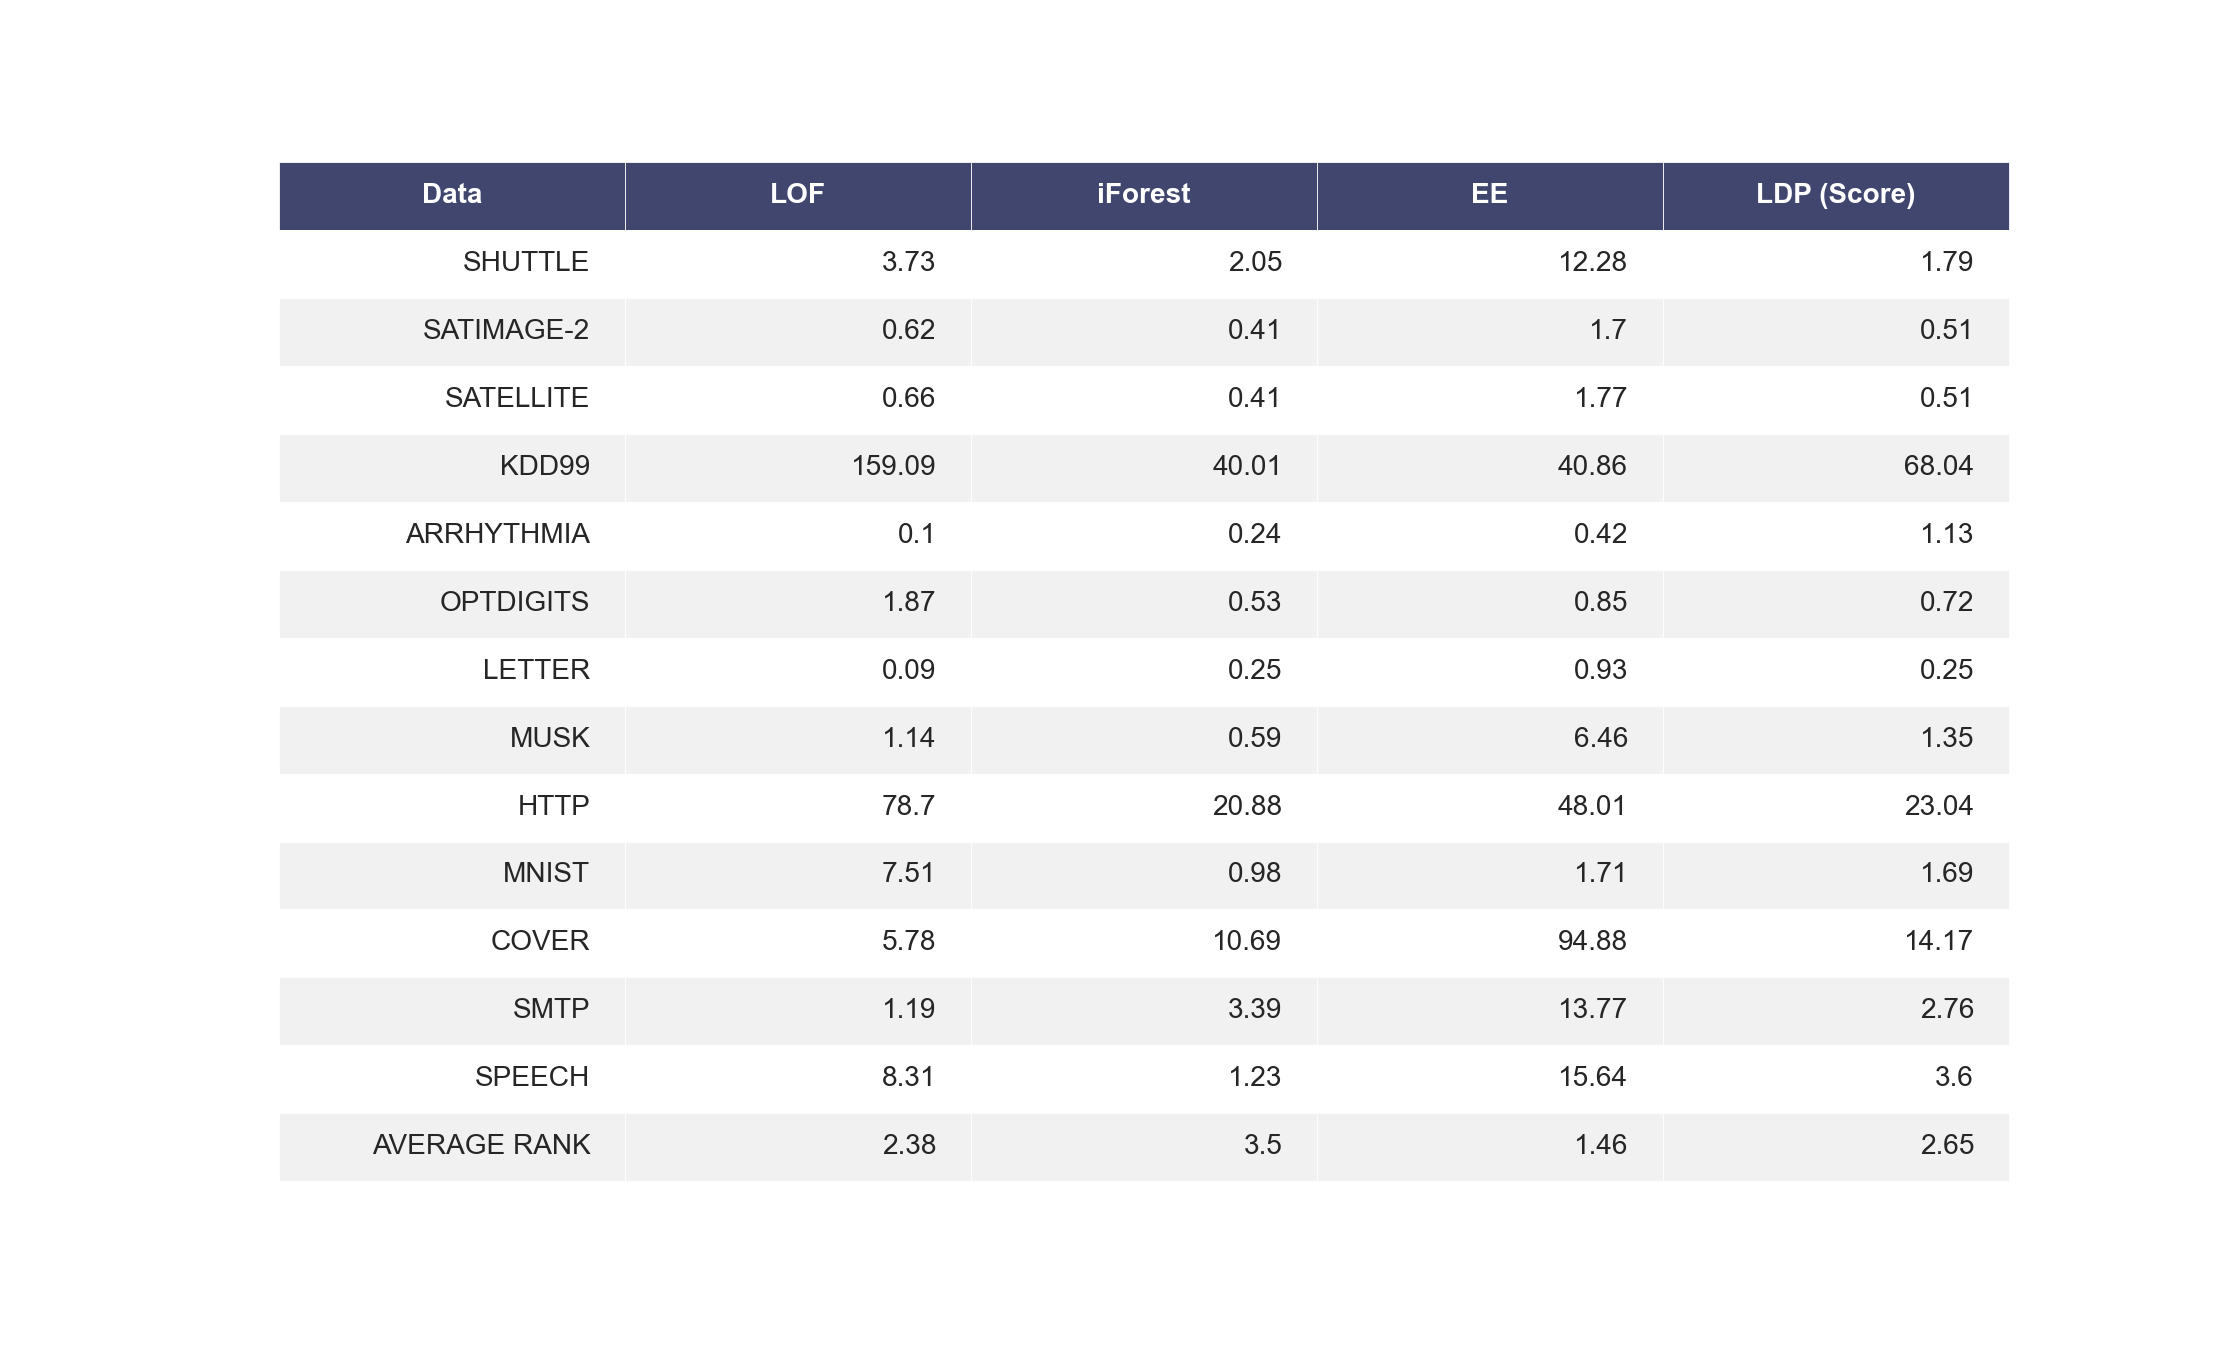

In [19]:
df = anomalies_eval_perf_metrics['comp_time_secs'].round(2)
df.insert(0,"Data",[d.replace('.csv','').replace('.pickle','').replace('.arff','').replace('.mat','').replace(is_date(d, fuzzy=True),"").replace('-unsupervised-ad','').upper() for d in df.index])
df=df.drop(['LDP (Group Anomalies)'], axis=1)
df5=df.fillna(0)

drop_datasets=[
    'spambase.preproc.csv.pickle', 'opt.digits.preproc.csv.pickle','comm.and.crime.preproc.csv.pickle',
    'shuttle-unsupervised-ad.csv.pickle','letter-unsupervised-ad.csv.pickle',
    'shuttle.preproc.csv.pickle',
    'skin.preproc.csv.pickle','satimage.pickle.pickle',
    'gas.preproc.csv.pickle','ionosphere.mat.pickle', 'mnist.raw.pickle.pickle'
]

m1='comp_time'
drop_cols=['LDP','iForest (Score)', 'LDP+Kmeans', 'LDP+Kmeans (Group Anomalies)', 
          'LDP+Kmeans (Score)'
          ]


df_final,df_r1=create_ranked_tables(m1,df5,drop_datasets,drop_cols,
                                    results_path_non_stream_ad_large,'large')

In [20]:
results_path=results_path_non_stream_ad_large
onlyfiles = [f for f in listdir(results_path) if isfile(join(results_path, f))]
extension = 'pickle'
result=[o for o in onlyfiles if ".pickle" in o and o not in 'cfof_results.pickle']
# result

In [21]:
df_final['N']=np.zeros(df_final.shape[0])
df_final['D']=np.zeros(df_final.shape[0])
df_final['N*D']=np.zeros(df_final.shape[0])
for filename in result:
    name=filename.replace(results_path_non_stream_ad_large,'')
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    if filename in df_final.index:
        df_final['N'].loc[filename]=X.shape[0]
        df_final['D'].loc[filename]=X.shape[1]
        df_final['N*D'].loc[filename]=X.shape[1]*X.shape[0]




In [22]:
df_final=df_final.sort_values(by='N').drop(['Avg Rank'],axis=0)
df_final

Data     LOF  iForest     EE  \
arrhythmia.mat.pickle             ARRHYTHMIA    0.10     0.24   0.42   
letter.mat.pickle                     LETTER    0.09     0.25   0.93   
musk.mat.pickle                         MUSK    1.14     0.59   6.46   
speech.mat.pickle                     SPEECH    8.31     1.23  15.64   
optdigits.mat.pickle               OPTDIGITS    1.87     0.53   0.85   
satimage-2.mat.pickle             SATIMAGE-2    0.62     0.41   1.70   
satellite.mat.pickle               SATELLITE    0.66     0.41   1.77   
mnist.mat.pickle                       MNIST    7.51     0.98   1.71   
shuttle.mat.pickle                   SHUTTLE    3.73     2.05  12.28   
smtp.mat.pickle                         SMTP    1.19     3.39  13.77   
cover.mat.pickle                       COVER    5.78    10.69  94.88   
http.mat.pickle                         HTTP   78.70    20.88  48.01   
kdd99-unsupervised-ad.csv.pickle       KDD99  159.09    40.01  40.86   

                                  LDP (Score)         N      D         N*D  
arrhythmia.mat.pickle                    1.13     452.0  274.0    123848.0  
letter.mat.pickle                        0.25    1600.0   32.0     51200.0  
musk.mat.pickle                          1.35    3062.0  166.0    508292.0  
speech.mat.pickle                        3.60    3686.0  400.0   1474400.0  
optdigits.mat.pickle                     0.72    5216.0   64.0    333824.0  
satimage-2.mat.pickle                    0.51    5803.0   36.0    208908.0  
satellite.mat.pickle                     0.51    6435.0   36.0    231660.0  
mnist.mat.pickle                         1.69    7603.0  100.0    760300.0  
shuttle.mat.pickle                       1.79   49097.0    9.0    441873.0  
smtp.mat.pickle                          2.76   95156.0    3.0    285468.0  
cover.mat.pickle                        14.17  286048.0   10.0   2860480.0  
http.mat.pickle                         23.04  567498.0    3.0   1702494.0  
kdd99-unsupervised-ad.csv.pickle        68.04  620098.0   29.0  17982842.0

In [23]:
cols=df_final.drop(['Data','N', 'D','N*D'],axis=1).columns
cols

Index(['LOF', 'iForest', 'EE', 'LDP (Score)'], dtype='object')

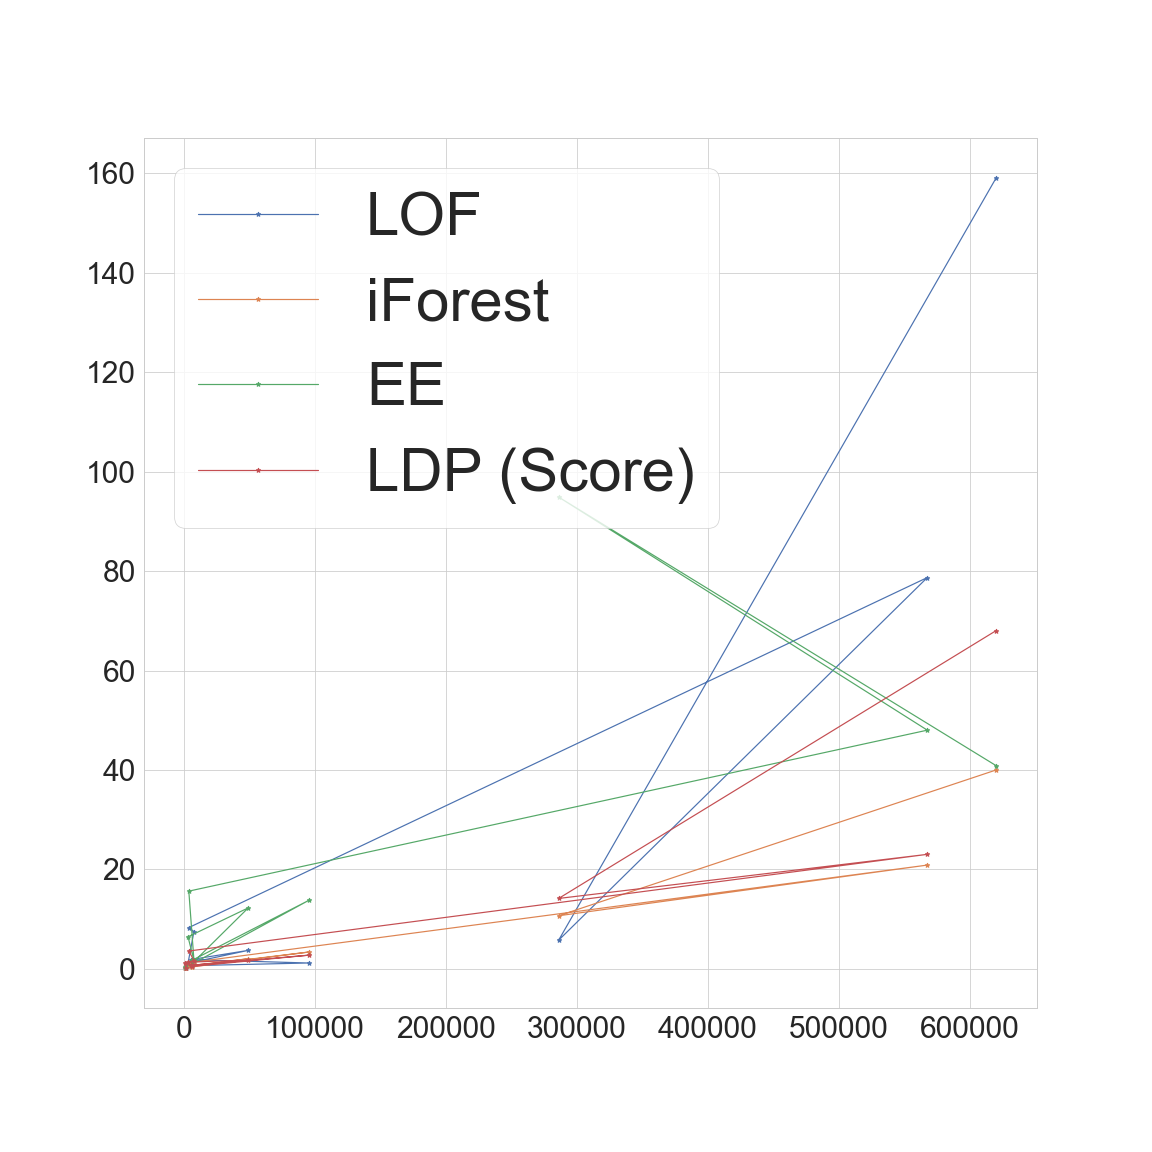

In [24]:
df_final=df_final.sort_values(by='N*D')
for c in cols:
    plt.plot(df_final['N'],df_final[c],'*-',label=c)
plt.legend()

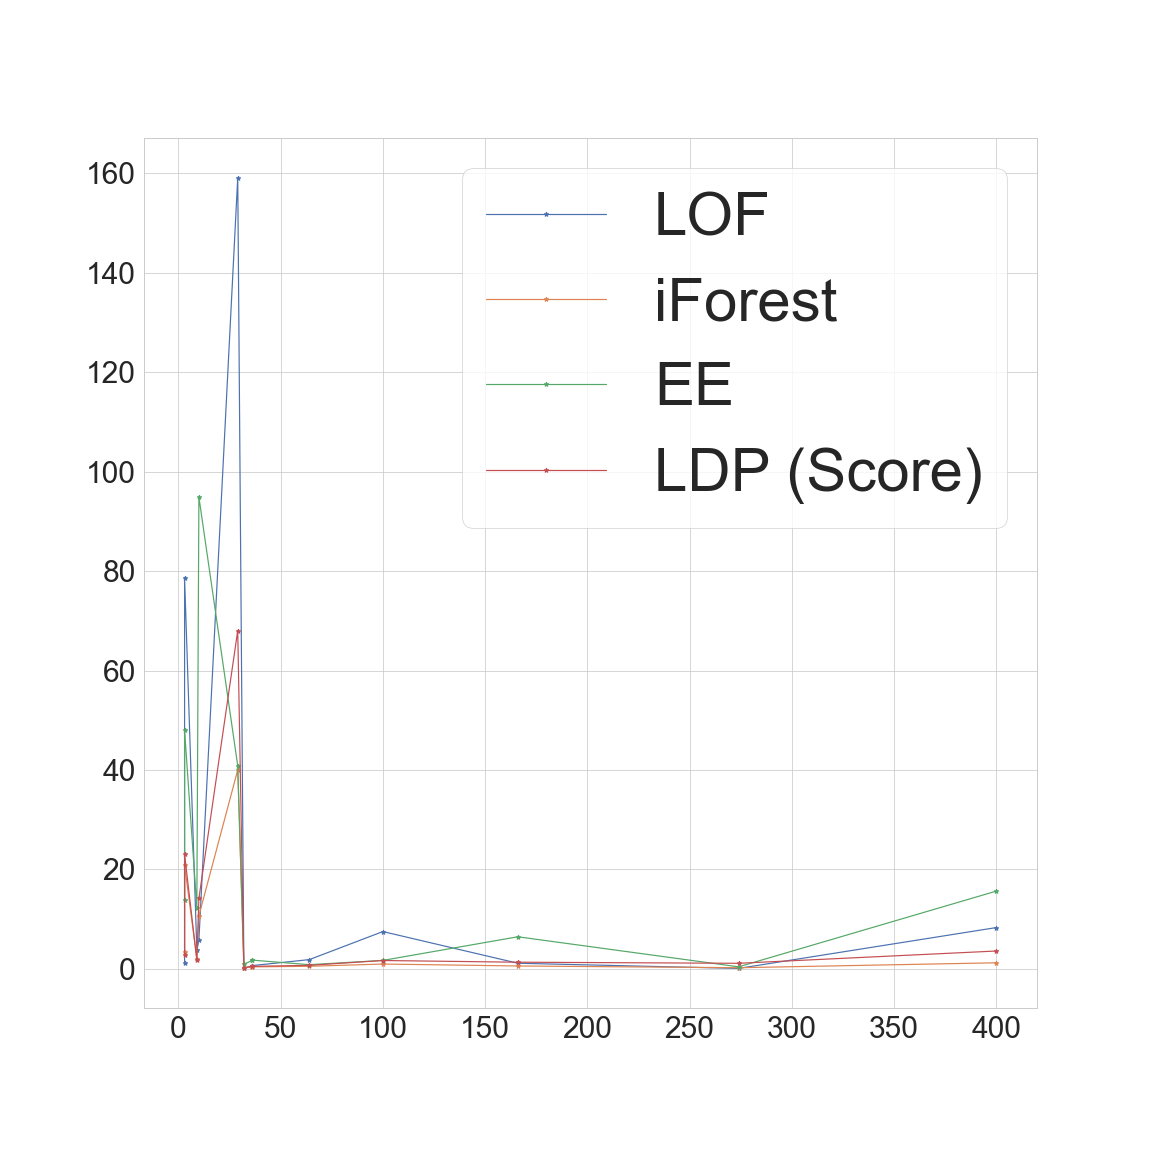

In [25]:
df_final=df_final.sort_values(by='D')
df_final

for c in cols:
    plt.plot(df_final['D'],df_final[c],'*-',label=c)
plt.legend()

<Figure size 1152x1152 with 0 Axes>

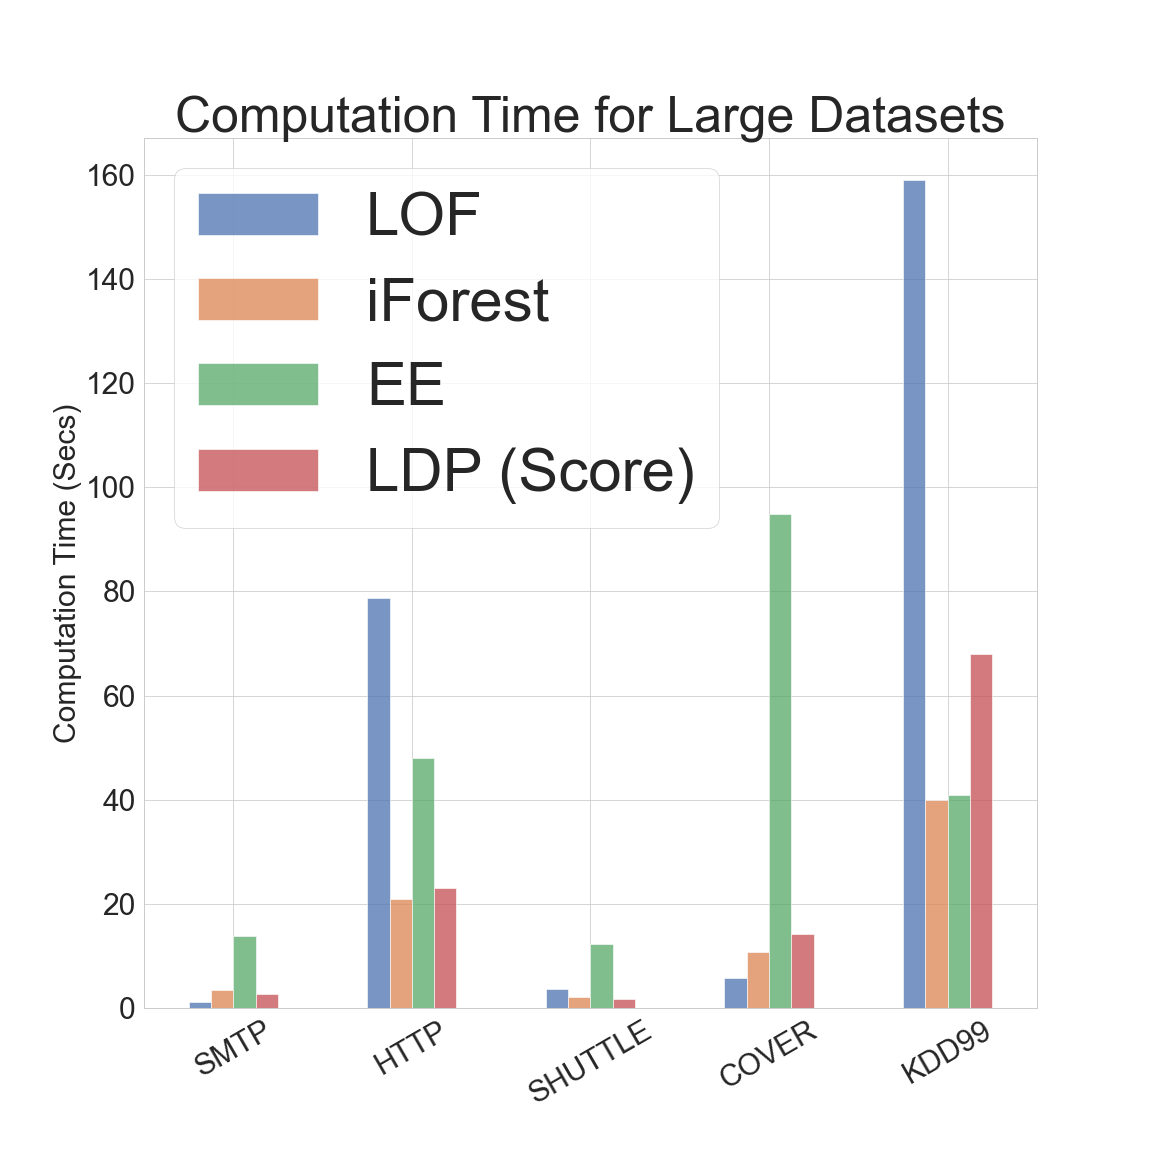

In [26]:
df_plot=df_final[df_final['N']>10000].set_index('Data').drop(['N','D','N*D'],axis=1)
plt.figure()
df_plot.plot.bar(alpha=0.75, rot=30)
plt.ylabel("Computation Time (Secs)")
plt.xlabel("")
plt.title('Computation Time for Large Datasets')
plt.savefig(image_path_non_stream_ad_large+'comp_time_long.png')

<Figure size 1152x1152 with 0 Axes>

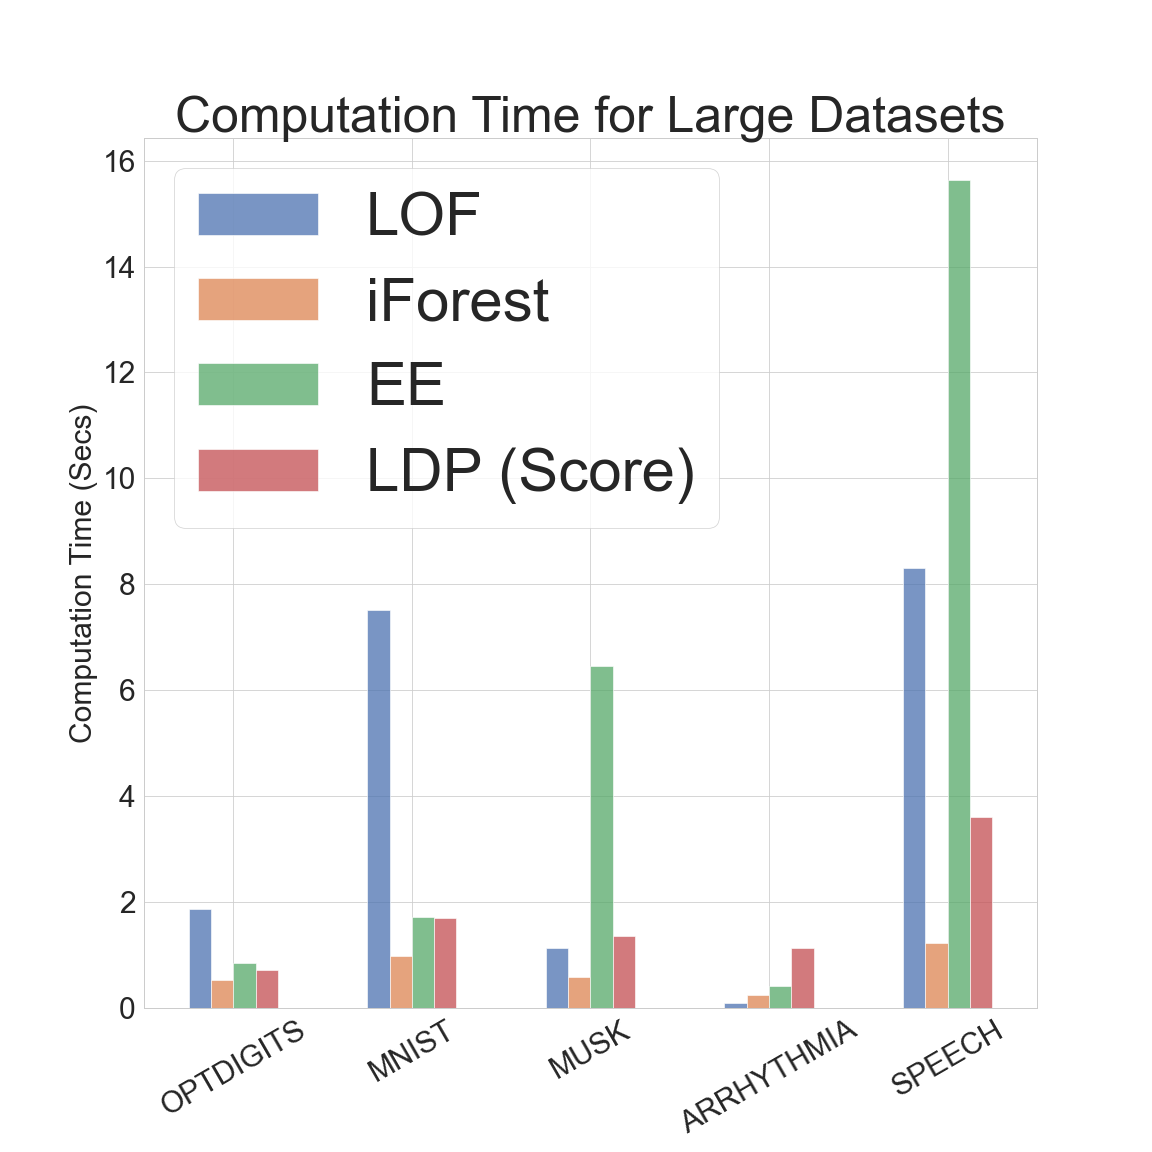

In [27]:
df_plot=df_final[df_final['D']>50].set_index('Data').drop(['N','D','N*D'],axis=1)
plt.figure()
df_plot.plot.bar(alpha=0.75, rot=30)
plt.ylabel("Computation Time (Secs)")
plt.xlabel("")
plt.title('Computation Time for Large Datasets')
plt.savefig(image_path_non_stream_ad_large+'comp_time_wide.png')

In [28]:
import plotly.express as px
px.data.tips()

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

In [29]:
df_plot.columns

Index(['LOF', 'iForest', 'EE', 'LDP (Score)'], dtype='object')

In [35]:
# Change the default stacking
import plotly.express as px
df_plot=df_final[df_final['D']>100].sort_values('D').drop(['N','D','N*D'],axis=1)
df = df_plot
df_plot.columns=['Data', 'LOF', 'iForest', 'EE', 'LAD']
fig = px.bar(df, x="Data", y=['LOF', 'iForest', 'EE', 'LAD'],
#              color='smoker', 
             barmode='group',
             height=400
            )
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',  plot_bgcolor='rgba(0,0,0,0)'
                 )

fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Time')
fig.update_layout(legend_title_text='Method')

fig.show()
fig.write_image(image_path_non_stream_ad_large+'comp_time_wide.png')

# Change the default stacking
import plotly.express as px
df_plot=df_final[df_final['N']>10000].sort_values('N').drop(['N','D','N*D'],axis=1)
df = df_plot
df_plot.columns=['Data', 'LOF', 'iForest', 'EE', 'LAD']
fig = px.bar(df, x="Data", y=['LOF', 'iForest', 'EE', 'LAD'],
#              color='smoker', 
             barmode='group',
             height=400)
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',     plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Time')
fig.update_layout(legend_title_text='Method')


fig.show()
fig.write_image(image_path_non_stream_ad_large+'comp_time_long.png')

In [30]:
df_plot

LOF  iForest     EE  LDP (Score)
Data                                         
OPTDIGITS   1.87     0.53   0.85         0.72
MNIST       7.51     0.98   1.71         1.69
MUSK        1.14     0.59   6.46         1.35
ARRHYTHMIA  0.10     0.24   0.42         1.13
SPEECH      8.31     1.23  15.64         3.60

In [34]:
df_final[df_final['D']>100].sort_values('N')

Data   LOF  iForest     EE  LDP (Score)       N  \
arrhythmia.mat.pickle  ARRHYTHMIA  0.10     0.24   0.42         1.13   452.0   
musk.mat.pickle              MUSK  1.14     0.59   6.46         1.35  3062.0   
speech.mat.pickle          SPEECH  8.31     1.23  15.64         3.60  3686.0   

                           D        N*D  
arrhythmia.mat.pickle  274.0   123848.0  
musk.mat.pickle        166.0   508292.0  
speech.mat.pickle      400.0  1474400.0

<Figure size 1152x1152 with 0 Axes>

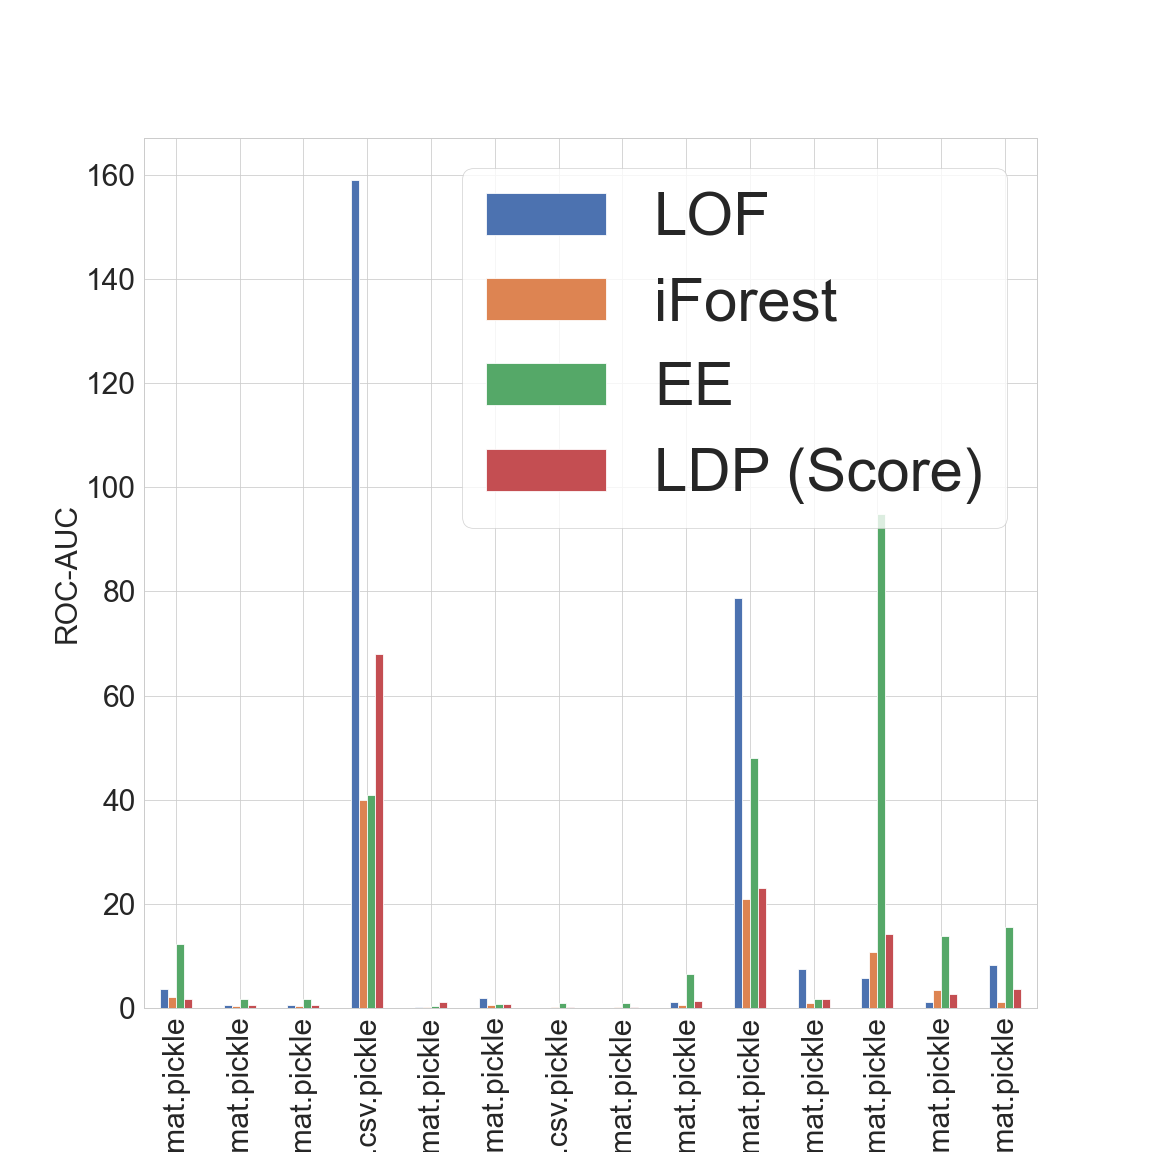

In [194]:
plt.figure()
df_final.drop(['Data'],axis=1).drop(['Avg Rank'],axis=0).plot.bar()
plt.ylabel("ROC-AUC")
labels=np.array([(s[0]) for s in np.array(df_final[['Data']].drop(['Avg Rank'],axis=0))])

# plt.xticks(labels)
# patches, labels = ax.get_legend_handles_labels()
# plt.legend(patches, labels, loc='best')

In [ ]:
print_df=df_final
cols=print_df.columns
data=print_df.index

for d in data:
    plt.plot()
    print_str=''
    for col in cols:
        print_str=print_str+str(print_df[col].loc[d])
        print_str=print_str+str(' & ')
    print_str=print_str+str(' \\\ ')
    print(print_str)

In [159]:
print_df.loc[d]

Data           AVERAGE RANK
LOF                    3.46
iForest                2.39
EE                     2.29
LDP (Score)            1.86
Name: Avg Rank, dtype: object

In [160]:
print_df

Data   LOF  iForest    EE  \
shuttle.mat.pickle                      SHUTTLE  0.52     0.98  0.96   
satimage-2.mat.pickle                SATIMAGE-2  0.57     0.95  0.96   
satellite.mat.pickle                  SATELLITE  0.51     0.64  0.65   
kdd99-unsupervised-ad.csv.pickle          KDD99  0.51     0.85  0.54   
arrhythmia.mat.pickle                ARRHYTHMIA  0.61     0.67  0.70   
optdigits.mat.pickle                  OPTDIGITS  0.51     0.52  0.45   
letter-unsupervised-ad.csv.pickle        LETTER  0.54     0.52  0.60   
letter.mat.pickle                        LETTER  0.54     0.54  0.60   
musk.mat.pickle                            MUSK  0.50     0.96  0.96   
http.mat.pickle                            HTTP  0.47     0.95  0.95   
mnist.mat.pickle                          MNIST  0.50     0.61  0.65   
cover.mat.pickle                          COVER  0.51     0.63  0.52   
smtp.mat.pickle                            SMTP  0.84     0.83  0.83   
speech.mat.pickle                        SPEECH  0.50     0.53  0.51   
Avg Rank                           AVERAGE RANK  3.46     2.39  2.29   

                                   LDP (Score)  
shuttle.mat.pickle                        0.99  
satimage-2.mat.pickle                     0.99  
satellite.mat.pickle                      0.60  
kdd99-unsupervised-ad.csv.pickle          1.00  
arrhythmia.mat.pickle                     0.71  
optdigits.mat.pickle                      0.48  
letter-unsupervised-ad.csv.pickle         0.60  
letter.mat.pickle                         0.60  
musk.mat.pickle                           0.96  
http.mat.pickle                           1.00  
mnist.mat.pickle                          0.87  
cover.mat.pickle                          0.96  
smtp.mat.pickle                           0.82  
speech.mat.pickle                         0.47  
Avg Rank                                  1.86

###### Scalability

In [36]:
data_source=data_source_large
results_path= results_path_non_stream_ad_large

# Anomaly Detection Non-Stream
onlyfiles = [f for f in listdir(data_source) if isfile(join(data_source, f)) and f not in 
             ['.DS_Store','ecoli.mat'] ]
error_count=0
large_dataset_count=0
max_size=20001


for f in onlyfiles[-4:-3]:
    file_path=data_source+'/'+f
    K=1
    th=0.95
    covariance_type='full'
    reg_covar=1e-16
    numiters=100
    conv_criteria=1e-30
    cluster_train=0.25


    df,X,y=load_data(file_path)
    XX=pd.DataFrame(X)
    print(f,X.shape)

#     N,D=X.shape
#     start=time.time()
#     output=ldp_cluster_kmeans(X,K,th,numiters,covariance_type,reg_covar,conv_criteria,cluster_train)
#     end=time.time()
#     output['file_path']=file_path
#     output['comp_time_secs']=end-start

#     pickle.dump( output, open(results_path+f+".pickle", "wb" ))

kdd99-unsupervised-ad.csv (620098, 29)


In [431]:
def ldp_cluster_kmeans(X,K_f,th_f,numiters,covariance_type,reg_covar,conv_criteria,cluster_train):
# if 1:
    thresholds=np.zeros(numiters)
    th=th_f
    N,D=X.shape
    if K_f>1:
        if D>20:
            pca = PCA(n_components=20).fit_transform(X)
            X_train, X_test = train_test_split(pca, train_size=cluster_train)
            kmeans = MiniBatchKMeans(n_clusters=K_f)
            kmeans = kmeans.partial_fit(X_train)
            z_1=kmeans.predict(pca)+1
#             clustering = OPTICS(min_samples=2).fit(pca)
#             z_1=clustering.labels_


        else:
            X_train, X_test = train_test_split(X, train_size=cluster_train)
            kmeans = MiniBatchKMeans(n_clusters=K_f)
            kmeans = kmeans.partial_fit(X_train)
            z_1=kmeans.predict(X)+1
    else:
        z_1=np.ones(N)        
        
    ana_score=np.zeros(N)
    converged_=0            

    for numiter in range(numiters):
        sys.stdout.write('*')
        clusters,sizes=np.unique(np.abs(z_1),return_counts=True)
        if len(clusters)<K_f:
            cluster_prob=(np.exp(cluster_log_probs))+sys.float_info.min
            cluster_prob/=np.sum(cluster_prob,axis=1)[:,np.newaxis]
            z_1=np.array([np.argmax(np.random.multinomial(1,cluster_prob[i]))+1 for i in range(N)])
            if len(np.unique(z_1))<K_f:
                K_f=len(np.unique(z_1))

#             break

            
        K=len(clusters)
        entropy_2 = np.empty((N, K, D))

        thetas=[]
        for k in clusters:
            ind_k_0=z_1==k
            ind_k=np.where(ind_k_0[ana_score<th])[0]
            c = len(ind_k)
            if c<3:
                ind_k=np.abs(z_1)==k
                thetas.append(tuple((np.mean(X[ind_k],axis=0), 
                            np.array([np.cov(X[:,d]) for d in range(D)]))))
            else:
                thetas.append(tuple((np.mean(X[ind_k],axis=0), 
                            np.array([np.cov(X[ind_k,d]) for d in range(D)]))))

                
        nk=sizes
        cc=range(len(thetas))
        means_=np.array([thetas[k][0].T for k in cc])
        covariances=np.array([thetas[k][1] for k in cc])
#         para_tuple=nk,means_,covariances


        n_samples, n_features = X.shape
        n_components, _ = means_.shape

        ss=[1/(cov) for cov in covariances]
        for k, (mu, prec_chol) in enumerate(zip(means_, ss)):
            prec_chol[np.isnan(prec_chol)]=0
            prec_chol[np.isinf(prec_chol)]=0
            y=(np.square(X-mu)*prec_chol)/2
            entropy_2[:, k, :] = (y)/sizes[k]
                
        entropy_DGProjection=np.max(entropy_2,axis=2)
        
        if K_f>1:
            cluster_log_probs=-(entropy_DGProjection*sizes)
#             cluster_prob=(np.exp(cluster_log_probs))
            z_1=np.argmax(cluster_log_probs,axis=1).flatten()+1

        ana_score=-np.max(-((entropy_DGProjection)), axis=1)
        ana_score=(ana_score-np.min(ana_score))/(np.max(ana_score)-np.min(ana_score))

#         ana_score=ana_score
        th=min(th_f,0.95,np.mean(ana_score)+2*np.cov(ana_score))

        ana_inds=ana_score>th

        z_1[ana_score>th]*=(-1)
        
        if np.sum(z_1<0)>min(0.25*N,D):
            z_1[np.argsort(-ana_score)[:int(0.25*N)]]=-1*np.abs(z_1[np.argsort(-ana_score)[:int(0.25*N)]])
            z_1[np.argsort(-ana_score)[int(0.25*N):]]=np.abs(z_1[np.argsort(-ana_score)[int(0.25*N):]])

        
        thresholds[numiter]=th
        
        if numiter > 100 and (np.max(np.abs(np.diff(thresholds[numiter-10:numiter])))<conv_criteria):
            converged_ += 1
            if converged_>0:
                print("Converged")
                break
                

    output={}
    output['z']=[z_1]
    output['entropy']=entropy_2
    output['prob']=ana_score
    output['thresholds']=thresholds
    return output

In [432]:
output_scaled_wide={}
N,D=X.shape
for d in np.arange(1,D):
    output_scaled_wide[d]={}
    K=1
    th=0.95
    covariance_type='full'
    reg_covar=1e-16
    numiters=100
    conv_criteria=1e-30
    cluster_train=0.25

    X_p=X[:,:d+1]
    start=time.time()

    output_scaled_wide[d]=ldp_cluster_kmeans(X_p,K,th,numiters,covariance_type,
                                        reg_covar,conv_criteria,cluster_train)
    end=time.time()
    output_scaled_wide[d]['file_path']=file_path
    output_scaled_wide[d]['comp_time_secs']=end-start

    print(X_p.shape)

****************************************************************************************************(620098, 2)
****************************************************************************************************(620098, 3)
****************************************************************************************************(620098, 4)
****************************************************************************************************(620098, 5)
****************************************************************************************************(620098, 6)
****************************************************************************************************(620098, 7)
****************************************************************************************************(620098, 8)
****************************************************************************************************(620098, 9)
****************************************************************************************************(620

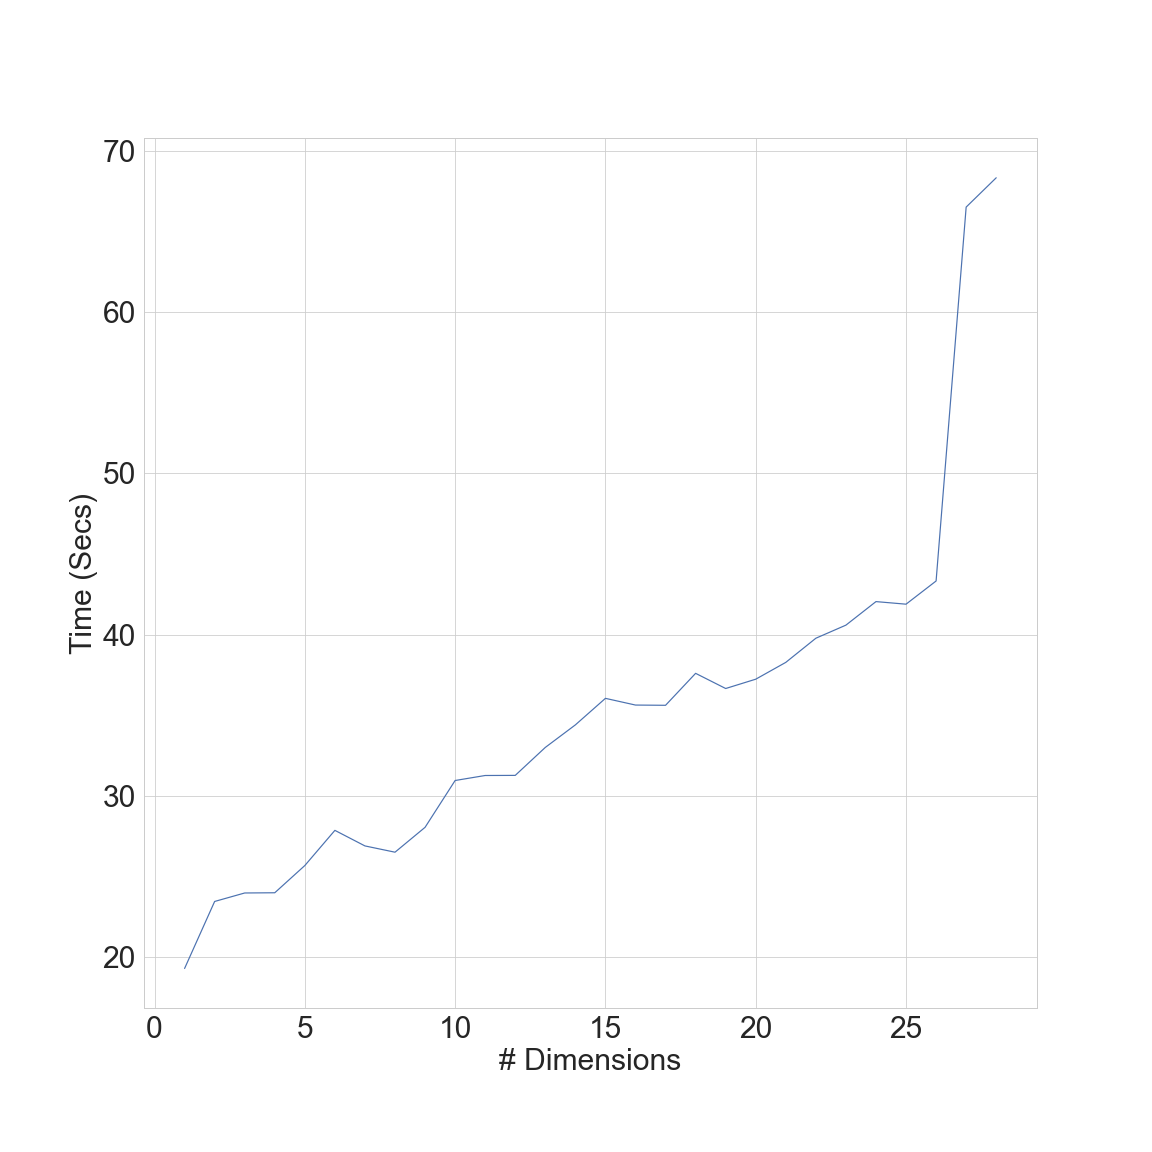

In [433]:
keys=output_scaled_wide.keys()
time_exe=[]
for key in keys:
    time_exe.append(output_scaled_wide[key]['comp_time_secs'])
plt.plot(keys,time_exe)
plt.xlabel('# Dimensions')
plt.ylabel('Time (Secs)')

plt.savefig(image_path_non_stream_ad_large+'scale_wide')

In [437]:
output_scaled={}
N,D=X.shape
for d in np.arange(0.01,1,0.1):
    output_scaled[d]={}
    K=1
    th=0.95
    covariance_type='full'
    reg_covar=1e-16
    numiters=100
    conv_criteria=1e-30
    cluster_train=0.25

    X_p=X[:int(d*N),:]
    
    start=time.time()

    ldp_cluster_kmeans(X_p,K,th,numiters,covariance_type,
                                        reg_covar,conv_criteria,cluster_train)
    end=time.time()
    output_scaled[d]['file_path']=file_path
    output_scaled[d]['comp_time_secs']=end-start

    print(X_p.shape)

****************************************************************************************************(6200, 29)
****************************************************************************************************(68210, 29)
****************************************************************************************************(130220, 29)
****************************************************************************************************(192230, 29)
****************************************************************************************************(254240, 29)
****************************************************************************************************(316249, 29)
****************************************************************************************************(378259, 29)
****************************************************************************************************(440269, 29)
***************************************************************************************************

In [ ]:
pickle.dump( output_scaled, open(results_path_non_stream_ad_large+"scale_long.pickle", "wb" ))
pickle.dump( output_scaled_wide, open(results_path_non_stream_ad_large+"scale_wide.pickle", "wb" ))

In [38]:
output_scaled=pickle.load( open(results_path_non_stream_ad_large+"scale_long.pickle", "rb" ))
output_scaled_wide=pickle.load(open(results_path_non_stream_ad_large+"scale_wide.pickle", "rb" ))

In [42]:
N,D=X.shape

In [48]:
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    print(val, signf)
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y


In [50]:
from matplotlib.ticker import FuncFormatter

No handles with labels found to put in legend.


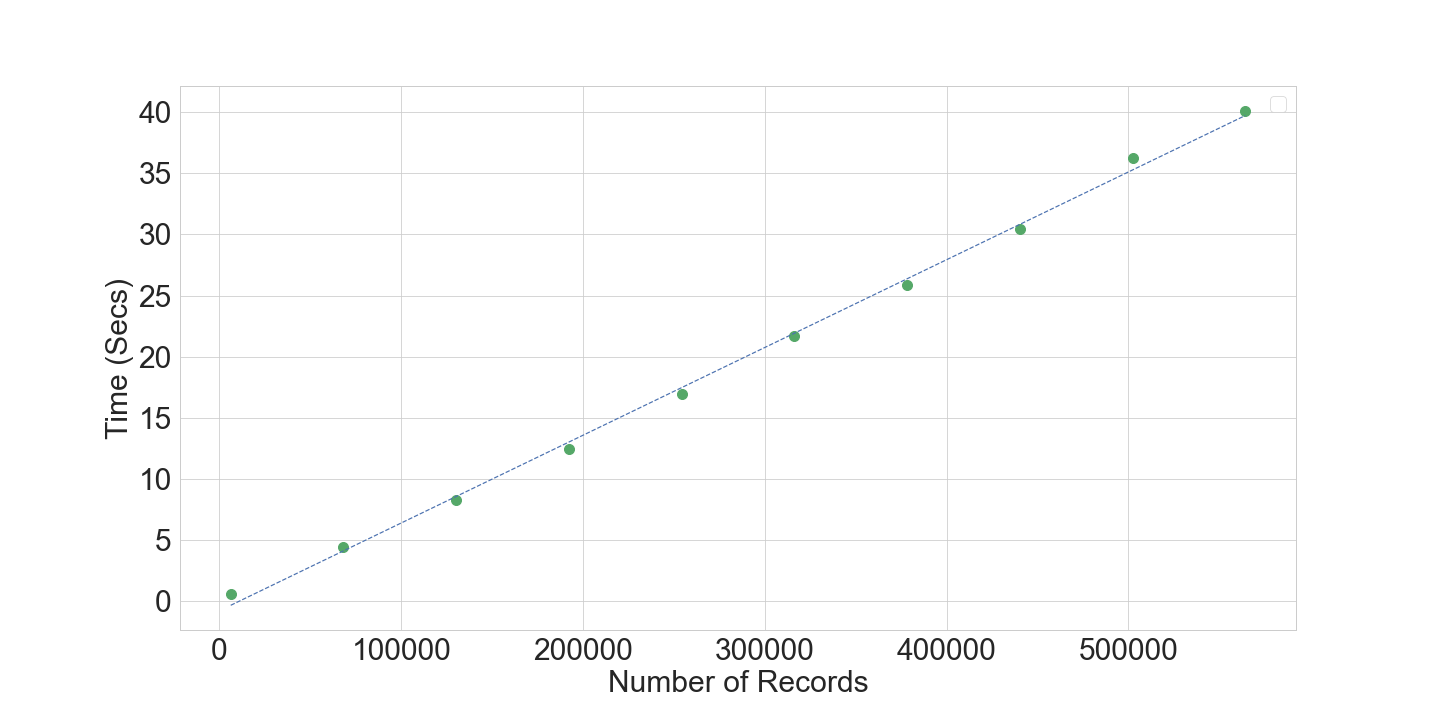

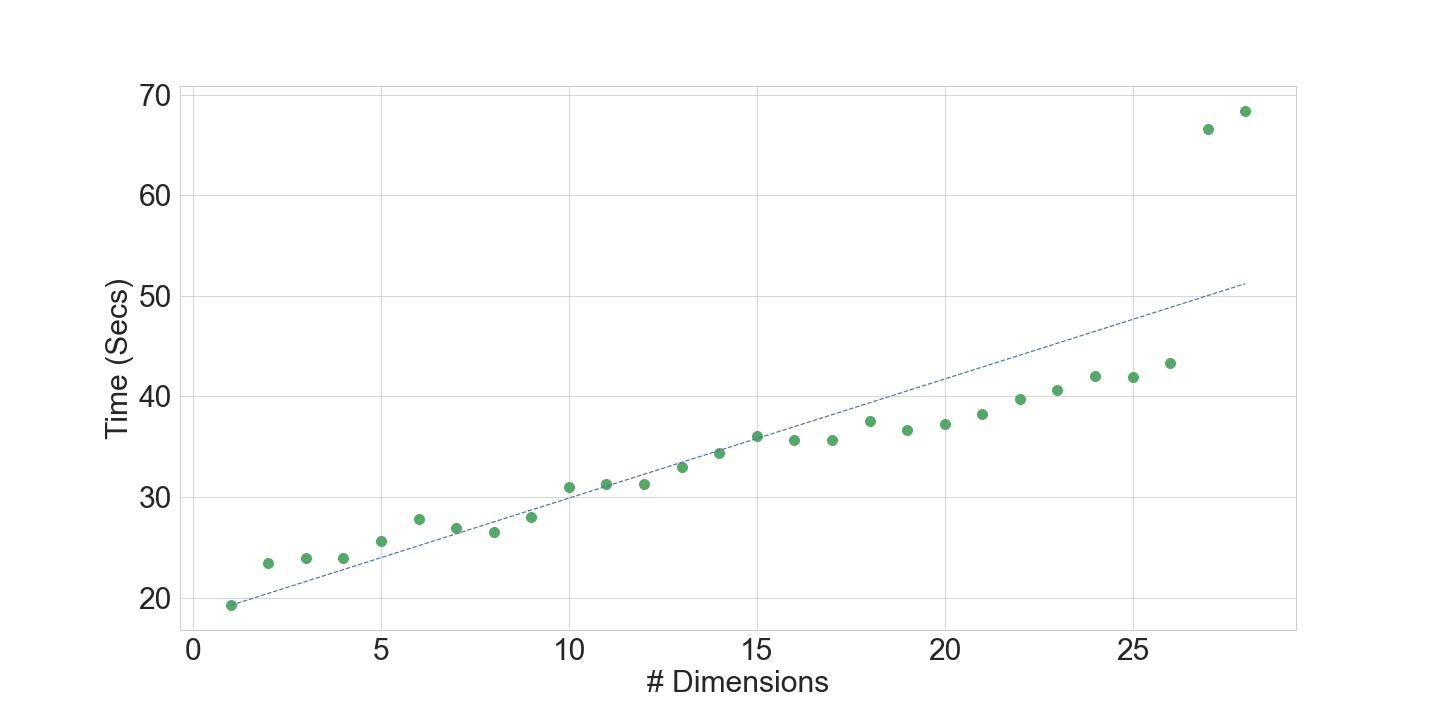

In [53]:
plt.figure(figsize=(20,10))

keys=output_scaled.keys()
time_exe=[]
for key in keys:
    time_exe.append(output_scaled[key]['comp_time_secs'])
    
x_range=np.array([*keys])*N
plt.plot(x_range.round(2),time_exe, 'g.', markersize=20)
# ax.xaxis.set_major_formatter(FuncFormatter(y_fmt))
plt.xlabel('Number of Records')
plt.ylabel('Time (Secs)')

slope2, intercept = np.polyfit(x_range/np.max(x_range), time_exe/np.max(time_exe), 1)
slope, intercept = np.polyfit(x_range, time_exe, 1)

x_vals = x_range
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--'
#         ,label='Slope ='+str(slope2.round(2))
        )
plt.legend(prop={'size': 20})

plt.savefig(image_path_non_stream_ad_large+'scale_long')

plt.figure(figsize=(20,10))
keys=output_scaled_wide.keys()
D=np.max([*keys])+1
time_exe=[]
for key in keys:
    time_exe.append(output_scaled_wide[key]['comp_time_secs'])
plt.plot(keys,time_exe, 'g.', markersize=20)
plt.xlabel('# Dimensions')
plt.ylabel('Time (Secs)')

slope, intercept = np.polyfit(np.arange(1,D), time_exe, 1)
x_vals = np.arange(1,D)
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--')

plt.savefig(image_path_non_stream_ad_large+'scale_wide')

###### CFOF

In [41]:
%run ./cfof.ipynb

In [42]:
results_path=results_path_non_stream_ad_large

In [43]:
onlyfiles = [f for f in listdir(results_path) if isfile(join(results_path, f))]
extension = 'pickle'

In [57]:
result=[o for o in onlyfiles if ".pickle" in o]
result[4:5]

['arrhythmia.arff.pickle']

In [121]:
perf_metrics=['tn','fp','fn','tp','fpr','tpr','thresholds','recall','specificity',
         'precision','accuracy','fmeasure','purity','auc','comp_time_secs']

models=['cfof','cfof_score'
       ]

datasets=[]
anomalies_eval_perf_metrics = {}

for metric in perf_metrics:
    anomalies_eval_perf_metrics[metric]= pd.DataFrame( index=datasets,columns=models)


In [123]:
drop_datasets=[
    'spambase.preproc.csv.pickle', 'opt.digits.preproc.csv.pickle','comm.and.crime.preproc.csv.pickle',
    'shuttle-unsupervised-ad.csv.pickle','letter-unsupervised-ad.csv.pickle',
    'shuttle.preproc.csv.pickle',
    'skin.preproc.csv.pickle','satimage.pickle.pickle',
    'gas.preproc.csv.pickle','ionosphere.mat.pickle', 'mnist.raw.pickle.pickle','birch-rg3.arff.pickle',
    'kdd99-unsupervised-ad.csv.pickle','birch-rg2.arff.pickle','birch-rg1.arff.pickle','sonar.arff.pickle',
    'arrhythmia.arff.pickle',
]

In [75]:
len(result)-len(drop_datasets)

12

In [104]:
result2=[f for f in result if f not in drop_datasets]
result2[5:6]

['letter.mat.pickle']

In [111]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

max_size=20000
for filename in result:
    name=filename.replace(results_path_non_stream_ad_large,'')
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    
    try:
        y=ana_label(y)
    except:
        try:
            y=ana_label(y['class'])
        except:
            pass
        
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    if filename not in drop_datasets and X.shape[0]<10000:

        start=time.time()
        model = ConcentrationFreeOutlierFactor(contamination=np.mean(y))
        outlier_labels = model.fit_predict(X) # -1 for outlier, 1 for inlier
        end=time.time()
        preds=(outlier_labels==-1)*1
        cfof_classify=perf_evaluate(X,y,preds)
        cfof_classify['comp_time_secs']=end-start




        for metric in perf_metrics:
            pd_row=[]
            pd_row.append(cfof_classify[metric])   


            anomalies_eval_perf_metrics[metric].loc[filename]=pd_row


In [118]:
anomalies_eval_perf_metrics['auc'].round(2)

cfof
arrhythmia.arff.pickle  0.45
satimage-2.mat.pickle   0.54
satellite.mat.pickle    0.55
arrhythmia.mat.pickle   0.54
optdigits.mat.pickle    0.49
letter.mat.pickle       0.71
musk.mat.pickle         0.50
mnist.mat.pickle        0.64
speech.mat.pickle       0.50

In [116]:
filename

'speech.mat.pickle'

In [125]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

max_size=20000
for filename in result:
    name=filename.replace(results_path_non_stream_ad_large,'')
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    
    try:
        y=ana_label(y)
    except:
        try:
            y=ana_label(y['class'])
        except:
            pass
        
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    if filename not in drop_datasets and X.shape[0]<10000:
        print(filename)

        start=time.time()
        model = ConcentrationFreeOutlierFactor(contamination=np.mean(y))
        outlier_labels = model.fit_predict(X) # -1 for outlier, 1 for inlier
        end=time.time()
        preds=(outlier_labels==-1)*1
        cfof_classify=perf_evaluate(X,y,preds)
        cfof_classify['comp_time_secs']=end-start


        start=time.time()
        scores=model.score_samples(X)
        end=time.time()
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        auc=metrics.auc(fpr, tpr)

        cfof_score=perf_evaluate(X,y,preds)
        cfof_score['auc']=auc
        cfof_score['comp_time_secs']=end-start
        print(auc)

        for metric in perf_metrics:
            pd_row=[]
            pd_row.append(cfof_classify[metric])  
            pd_row.append(cfof_score[metric])  


            anomalies_eval_perf_metrics[metric].loc[filename]=pd_row

        

satimage-2.mat.pickle
0.6963918893683103
satellite.mat.pickle
0.5546373506034369
arrhythmia.mat.pickle
0.5564256555189198
optdigits.mat.pickle
0.4869311751546256
letter.mat.pickle
0.9045099999999999
musk.mat.pickle
0.48627283948470995
mnist.mat.pickle
0.7501761139049274
speech.mat.pickle
0.4700169587337478


In [129]:
anomalies_eval_perf_metrics['auc'].round(2)

cfof  cfof_score
satimage-2.mat.pickle  0.54        0.70
satellite.mat.pickle   0.55        0.55
arrhythmia.mat.pickle  0.54        0.56
optdigits.mat.pickle   0.49        0.49
letter.mat.pickle      0.71        0.90
musk.mat.pickle        0.50        0.49
mnist.mat.pickle       0.64        0.75
speech.mat.pickle      0.50        0.47

In [130]:
pickle.dump(anomalies_eval_perf_metrics,open(results_path_non_stream_ad_large+'cfof_results.pickle','wb'))

###### OCSVM

In [8]:
results_path=results_path_non_stream_ad_large

In [9]:
onlyfiles = [f for f in listdir(results_path) if isfile(join(results_path, f))]
extension = 'pickle'

In [10]:
result=[o for o in onlyfiles if ".pickle" in o]
result

['shuttle.mat.pickle',
 'ionosphere.mat.pickle',
 'birch-rg3.arff.pickle',
 'spambase.preproc.csv.pickle',
 'arrhythmia.arff.pickle',
 'satimage-2.mat.pickle',
 'shuttle-unsupervised-ad.csv.pickle',
 'satellite.mat.pickle',
 'kdd99-unsupervised-ad.csv.pickle',
 'arrhythmia.mat.pickle',
 'satimage.pickle.pickle',
 'optdigits.mat.pickle',
 'gas.preproc.csv.pickle',
 'letter-unsupervised-ad.csv.pickle',
 'mnist.raw.pickle.pickle',
 'letter.mat.pickle',
 'opt.digits.preproc.csv.pickle',
 'birch-rg2.arff.pickle',
 'shuttle.preproc.csv.pickle',
 'musk.mat.pickle',
 'http.mat.pickle',
 'mnist.mat.pickle',
 'birch-rg1.arff.pickle',
 'cover.mat.pickle',
 'skin.preproc.csv.pickle',
 'sonar.arff.pickle',
 'comm.and.crime.preproc.csv.pickle',
 'smtp.mat.pickle',
 'speech.mat.pickle']

In [11]:
perf_metrics=['tn','fp','fn','tp','fpr','tpr','thresholds','recall','specificity',
         'precision','accuracy','fmeasure','purity','auc','comp_time_secs']

models=['ocsvm'
       ]

datasets=[]
anomalies_eval_perf_metrics = {}

for metric in perf_metrics:
    anomalies_eval_perf_metrics[metric]= pd.DataFrame( index=datasets,columns=models)


In [12]:
drop_datasets=[
    'spambase.preproc.csv.pickle', 'opt.digits.preproc.csv.pickle','comm.and.crime.preproc.csv.pickle',
    'shuttle-unsupervised-ad.csv.pickle','letter-unsupervised-ad.csv.pickle',
    'shuttle.preproc.csv.pickle',
    'skin.preproc.csv.pickle','satimage.pickle.pickle',
    'gas.preproc.csv.pickle','ionosphere.mat.pickle', 'mnist.raw.pickle.pickle','birch-rg3.arff.pickle',
    'kdd99-unsupervised-ad.csv.pickle','birch-rg2.arff.pickle','birch-rg1.arff.pickle','sonar.arff.pickle',
    'arrhythmia.arff.pickle',
]

In [13]:
len(result)-len(drop_datasets)

12

In [14]:
result2=[f for f in result if f not in drop_datasets]
result2[5:6]

['letter.mat.pickle']

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

max_size=20000
for filename in result[5:6]:
    name=filename.replace(results_path_non_stream_ad_large,'')
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    
    
    try:
        y=ana_label(y)
    except:
        try:
            y=ana_label(y['class'])
        except:
            pass
        
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    if filename not in drop_datasets:
        print(name, X.shape)



        djksdk
        for metric in perf_metrics:
            pd_row=[]
            pd_row.append(cfof_classify[metric])   


            anomalies_eval_perf_metrics[metric].loc[filename]=pd_row


satimage-2.mat.pickle (5803, 36)


NameError: name 'djksdk' is not defined

In [22]:
max_key

0.1

In [23]:
pp

[0.2850834946875952,
 0.2636950453593859,
 0.2636950453593859,
 0.2636950453593859,
 0.2636950453593859,
 0.2636950453593859,
 0.2636950453593859,
 0.2636950453593859,
 0.2636950453593859]

In [36]:
anomalies_eval_perf_metrics['auc']

ocsvm
satimage-2.mat.pickle  0.413414
satellite.mat.pickle   0.497110
arrhythmia.mat.pickle  0.477469
optdigits.mat.pickle   0.503907
letter.mat.pickle      0.535667
musk.mat.pickle        0.611876
mnist.mat.pickle       0.104282
speech.mat.pickle      0.488038

In [20]:
filename

'scale_wide.pickle'

In [118]:
anomalies_eval_perf_metrics['auc'].round(2)

cfof
arrhythmia.arff.pickle  0.45
satimage-2.mat.pickle   0.54
satellite.mat.pickle    0.55
arrhythmia.mat.pickle   0.54
optdigits.mat.pickle    0.49
letter.mat.pickle       0.71
musk.mat.pickle         0.50
mnist.mat.pickle        0.64
speech.mat.pickle       0.50

In [116]:
filename

'speech.mat.pickle'

In [125]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

max_size=20000
for filename in result:
    name=filename.replace(results_path_non_stream_ad_large,'')
    output=pickle.load( open(results_path_non_stream_ad_large+filename , "rb" )) 
    file_path=output['file_path']
    df,X,y=load_data(file_path)
    
    try:
        y=ana_label(y)
    except:
        try:
            y=ana_label(y['class'])
        except:
            pass
        
    try:    
        if y.shape[1]>1:
            y_temp=y
            y=np.copy(np.array(y_temp)[:,np.argmax(np.sum(y_temp))])
    except:
        pass
    if filename not in drop_datasets and X.shape[0]<10000:
        print(filename)

        start=time.time()
        model = ConcentrationFreeOutlierFactor(contamination=np.mean(y))
        outlier_labels = model.fit_predict(X) # -1 for outlier, 1 for inlier
        end=time.time()
        preds=(outlier_labels==-1)*1
        cfof_classify=perf_evaluate(X,y,preds)
        cfof_classify['comp_time_secs']=end-start


        start=time.time()
        scores=model.score_samples(X)
        end=time.time()
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        auc=metrics.auc(fpr, tpr)

        cfof_score=perf_evaluate(X,y,preds)
        cfof_score['auc']=auc
        cfof_score['comp_time_secs']=end-start
        print(auc)

        for metric in perf_metrics:
            pd_row=[]
            pd_row.append(cfof_classify[metric])  
            pd_row.append(cfof_score[metric])  


            anomalies_eval_perf_metrics[metric].loc[filename]=pd_row

        

satimage-2.mat.pickle
0.6963918893683103
satellite.mat.pickle
0.5546373506034369
arrhythmia.mat.pickle
0.5564256555189198
optdigits.mat.pickle
0.4869311751546256
letter.mat.pickle
0.9045099999999999
musk.mat.pickle
0.48627283948470995
mnist.mat.pickle
0.7501761139049274
speech.mat.pickle
0.4700169587337478


In [129]:
anomalies_eval_perf_metrics['auc'].round(2)

cfof  cfof_score
satimage-2.mat.pickle  0.54        0.70
satellite.mat.pickle   0.55        0.55
arrhythmia.mat.pickle  0.54        0.56
optdigits.mat.pickle   0.49        0.49
letter.mat.pickle      0.71        0.90
musk.mat.pickle        0.50        0.49
mnist.mat.pickle       0.64        0.75
speech.mat.pickle      0.50        0.47

In [130]:
pickle.dump(anomalies_eval_perf_metrics,open(results_path_non_stream_ad_large+'cfof_results.pickle','wb'))